# Targeted protein quantification from list of targets generated in R
needed to use R for peptide-to-protein mapping, jump back here to do quant because it is much faster

### All files needed for quant are on github at:
DI2A/data/targeted_quant

In [1]:
from pyteomics import mgf
from pyteomics import mzxml
from pyteomics import mass

import pandas as pd
import numpy as np
import re
import pickle
import timeit
import time
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pylab import rcParams
from sklearn.metrics import r2_score

from scipy.stats import ttest_ind, spearmanr
import scipy.stats as stats
from scipy.stats import zscore

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

### Functions to match intensities, m/z, and to get quant frags from the target table

In [2]:
DIRECTORY = "P:/JGM_DI2A/MSDATA/20200217_FIDIA_mitotox3_targeted/"

In [3]:
# to extract the int values between two other values
def getFragInt(pred_mass, mz_list, int_list, tol, tol_type):
    ''' 
    PURPOSE:
    Find observed intensity for theoretical m/z value in spectra
    
    INPUTS:
    pred_mass = the theoretical mass of the fragment ion
    mz_array = numpy array of all peak masses in the spectra
    int_array = numpy array of all peak intensities in the spectra
    ppm = the mass tolerance for the fragments in ppm
    noiselevel = value to be subtracted from each value
    
    OUTPUTS:
    numpy array containing the intensity for any m/z found
    
    '''
    if tol_type=="ppm":
        lowmz = pred_mass - pred_mass*tol
        highmz = pred_mass + pred_mass*tol
    if tol_type == "abs":
        lowmz = pred_mass - tol
        highmz = pred_mass + tol
    found = [int_list[index] for index, value in enumerate(mz_list) if value>lowmz and value<highmz]
    #found = found-noiselevel
    if len(found)==0:
        found = [1]
    return(found[0])

In [4]:
# function to get the quant frag table from the line in the target table
def getQuantFragsFromTargetList(target_table, line):
    tmpline = target_table.iloc[line]
    if(len(tmpline['ylight'])>1):
        output= pd.DataFrame( {'lightmz':[float(x) for x in tmpline['ylight']], 
                   'heavymz':[float(x) for x in tmpline['yheavy']]})
    if(len(tmpline['ylight'])<2):
        print(str(tmpline['Peptide'])+'not enough fragments')
        output = 'not enough fragments'
    return(output)

# For most intense peptide set - need to match peptide targets to scans

### Import the quant target table from R

In [5]:
qtargs = pd.read_csv("P:/JGM_DI2A/R/outputs/MITOTOX3_mostintense_quantmzlist.txt", sep="\t",
                          converters={"ylight": lambda x: x.strip("[]").split(", "),
                                     "yheavy": lambda x: x.strip("[]").split(", "), 
                                     "yordinals": lambda x: x.strip("[]").split(", ")})

In [6]:
target_scan_ids = [(qtargs['prec_light_mz'][x], qtargs['prec_heavy_mz'][x], qtargs['CV'][x]) for x in range(len(qtargs))]

In [10]:
### makes a dict of scan:CV value pairs for lookup of the CV - just need to put one mzXML in
# pick any of the quant files
tmp_prec_dict = {}
with mzxml.read("P:/JGM_DI2A/MSDATA/20200217_FIDIA_mitotox3_targeted/20200217_JGM_FIDIA_tMS2_246ms_1iso_001.mzXML") as spectra:
    for x in spectra:
        tmp_prec_dict[round(x['precursorMz'][0]['precursorMz'], 2), 
                                   round(x['precursorMz'][1]['precursorMz'], 2), 
                                  x['compensationVoltage']] = x['num']

In [11]:
## fix the numbering of which scan each peptide should be quantified from because the table in case the table has decoys
quant_scan = []
for x in target_scan_ids:
    quant_scan.append(tmp_prec_dict[(x)])
qtargs['quantscan'] = quant_scan

In [12]:
os.getcwd()

'C:\\Users\\jesse\\DI2A'

In [13]:
fileslist = []
for file in os.listdir(DIRECTORY):
    if file.endswith(".mzXML"):
        fileslist.append(os.path.join(DIRECTORY, file))
        #print(os.path.join(DIRECTORY, file))

In [14]:
fileslist

['P:/JGM_DI2A/MSDATA/20200217_FIDIA_mitotox3_targeted/20200217_JGM_FIDIA_tMS2_246ms_1iso_001.mzXML',
 'P:/JGM_DI2A/MSDATA/20200217_FIDIA_mitotox3_targeted/20200217_JGM_FIDIA_tMS2_246ms_1iso_002.mzXML',
 'P:/JGM_DI2A/MSDATA/20200217_FIDIA_mitotox3_targeted/20200217_JGM_FIDIA_tMS2_246ms_1iso_003.mzXML',
 'P:/JGM_DI2A/MSDATA/20200217_FIDIA_mitotox3_targeted/20200217_JGM_FIDIA_tMS2_246ms_1iso_004.mzXML',
 'P:/JGM_DI2A/MSDATA/20200217_FIDIA_mitotox3_targeted/20200217_JGM_FIDIA_tMS2_246ms_1iso_005.mzXML',
 'P:/JGM_DI2A/MSDATA/20200217_FIDIA_mitotox3_targeted/20200217_JGM_FIDIA_tMS2_246ms_1iso_006.mzXML',
 'P:/JGM_DI2A/MSDATA/20200217_FIDIA_mitotox3_targeted/20200217_JGM_FIDIA_tMS2_246ms_1iso_007.mzXML',
 'P:/JGM_DI2A/MSDATA/20200217_FIDIA_mitotox3_targeted/20200217_JGM_FIDIA_tMS2_246ms_1iso_008.mzXML',
 'P:/JGM_DI2A/MSDATA/20200217_FIDIA_mitotox3_targeted/20200217_JGM_FIDIA_tMS2_246ms_1iso_009.mzXML',
 'P:/JGM_DI2A/MSDATA/20200217_FIDIA_mitotox3_targeted/20200217_JGM_FIDIA_tMS2_246ms_1iso_01

In [15]:
len(fileslist)

132

# require 1 ions, 12ppm tolerance

In [173]:
### require 3 ratios
resultsdict = {}
stt = time.time()
TOL_TYPE = "ppm"
TOL = 12e-6
MIN_RATIOS = 1
resultsdf = pd.DataFrame(qtargs['Protein'])

counter = 1
for k in fileslist:
    print(counter)
    meanratio_list = []
    medianratio_list= []
    matchdf_list = []
    quantscans = qtargs['quantscan']
    with mzxml.read(k, use_index =True) as tmpquantfile:
        #quantscans = sortedpepdf['quantscans'].tolist()
        peplist = qtargs['Peptide'].tolist()
        #specnamelist = sortedpepdf['Name'].tolist()
        looplen = len(qtargs)
        st = time.time()
        for i in range(0, looplen):
            #print(i)
            #sts = time.time()
            tmp_qf = getQuantFragsFromTargetList(qtargs, i)
            ####################################################################
            ### need to deal with if there are not enought fragments
            if(type(tmp_qf)==str):
                meanratio_list.append([])
                medianratio_list.append([])
            if(type(tmp_qf)!=str):
                tmpmzarray = tmpquantfile.get_by_id(quantscans[i])['m/z array'].tolist()
                tmpintarray = tmpquantfile.get_by_id(quantscans[i])['intensity array'].tolist()
                noiselvl = np.mean(sorted(tmpintarray)[0:9])
                lightints = [getFragInt(x, tmpmzarray, tmpintarray, TOL, TOL_TYPE) for x in tmp_qf['lightmz']]
                heavyints = [getFragInt(x, tmpmzarray, tmpintarray, TOL, TOL_TYPE) for x in tmp_qf['heavymz']]
                ratios = [x/y for x,y in zip(heavyints, lightints)]
                tmp_qf['lightint'] = lightints
                tmp_qf['heavyint'] = heavyints
                tmp_qf['HLratios'] = ratios
                matchdf_list.append(tmp_qf)
                
                intsum = [sum(x) for x in zip(heavyints, lightints)]
                rm = [index for index, value in enumerate(intsum) if value==2] # get index of values that are both 1 
                for x in sorted(rm, reverse=True):
                    del lightints[x]
                    del heavyints[x]
                # after removing pairs where both are missing, replace missing values with noise level
                for x in range(0, len(heavyints)):
                    if heavyints[x]==1:
                        heavyints[x]=noiselvl
                for x in range(0, len(lightints)):
                    if lightints[x]==1:
                        lightints[x]=noiselvl
                # compute ratios
                rm0ratios = [x/y for x,y in zip(heavyints, lightints)]
                # check if there are less than MIN_RATIOS ratios total, if so, set ratio to empty
                if len(rm0ratios)<MIN_RATIOS:
                    meanratio_list.append([])
                    medianratio_list.append([])
                else:
                    meanratio_list.append(np.mean(rm0ratios))
                    medianratio_list.append(np.median(rm0ratios))
                #print('time for 1 spec= '+str(time.time()-sts))
        print('file= '+k[-9:-6]+', quantified '+str(looplen/(time.time()-st))+' spectra per second')
    print(k[-9:-6])
    resultsdf[k[-9:-6]] = medianratio_list
    resultsdict[k[-9:-6]] = [matchdf_list, medianratio_list, meanratio_list]
    counter+=1
print(time.time()-stt)

1
VNQIGSVTESLQAC+57.0215Knot enough fragments
VLTNITVSC+57.0215QEKnot enough fragments
GLGLSPDLIVC+57.0215Rnot enough fragments
QSIAIDDC+57.0215TFHQC+57.0215VRnot enough fragments
file= 001, quantified 259.0004963318679 spectra per second
001
2
VNQIGSVTESLQAC+57.0215Knot enough fragments
VLTNITVSC+57.0215QEKnot enough fragments
GLGLSPDLIVC+57.0215Rnot enough fragments
QSIAIDDC+57.0215TFHQC+57.0215VRnot enough fragments
file= 002, quantified 261.99782438456594 spectra per second
002
3
VNQIGSVTESLQAC+57.0215Knot enough fragments
VLTNITVSC+57.0215QEKnot enough fragments
GLGLSPDLIVC+57.0215Rnot enough fragments
QSIAIDDC+57.0215TFHQC+57.0215VRnot enough fragments
file= 003, quantified 245.3684615912446 spectra per second
003
4
VNQIGSVTESLQAC+57.0215Knot enough fragments
VLTNITVSC+57.0215QEKnot enough fragments
GLGLSPDLIVC+57.0215Rnot enough fragments
QSIAIDDC+57.0215TFHQC+57.0215VRnot enough fragments
file= 004, quantified 276.749193218264 spectra per second
004
5
VNQIGSVTESLQAC+57.0215Knot

file= 036, quantified 275.39441769145645 spectra per second
036
35
VNQIGSVTESLQAC+57.0215Knot enough fragments
VLTNITVSC+57.0215QEKnot enough fragments
GLGLSPDLIVC+57.0215Rnot enough fragments
QSIAIDDC+57.0215TFHQC+57.0215VRnot enough fragments
file= 037, quantified 267.2580509528223 spectra per second
037
36
VNQIGSVTESLQAC+57.0215Knot enough fragments
VLTNITVSC+57.0215QEKnot enough fragments
GLGLSPDLIVC+57.0215Rnot enough fragments
QSIAIDDC+57.0215TFHQC+57.0215VRnot enough fragments
file= 038, quantified 240.92058577534817 spectra per second
038
37
VNQIGSVTESLQAC+57.0215Knot enough fragments
VLTNITVSC+57.0215QEKnot enough fragments
GLGLSPDLIVC+57.0215Rnot enough fragments
QSIAIDDC+57.0215TFHQC+57.0215VRnot enough fragments
file= 039, quantified 229.0818063886082 spectra per second
039
38
VNQIGSVTESLQAC+57.0215Knot enough fragments
VLTNITVSC+57.0215QEKnot enough fragments
GLGLSPDLIVC+57.0215Rnot enough fragments
QSIAIDDC+57.0215TFHQC+57.0215VRnot enough fragments
file= 040, quantified 

GLGLSPDLIVC+57.0215Rnot enough fragments
QSIAIDDC+57.0215TFHQC+57.0215VRnot enough fragments
file= 076, quantified 248.87151909908835 spectra per second
076
69
VNQIGSVTESLQAC+57.0215Knot enough fragments
VLTNITVSC+57.0215QEKnot enough fragments
GLGLSPDLIVC+57.0215Rnot enough fragments
QSIAIDDC+57.0215TFHQC+57.0215VRnot enough fragments
file= 077, quantified 314.6891512549263 spectra per second
077
70
VNQIGSVTESLQAC+57.0215Knot enough fragments
VLTNITVSC+57.0215QEKnot enough fragments
GLGLSPDLIVC+57.0215Rnot enough fragments
QSIAIDDC+57.0215TFHQC+57.0215VRnot enough fragments
file= 078, quantified 266.47052714824594 spectra per second
078
71
VNQIGSVTESLQAC+57.0215Knot enough fragments
VLTNITVSC+57.0215QEKnot enough fragments
GLGLSPDLIVC+57.0215Rnot enough fragments
QSIAIDDC+57.0215TFHQC+57.0215VRnot enough fragments
file= 079, quantified 261.5431321998878 spectra per second
079
72
VNQIGSVTESLQAC+57.0215Knot enough fragments
VLTNITVSC+57.0215QEKnot enough fragments
GLGLSPDLIVC+57.0215Rno

VNQIGSVTESLQAC+57.0215Knot enough fragments
VLTNITVSC+57.0215QEKnot enough fragments
GLGLSPDLIVC+57.0215Rnot enough fragments
QSIAIDDC+57.0215TFHQC+57.0215VRnot enough fragments
file= 111, quantified 240.66758635219918 spectra per second
111
103
VNQIGSVTESLQAC+57.0215Knot enough fragments
VLTNITVSC+57.0215QEKnot enough fragments
GLGLSPDLIVC+57.0215Rnot enough fragments
QSIAIDDC+57.0215TFHQC+57.0215VRnot enough fragments
file= 112, quantified 232.7369337080981 spectra per second
112
104
VNQIGSVTESLQAC+57.0215Knot enough fragments
VLTNITVSC+57.0215QEKnot enough fragments
GLGLSPDLIVC+57.0215Rnot enough fragments
QSIAIDDC+57.0215TFHQC+57.0215VRnot enough fragments
file= 113, quantified 250.67011065162157 spectra per second
113
105
VNQIGSVTESLQAC+57.0215Knot enough fragments
VLTNITVSC+57.0215QEKnot enough fragments
GLGLSPDLIVC+57.0215Rnot enough fragments
QSIAIDDC+57.0215TFHQC+57.0215VRnot enough fragments
file= 114, quantified 245.09559089144605 spectra per second
114
106
VNQIGSVTESLQAC+57

In [193]:
resultsdf.to_pickle('P:/JGM_DI2A/Python/outputs/mitotox3/mitotox3_1ion12ppm.pickle')

In [ ]:
results

In [194]:
resultsdf.index = resultsdf['Protein']
df = resultsdf.apply (pd.to_numeric, errors='coerce')
df = df.drop('Protein', 1)
#df = df.drop('sp|P00761|TRYP_PIG Trypsin OS=Sus scrofa PE=1 SV=1')
#df = df.drop('sp|P02769|ALBU_BOVIN Serum albumin OS=Bos taurus GN=ALB PE=1 SV=4')
#df = df.drop('sp|P69905|HBA_HUMAN Hemoglobin subunit alpha OS=Homo sapiens GN=HBA1 PE=1 SV=2')
#df = df.dropna(thresh=99)
#df.to_csv('P:/JGM_DI2A/Python/outputs/mitotox3/allquant_req2pairs_new60.csv')

In [195]:
df = df.reindex(sorted(df.columns), axis=1) # re-order columns to have numbers in order

In [196]:
df

001        002  \
Protein                                                                    
sp|Q9UKK9|NUDT5_HUMAN ADP-sugar pyrophosphatase...   1.734150   1.651208   
sp|P04843|RPN1_HUMAN Dolichyl-diphosphooligosac...   2.807018   1.782797   
sp|P30086|PEBP1_HUMAN Phosphatidylethanolamine-...   0.440761   0.570583   
sp|Q14739|LBR_HUMAN Delta(14)-sterol reductase ...   1.079907   1.827663   
sp|P60709|ACTB_HUMAN Actin, cytoplasmic 1 OS=Ho...   1.841638   2.165706   
sp|P61923|COPZ1_HUMAN Coatomer subunit zeta-1 O...   0.692151   1.891506   
sp|P49720|PSB3_HUMAN Proteasome subunit beta ty...   2.474280   2.906650   
sp|P63261|ACTG_HUMAN Actin, cytoplasmic 2 OS=Ho...   3.758746   3.891269   
sp|Q13283|G3BP1_HUMAN Ras GTPase-activating pro...   0.468723   0.344551   
sp|Q99497|PARK7_HUMAN Protein/nucleic acid degl...   2.303183   3.009548   
sp|Q15637|SF01_HUMAN Splicing factor 1 OS=Homo ...   0.996737   1.293905   
sp|O75367|H2AY_HUMAN Core histone macro-H2A.1 O...   2.727135   1.007035   
sp|P52597|HNRPF_HUMAN Heterogeneous nuclear rib...   1.626555   1.484474   
sp|Q8NB46|ANR52_HUMAN Serine/threonine-protein ...        NaN        NaN   
sp|P06454|PTMA_HUMAN Prothymosin alpha OS=Homo ...   2.135577   1.940767   
sp|P30084|ECHM_HUMAN Enoyl-CoA hydratase, mitoc...   3.152050   1.601004   
sp|Q16531|DDB1_HUMAN DNA damage-binding protein...   1.895624   0.771204   
sp|P82970|HMGN5_HUMAN High mobility group nucle...   0.958550   0.616443   
sp|P61163|ACTZ_HUMAN Alpha-centractin OS=Homo s...   1.314128   3.180104   
sp|P05386|RLA1_HUMAN 60S acidic ribosomal prote...   0.693003   0.869373   
sp|Q00341|VIGLN_HUMAN Vigilin OS=Homo sapiens O...   1.851426   1.086597   
sp|O75607|NPM3_HUMAN Nucleoplasmin-3 OS=Homo sa...   0.908842   1.540965   
sp|Q9NTK5|OLA1_HUMAN Obg-like ATPase 1 OS=Homo ...   1.307583        NaN   
sp|O14979|HNRDL_HUMAN Heterogeneous nuclear rib...   2.150121   2.775082   
sp|P20674|COX5A_HUMAN Cytochrome c oxidase subu...   1.106755   1.110617   
sp|P39748|FEN1_HUMAN Flap endonuclease 1 OS=Hom...   0.766050   1.509828   
sp|Q7Z4H3|HDDC2_HUMAN HD domain-containing prot...   1.354124   2.109137   
sp|Q9NPD3|EXOS4_HUMAN Exosome complex component...   2.408026   1.711634   
sp|Q9Y2W2|WBP11_HUMAN WW domain-binding protein...   0.625927   0.733656   
sp|P33993|MCM7_HUMAN DNA replication licensing ...   1.581204   1.712818   
...                                                       ...        ...   
sp|P12004|PCNA_HUMAN Proliferating cell nuclear...   3.008232   1.531212   
sp|Q9Y224|RTRAF_HUMAN RNA transcription, transl...   1.534219   2.217363   
sp|Q9UNE7|CHIP_HUMAN E3 ubiquitin-protein ligas...   2.068837   1.820144   
sp|P49593|PPM1F_HUMAN Protein phosphatase 1F OS...   4.913391   4.228117   
sp|P60660|MYL6_HUMAN Myosin light polypeptide 6...   2.331840   2.219599   
sp|O43837|IDH3B_HUMAN Isocitrate dehydrogenase ...   2.740746   2.538628   
sp|P38159|RBMX_HUMAN RNA-binding motif protein,...   0.640225   0.391164   
sp|P24666|PPAC_HUMAN Low molecular weight phosp...   2.628181   2.228775   
sp|P26368|U2AF2_HUMAN Splicing factor U2AF 65 k...   1.902138   1.854152   
sp|P32119|PRDX2_HUMAN Peroxiredoxin-2 OS=Homo s...        NaN        NaN   
sp|P18077|RL35A_HUMAN 60S ribosomal protein L35...   2.729963   2.460869   
sp|Q9BXP5|SRRT_HUMAN Serrate RNA effector molec...   1.636746   1.571057   
sp|O00541|PESC_HUMAN Pescadillo homolog OS=Homo...        NaN   1.416404   
sp|Q15056|IF4H_HUMAN Eukaryotic translation ini...   2.925643   3.177951   
sp|P09497|CLCB_HUMAN Clathrin light chain B OS=...   3.739178   2.979816   
sp|Q9Y2X3|NOP58_HUMAN Nucleolar protein 58 OS=H...   0.672335        NaN   
sp|Q9NX20|RM16_HUMAN 39S ribosomal protein L16,...   1.297685        NaN   
sp|O43598|DNPH1_HUMAN 2'-deoxynucleoside 5'-pho...        NaN   0.598045   
sp|P14854|CX6B1_HUMAN Cytochrome c oxidase subu...   1.264785   1.810947   
sp|P13693|TCTP_HUMAN Translationally-controlled...  13.087437   8.963033   
sp|Q15691|MARE1_HUMAN Microtub

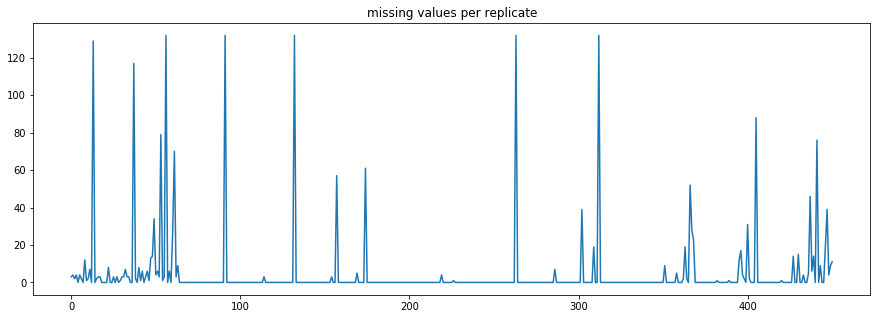

In [197]:
rcParams['figure.figsize'] = 15,5
plt.plot(df.isnull().sum(axis=1).values)
plt.title('missing values per replicate')
plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/missing_values_per_prot_1ions_12ppm.svg')

In [198]:
## how many are missing from more than half of the replicates?
((df.isnull().sum(axis=1).values)>66).sum()

11

In [199]:
## what measures are missing from more than half of the replicates?
df.index[(df.isnull().sum(axis=1).values)>66]

Index(['sp|Q8NB46|ANR52_HUMAN Serine/threonine-protein phosphatase 6 regulatory ankyrin repeat subunit C OS=Homo sapiens OX=9606 GN=ANKRD52 PE=1 SV=3',
       'sp|Q96RG2|PASK_HUMAN PAS domain-containing serine/threonine-protein kinase OS=Homo sapiens OX=9606 GN=PASK PE=1 SV=3',
       'sp|Q9NYV4|CDK12_HUMAN Cyclin-dependent kinase 12 OS=Homo sapiens OX=9606 GN=CDK12 PE=1 SV=2',
       'sp|Q9UL63|MKLN1_HUMAN Muskelin OS=Homo sapiens OX=9606 GN=MKLN1 PE=1 SV=2',
       'sp|P28482|MK01_HUMAN Mitogen-activated protein kinase 1 OS=Homo sapiens OX=9606 GN=MAPK1 PE=1 SV=3',
       'sp|P06733|ENOA_HUMAN Alpha-enolase OS=Homo sapiens OX=9606 GN=ENO1 PE=1 SV=2',
       'sp|Q9NVH2|INT7_HUMAN Integrator complex subunit 7 OS=Homo sapiens OX=9606 GN=INTS7 PE=1 SV=1',
       'sp|Q9NRF8|PYRG2_HUMAN CTP synthase 2 OS=Homo sapiens OX=9606 GN=CTPS2 PE=1 SV=1',
       'sp|Q96CW1|AP2M1_HUMAN AP-2 complex subunit mu OS=Homo sapiens OX=9606 GN=AP2M1 PE=1 SV=2',
       'sp|O60828|PQBP1_HUMAN Polyglutamine-bin

In [200]:
# what is the most proteins quantified in one sample
len(df) - df.isnull().sum(axis=0).min()

444

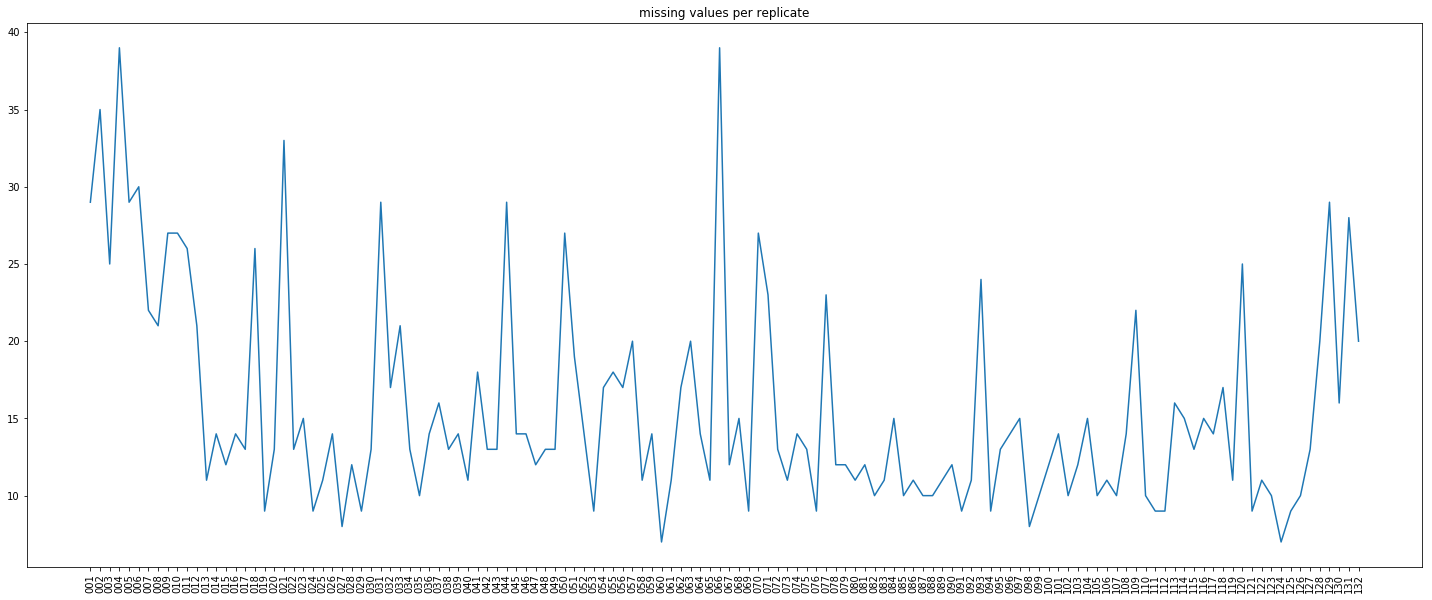

In [201]:
rcParams['figure.figsize'] = 25, 10
fig = plt.plot(df.isnull().sum(axis=0))
plt.xticks(rotation=90)
plt.title('missing values per replicate')
plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/missing_values_per_rep_req1ions_12ppm.svg')


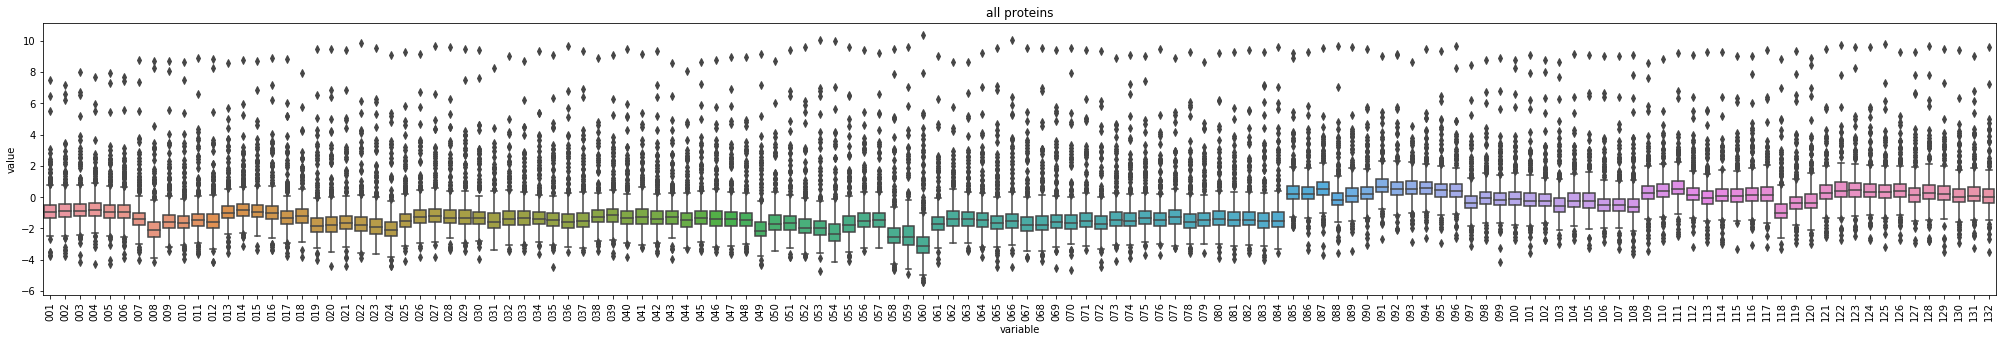

In [202]:
## use pd.melt to make long format 
rcParams['figure.figsize'] = 35, 5
seaplot = sns.boxplot(x="variable", y = "value", data = pd.melt(np.log2(1/df)))
seaplot.set_title('all proteins')
seaplot.set_xticklabels(seaplot.get_xticklabels(), rotation=90)
plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/all_proteins_req1ions_12ppm.svg')

In [203]:
df_complete = df.dropna()
len(df_complete)

359

In [204]:
## use pd.melt to make long format 
rcParams['figure.figsize'] = 35, 5
seaplot = sns.boxplot(x="variable", y = "value", data = pd.melt(np.log2(1/df_complete)))
seaplot.set_title('306 complete proteins, require 2ions')
seaplot.set_xticklabels(seaplot.get_xticklabels(), rotation=90)
plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/358complete_proteins_req1ions_12ppm.svg')

In [205]:
dfarray = np.asarray(np.log2(1/df))

In [206]:
# filter data to remove NAs
mask = ~np.isnan(dfarray)
mask
filtered_data = [d[m] for d, m in zip(dfarray, mask)]

In [208]:
### shows that the outlier proteins are #46, #73, #81  (because it is minus 1!!)
rcParams['figure.figsize'] = 55, 5
df_complete = df.dropna()
bp1 = plt.boxplot(filtered_data)
plt.xticks(rotation=90)
plt.hlines(2, 0, 451, colors='red')
plt.title('quant ratios by protein (220 complete)')
plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/any_protein_req1ions_12ppm.svg')

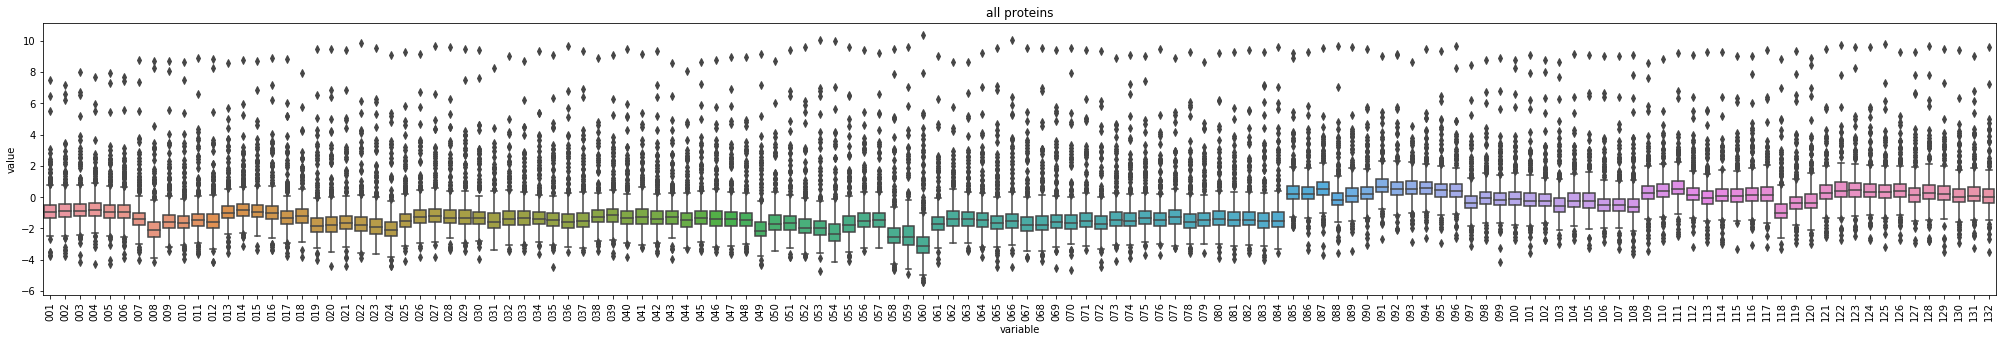

In [210]:
## use pd.melt to make long format 
rcParams['figure.figsize'] = 35, 5
seaplot = sns.boxplot(x="variable", y = "value", data = pd.melt(np.log2(1/df)))
seaplot.set_title('all proteins')
seaplot.set_xticklabels(seaplot.get_xticklabels(), rotation=90)
plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/all_proteins_req1ions_12ppm_dropoutliers.svg')

In [211]:
drop_these = df.index[np.where(np.abs(np.log2(1/df).median(1))>2)]

C:\Users\jesse\Anaconda3\envs\pyms\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [212]:
### programmatically find the proteins with median above or below a log2 ratio of 2, drop those from the dataframe
df.drop(drop_these, 0, inplace=True)

In [213]:
len(df)

431

In [214]:
df_complete = df.dropna()
len(df_complete)

341

In [272]:
df_complete.to_csv('341prot_dfcomplete_1ion12ppm.csv')

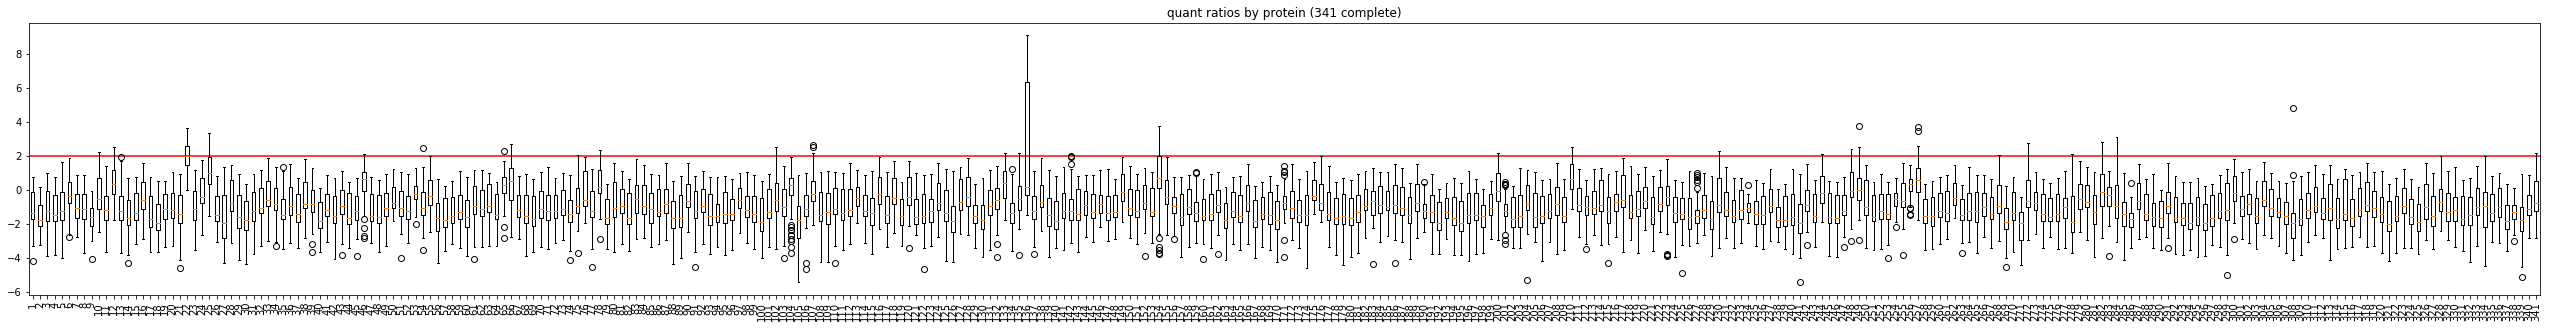

In [215]:
### shows that the outlier proteins are #46, #73, #81  (because it is minus 1!!)
rcParams['figure.figsize'] = 45, 5
bp1 = plt.boxplot(np.log2(1/df_complete))
plt.xticks(rotation=90)
plt.hlines(2, 0, 451, colors='red')
plt.title('quant ratios by protein (341 complete)')
plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/341complete_by_protein_req1ion.svg')

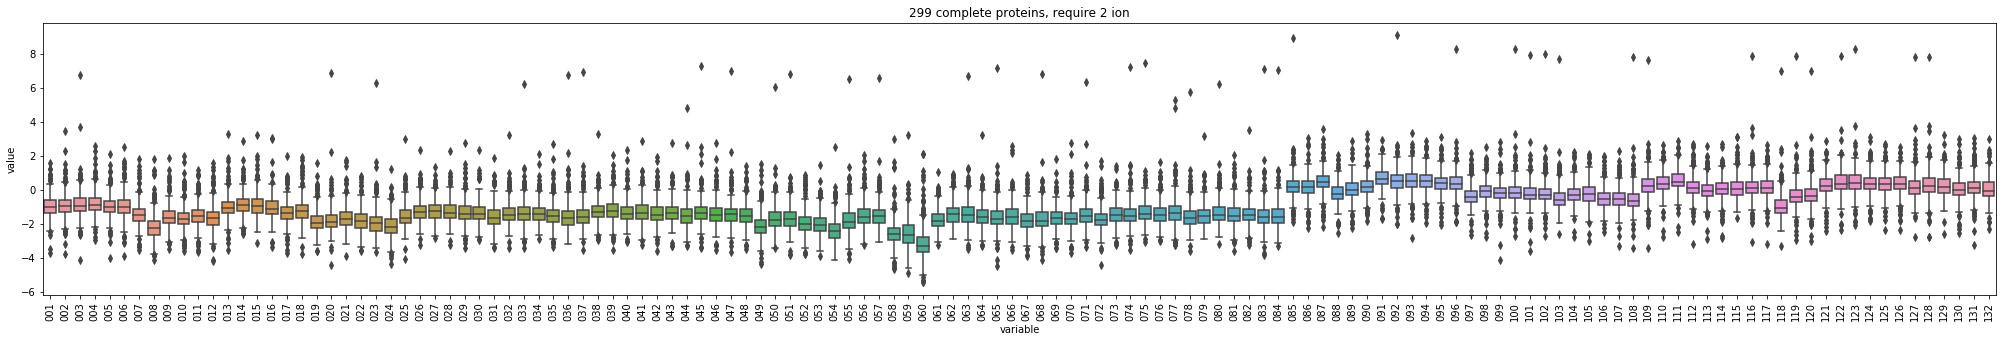

In [216]:
## use pd.melt to make long format 
rcParams['figure.figsize'] = 35, 5
seaplot = sns.boxplot(x="variable", y = "value", data = pd.melt(np.log2(1/df_complete)))
seaplot.set_title('299 complete proteins, require 2 ion')
seaplot.set_xticklabels(seaplot.get_xticklabels(), rotation=90)
plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/299complete_proteins_req1ions_12ppm.svg')

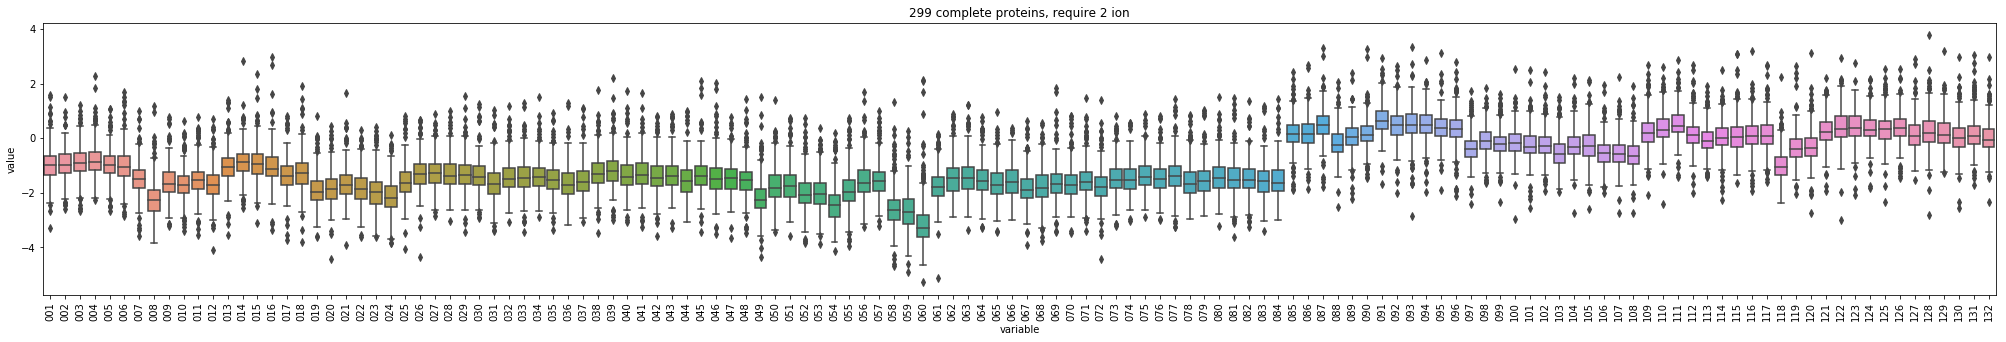

In [118]:
## use pd.melt to make long format 
rcParams['figure.figsize'] = 35, 5
seaplot = sns.boxplot(x="variable", y = "value", data = pd.melt(np.log2(1/df_complete)))
seaplot.set_title('299 complete proteins, require 2 ion')
seaplot.set_xticklabels(seaplot.get_xticklabels(), rotation=90)
plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/299complete_proteins_req1ions_12ppm.svg')

In [217]:
df.to_pickle('P:/JGM_DI2A/Python/outputs/mitotox3/mitotox3_1ions_12ppm.pickle')

In [218]:
rcParams['figure.figsize'] = 45, 5
bp1 = plt.boxplot(np.log2(1/df))
plt.xticks(rotation=90)
plt.hlines(2, 0, 451, colors='red')
plt.title('quant ratios by protein (all)')
plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/all_by_protein_req1ion12ppm.svg')

C:\Users\jesse\Anaconda3\envs\pyms\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\jesse\Anaconda3\envs\pyms\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
C:\Users\jesse\Anaconda3\envs\pyms\lib\site-packages\matplotlib\cbook\__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
C:\Users\jesse\Anaconda3\envs\pyms\lib\site-packages\matplotlib\cbook\__init__.py:1261: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
C:\Users\jesse\Anaconda3\envs\pyms\lib\site-packages\matplotlib\cbook\__init__.py:1262: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


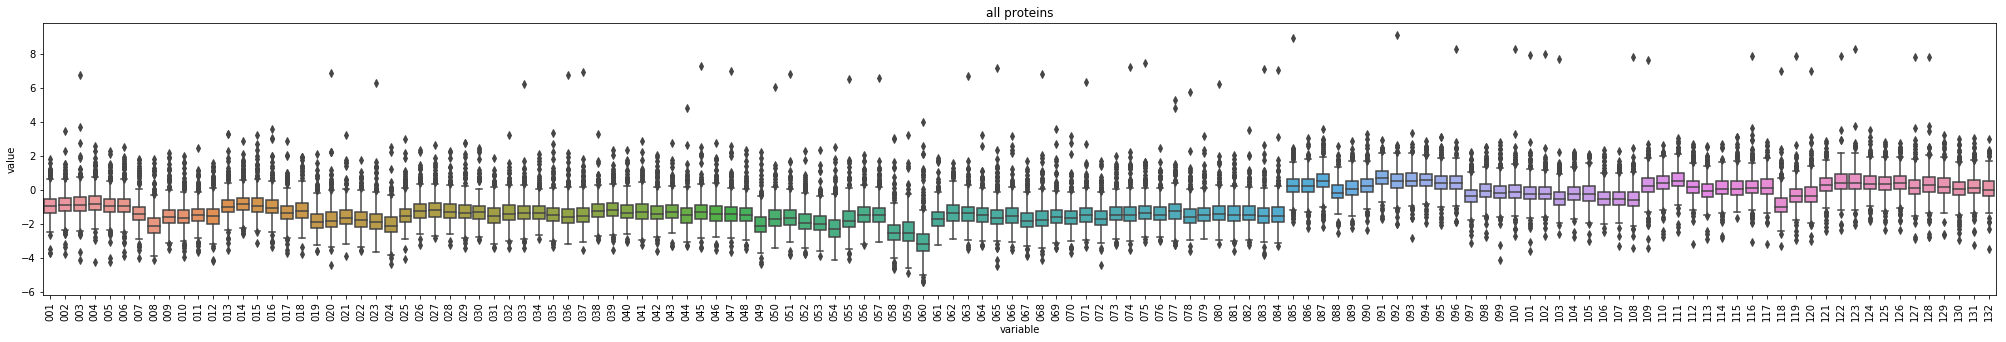

In [219]:
## use pd.melt to make long format 
rcParams['figure.figsize'] = 35, 5
seaplot = sns.boxplot(x="variable", y = "value", data = pd.melt(np.log2(1/df)))
seaplot.set_title('all proteins')
seaplot.set_xticklabels(seaplot.get_xticklabels(), rotation=90)
plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/all_proteins_req1ions12ppm.svg')

## Scale the proteins, then transpose for ANOVA

In [220]:
len(df)

431

In [221]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_std=False)
dft = np.log2(1/df)
scaled = scaler.fit_transform(dft)
dft_scale = pd.DataFrame(scaled , index=dft.index, columns=dft.columns)
dft_scale = dft_scale.T
dft = dft.T

In [222]:
dft_scale

Protein  sp|Q9UKK9|NUDT5_HUMAN ADP-sugar pyrophosphatase OS=Homo sapiens OX=9606 GN=NUDT5 PE=1 SV=1  \
001                                               0.106613                                            
002                                               0.132798                                            
003                                              -0.641658                                            
004                                              -0.052099                                            
005                                              -0.081599                                            
006                                               0.341561                                            
007                                              -0.327671                                            
008                                              -0.498469                                            
009                                              -0.040236                                            
010                                              -1.154510                                            
011                                              -0.052071                                            
012                                              -0.046428                                            
013                                              -0.054831                                            
014                                              -0.275885                                            
015                                               0.350701                                            
016                                               0.128089                                            
017                                               0.168032                                            
018                                              -0.568720                                            
019                                              -0.015074                                            
020                                              -0.722527                                            
021                                                    NaN                                            
022                                              -0.090867                                            
023                                               0.043621                                            
024                                               0.608082                                            
025                                              -0.060071                                            
026                                              -0.427355                                            
027                                               0.239225                                            
028                                              -0.333707                                            
029                                               0.535651                                            
030                                              -0.212870                                            
..                                                     ...                                            
103                                              -0.444020                                            
104                                              -0.366540                                            
105                                              -0.329282                                            
106                                              -0.778108                                            
107                                              -0.009615                                            
108                                              -0.577220                                            
109                                               0.134739                            

In [223]:
dft

Protein  sp|Q9UKK9|NUDT5_HUMAN ADP-sugar pyrophosphatase OS=Homo sapiens OX=9606 GN=NUDT5 PE=1 SV=1  \
001                                              -0.794228                                            
002                                              -0.723522                                            
003                                              -1.442085                                            
004                                              -0.791714                                            
005                                              -0.997785                                            
006                                              -0.557415                                            
007                                              -1.674447                                            
008                                              -2.521606                                            
009                                              -1.525449                                            
010                                              -2.715225                                            
011                                              -1.466529                                            
012                                              -1.534368                                            
013                                              -0.979904                                            
014                                              -1.040577                                            
015                                              -0.503600                                            
016                                              -0.823204                                            
017                                              -1.100283                                            
018                                              -1.720516                                            
019                                              -1.782792                                            
020                                              -2.411333                                            
021                                                    NaN                                            
022                                              -1.778194                                            
023                                              -1.727790                                            
024                                              -1.414570                                            
025                                              -1.506090                                            
026                                              -1.580569                                            
027                                              -0.897791                                            
028                                              -1.545456                                            
029                                              -0.694495                                            
030                                              -1.483921                                            
..                                                     ...                                            
103                                              -0.896234                                            
104                                              -0.538287                                            
105                                              -0.530684                                            
106                                              -1.247338                                            
107                                              -0.485577                                            
108                                              -1.085980                                            
109                                               0.421418                            

In [224]:
dfnp = dft.to_numpy()
dfnp_scale= dft_scale.to_numpy()

rcParams['figure.figsize'] = 15, 5
fig, [[ax1, ax2, ax3, ax4, ax5, ax6], [ax7, ax8, ax9, ax10, ax11, ax12]]= plt.subplots(2,6, sharex='all', sharey='all')
ax1.hist(dfnp.T[:,0], bins=25)
ax1.axvline(x=0, color='r')
ax2.hist(dfnp.T[:,1], bins=25)
ax2.axvline(x=0, color='r')
ax3.hist(dfnp.T[:,2], bins=25)
ax3.axvline(x=0, color='r')
ax4.hist(dfnp.T[:,3], bins=25)
ax4.axvline(x=0, color='r')
ax5.hist(dfnp.T[:,4], bins=25)
ax5.axvline(x=0, color='r')
ax6.hist(dfnp.T[:,5], bins=25)
ax6.axvline(x=0, color='r')
ax1.set_xlim(-6,6)


ax7.hist(dfnp_scale.T[:,0], bins=25)
ax7.axvline(x=0, color='r')
ax8.hist(dfnp_scale.T[:,1], bins=25)
ax8.axvline(x=0, color='r')
ax9.hist(dfnp_scale.T[:,2], bins=25)
ax9.axvline(x=0, color='r')
ax10.hist(dfnp_scale.T[:,3], bins=25)
ax10.axvline(x=0, color='r')
ax11.hist(dfnp_scale.T[:,4], bins=25)
ax11.axvline(x=0, color='r')
ax12.hist(dfnp_scale.T[:,5], bins=25)
ax12.axvline(x=0, color='r')
ax1.set_xlim(-6,6)

C:\Users\jesse\Anaconda3\envs\pyms\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jesse\Anaconda3\envs\pyms\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(-6, 6)

In [248]:
# read in grouping file
group_df = pd.read_csv("P:/JGM_DI2A/mitotox/20200110_mitotox_screen_sample_IDs.csv", sep=',')
group_df.index = dft.index
## replace complex protein names with simple text names for anova
prot_shortname = [str(x).split(' ')[0] for x in dft.columns.values]
prot_shortname = [x.split('|')[-1] for x in prot_shortname]
prot_longnames = dft_scale.columns.values
dft_scale.columns = prot_shortname
dft_scale.columns = 'x'+dft_scale.columns.values
dfmerge = group_df.merge(dft_scale, on=dft.index)
df6h = dfmerge[dfmerge['Control group']=='6 hr']
df24h = dfmerge[dfmerge['Control group']=='24h']
df24h.head()

key_0  Sample Cell line Genotype Media Compound concentration  \
84   085      85      293T       WT  DMEM     4-NB          1 mM   
85   086      86      293T       WT  DMEM     4-NB          1 mM   
86   087      87      293T       WT  DMEM     4-NB          1 mM   
87   088      88      293T       WT  HPLM     4-NB          1 mM   
88   089      89      293T       WT  HPLM     4-NB          1 mM   

   Treatment duration Control group  Replicate  ... xCX6B1_HUMAN  xTCTP_HUMAN  \
84              7 day           24h          1  ...     0.060563    -0.594394   
85              7 day           24h          2  ...     0.987311    -0.615167   
86              7 day           24h          3  ...     0.142307    -0.867102   
87              7 day           24h          1  ...     0.606894    -0.820729   
88              7 day           24h          2  ...    -0.077636    -0.619734   

    xMARE1_HUMAN  xRL30_HUMAN  xVDAC1_HUMAN  xFPPS_HUMAN  xTRAP1_HUMAN  \
84     -0.079220     0.015354     -0.208599     0.357648     -0.244762   
85     -1.319713     0.029817     -0.200257     0.702699      1.057101   
86     -0.147405    -2.349797     -0.518479     0.161465     -0.129915   
87           NaN    -0.045384      0.073957     0.674998      0.783918   
88           NaN     0.170500     -0.015437     0.470689      0.224004   

    xSYMC_HUMAN  xTXNL1_HUMAN  xRBM8A_HUMAN  
84     1.140630      1.692158      2.174907  
85     1.262653      1.380081      1.602328  
86     0.785918      1.034025      0.821583  
87     1.463818      0.389657      0.773647  
88     1.243243      0.227852      0.699431  

[5 rows x 442 columns]

In [249]:
#DIRECTORY = "P:/JGM_DI2A/MSDATA/20200217_FIDIA_mitotox3_targeted/"
PATH = 'P:/JGM_DI2A/Python/outputs/mitotox3/'

In [227]:
cls_list = dfmerge['class']

In [228]:
dfmerge['class']

0             WTDMEMCont.
1             WTDMEMCont.
2             WTDMEMCont.
3             WTHPLMCont.
4             WTHPLMCont.
5             WTHPLMCont.
6         ΔPPTC7DMEMCont.
7         ΔPPTC7DMEMCont.
8         ΔPPTC7DMEMCont.
9         ΔPPTC7HPLMCont.
10        ΔPPTC7HPLMCont.
11        ΔPPTC7HPLMCont.
12         WTDMEMantimycA
13         WTDMEMantimycA
14         WTDMEMantimycA
15         WTHPLMantimycA
16         WTHPLMantimycA
17         WTHPLMantimycA
18     ΔPPTC7DMEMantimycA
19     ΔPPTC7DMEMantimycA
20     ΔPPTC7DMEMantimycA
21     ΔPPTC7HPLMantimycA
22     ΔPPTC7HPLMantimycA
23     ΔPPTC7HPLMantimycA
24           WTDMEMroten.
25           WTDMEMroten.
26           WTDMEMroten.
27           WTHPLMroten.
28           WTHPLMroten.
29           WTHPLMroten.
              ...        
102         ΔPPTC7DMEMDFO
103         ΔPPTC7DMEMDFO
104         ΔPPTC7DMEMDFO
105         ΔPPTC7HPLMDFO
106         ΔPPTC7HPLMDFO
107         ΔPPTC7HPLMDFO
108          WTDMEMdoxycy
109         

In [250]:
print(PATH)
dfmerge.to_csv(PATH+'1ions12ppm_protein_quant_data_table.csv')

P:/JGM_DI2A/Python/outputs/mitotox3/


In [3]:
dfmerge  = pd.read_csv('P:/JGM_DI2A/Python/outputs/mitotox3/1ions12ppm_protein_quant_data_table.csv')

In [34]:
df6h = dfmerge[dfmerge['Control group']=='6 hr']
df24h = dfmerge[dfmerge['Control group']=='24h']
df24h.head()

Unnamed: 0  key_0  Sample Cell line Genotype Media Compound concentration  \
84          84     85      85      293T       WT  DMEM     4-NB          1 mM   
85          85     86      86      293T       WT  DMEM     4-NB          1 mM   
86          86     87      87      293T       WT  DMEM     4-NB          1 mM   
87          87     88      88      293T       WT  HPLM     4-NB          1 mM   
88          88     89      89      293T       WT  HPLM     4-NB          1 mM   

   Treatment duration Control group  ...  xCX6B1_HUMAN xTCTP_HUMAN  \
84              7 day           24h  ...      0.060563   -0.594394   
85              7 day           24h  ...      0.987311   -0.615167   
86              7 day           24h  ...      0.142307   -0.867102   
87              7 day           24h  ...      0.606894   -0.820729   
88              7 day           24h  ...     -0.077636   -0.619734   

    xMARE1_HUMAN  xRL30_HUMAN  xVDAC1_HUMAN  xFPPS_HUMAN  xTRAP1_HUMAN  \
84     -0.079220     0.015354     -0.208599     0.357648     -0.244762   
85     -1.319713     0.029817     -0.200257     0.702699      1.057101   
86     -0.147405    -2.349797     -0.518479     0.161465     -0.129915   
87           NaN    -0.045384      0.073957     0.674998      0.783918   
88           NaN     0.170500     -0.015437     0.470689      0.224004   

    xSYMC_HUMAN  xTXNL1_HUMAN  xRBM8A_HUMAN  
84     1.140630      1.692158      2.174907  
85     1.262653      1.380081      1.602328  
86     0.785918      1.034025      0.821583  
87     1.463818      0.389657      0.773647  
88     1.243243      0.227852      0.699431  

[5 rows x 443 columns]

In [35]:
df24h

Unnamed: 0  key_0  Sample Cell line Genotype Media Compound  \
84           84     85      85      293T       WT  DMEM     4-NB   
85           85     86      86      293T       WT  DMEM     4-NB   
86           86     87      87      293T       WT  DMEM     4-NB   
87           87     88      88      293T       WT  HPLM     4-NB   
88           88     89      89      293T       WT  HPLM     4-NB   
89           89     90      90      293T       WT  HPLM     4-NB   
90           90     91      91      293T   ΔPPTC7  DMEM     4-NB   
91           91     92      92      293T   ΔPPTC7  DMEM     4-NB   
92           92     93      93      293T   ΔPPTC7  DMEM     4-NB   
93           93     94      94      293T   ΔPPTC7  HPLM     4-NB   
94           94     95      95      293T   ΔPPTC7  HPLM     4-NB   
95           95     96      96      293T   ΔPPTC7  HPLM     4-NB   
96           96     97      97      293T       WT  DMEM      DFO   
97           97     98      98      293T       WT  DMEM      DFO   
98           98     99      99      293T       WT  DMEM      DFO   
99           99    100     100      293T       WT  HPLM      DFO   
100         100    101     101      293T       WT  HPLM      DFO   
101         101    102     102      293T       WT  HPLM      DFO   
102         102    103     103      293T   ΔPPTC7  DMEM      DFO   
103         103    104     104      293T   ΔPPTC7  DMEM      DFO   
104         104    105     105      293T   ΔPPTC7  DMEM      DFO   
105         105    106     106      293T   ΔPPTC7  HPLM      DFO   
106         106    107     107      293T   ΔPPTC7  HPLM      DFO   
107         107    108     108      293T   ΔPPTC7  HPLM      DFO   
108         108    109     109      293T       WT  DMEM   doxycy   
109         109    110     110      293T       WT  DMEM   doxycy   
110         110    111     111      293T       WT  DMEM   doxycy   
111         111    112     112      293T       WT  HPLM   doxycy   
112         112    113     113      293T       WT  HPLM   doxycy   
113         113    114     114      293T       WT  HPLM   doxycy   
114         114    115     115      293T   ΔPPTC7  DMEM   doxycy   
115         115    116     116      293T   ΔPPTC7  DMEM   doxycy   
116         116    117     117      293T   ΔPPTC7  DMEM   doxycy   
117         117    118     118      293T   ΔPPTC7  HPLM   doxycy   
118         118    119     119      293T   ΔPPTC7  HPLM   doxycy   
119         119    120     120      293T   ΔPPTC7  HPLM   doxycy   
120         120    121     121      293T       WT  DMEM    Cont.   
121         121    122     122      293T       WT  DMEM    Cont.   
122         122    123     123      293T       WT  DMEM    Cont.   
123         123    124     124      293T       WT  HPLM    Cont.   
124         124    125     125      293T       WT  HPLM    Cont.   
125         125    126     126      293T       WT  HPLM    Cont.   
126         126    127     127      293T   ΔPPTC7  DMEM    Cont.   
127         127    128     128      293T   ΔPPTC7  DMEM    Cont.   
128         128    129     129      293T   ΔPPTC7  DMEM    Cont.   
129         129    130     130      293T   ΔPPTC7  HPLM    Cont.   
130         130    131     131      293T   ΔPPTC7  HPLM    Cont.   
131         131    132     132      293T   ΔPPTC7  HPLM    Cont.   

    concentration Treatment duration Control group  ...  xCX6B1_HUMAN  \
84           1 mM              7 day           24h  ...      0.060563   
85           1 mM              7 day           24h  ...      0.987311   
86           1 mM              7 day           24h  ...      0.142307   
87           1 mM              7 day           24h  ...      0.606894   
88           1 mM              7 day           24h  ...     -0.077636   
89           1 mM              7 day           24h  ...      0.690461   
90           1 mM              7 day           24h  ...      0.252435   
91           1 mM              7 day           24h  ...     -1.564591   
92           1 

In [36]:
df24h.iloc[np.arange(-12, len(df24h)-12)]

Unnamed: 0  key_0  Sample Cell line Genotype Media Compound  \
120         120    121     121      293T       WT  DMEM    Cont.   
121         121    122     122      293T       WT  DMEM    Cont.   
122         122    123     123      293T       WT  DMEM    Cont.   
123         123    124     124      293T       WT  HPLM    Cont.   
124         124    125     125      293T       WT  HPLM    Cont.   
125         125    126     126      293T       WT  HPLM    Cont.   
126         126    127     127      293T   ΔPPTC7  DMEM    Cont.   
127         127    128     128      293T   ΔPPTC7  DMEM    Cont.   
128         128    129     129      293T   ΔPPTC7  DMEM    Cont.   
129         129    130     130      293T   ΔPPTC7  HPLM    Cont.   
130         130    131     131      293T   ΔPPTC7  HPLM    Cont.   
131         131    132     132      293T   ΔPPTC7  HPLM    Cont.   
84           84     85      85      293T       WT  DMEM     4-NB   
85           85     86      86      293T       WT  DMEM     4-NB   
86           86     87      87      293T       WT  DMEM     4-NB   
87           87     88      88      293T       WT  HPLM     4-NB   
88           88     89      89      293T       WT  HPLM     4-NB   
89           89     90      90      293T       WT  HPLM     4-NB   
90           90     91      91      293T   ΔPPTC7  DMEM     4-NB   
91           91     92      92      293T   ΔPPTC7  DMEM     4-NB   
92           92     93      93      293T   ΔPPTC7  DMEM     4-NB   
93           93     94      94      293T   ΔPPTC7  HPLM     4-NB   
94           94     95      95      293T   ΔPPTC7  HPLM     4-NB   
95           95     96      96      293T   ΔPPTC7  HPLM     4-NB   
96           96     97      97      293T       WT  DMEM      DFO   
97           97     98      98      293T       WT  DMEM      DFO   
98           98     99      99      293T       WT  DMEM      DFO   
99           99    100     100      293T       WT  HPLM      DFO   
100         100    101     101      293T       WT  HPLM      DFO   
101         101    102     102      293T       WT  HPLM      DFO   
102         102    103     103      293T   ΔPPTC7  DMEM      DFO   
103         103    104     104      293T   ΔPPTC7  DMEM      DFO   
104         104    105     105      293T   ΔPPTC7  DMEM      DFO   
105         105    106     106      293T   ΔPPTC7  HPLM      DFO   
106         106    107     107      293T   ΔPPTC7  HPLM      DFO   
107         107    108     108      293T   ΔPPTC7  HPLM      DFO   
108         108    109     109      293T       WT  DMEM   doxycy   
109         109    110     110      293T       WT  DMEM   doxycy   
110         110    111     111      293T       WT  DMEM   doxycy   
111         111    112     112      293T       WT  HPLM   doxycy   
112         112    113     113      293T       WT  HPLM   doxycy   
113         113    114     114      293T       WT  HPLM   doxycy   
114         114    115     115      293T   ΔPPTC7  DMEM   doxycy   
115         115    116     116      293T   ΔPPTC7  DMEM   doxycy   
116         116    117     117      293T   ΔPPTC7  DMEM   doxycy   
117         117    118     118      293T   ΔPPTC7  HPLM   doxycy   
118         118    119     119      293T   ΔPPTC7  HPLM   doxycy   
119         119    120     120      293T   ΔPPTC7  HPLM   doxycy   

    concentration Treatment duration Control group  ...  xCX6B1_HUMAN  \
120           NaN                NaN           24h  ...      0.528533   
121           NaN                NaN           24h  ...      0.715485   
122           NaN                NaN           24h  ...      0.306047   
123           NaN                NaN           24h  ...     -0.370782   
124           NaN                NaN           24h  ...     -0.125305   
125           NaN                NaN           24h  ...     -0.178226   
126           NaN                NaN           24h  ...     -0.257763   
127           NaN                NaN           24h  ...     -0.234528   
128           N

In [37]:
### flip so the controls are first
df24h = df24h.iloc[np.arange(-12, len(df24h)-12)]

In [38]:
df24h_hplm = df24h[df24h['Media']=='HPLM']
df24h_hplm

Unnamed: 0  key_0  Sample Cell line Genotype Media Compound  \
123         123    124     124      293T       WT  HPLM    Cont.   
124         124    125     125      293T       WT  HPLM    Cont.   
125         125    126     126      293T       WT  HPLM    Cont.   
129         129    130     130      293T   ΔPPTC7  HPLM    Cont.   
130         130    131     131      293T   ΔPPTC7  HPLM    Cont.   
131         131    132     132      293T   ΔPPTC7  HPLM    Cont.   
87           87     88      88      293T       WT  HPLM     4-NB   
88           88     89      89      293T       WT  HPLM     4-NB   
89           89     90      90      293T       WT  HPLM     4-NB   
93           93     94      94      293T   ΔPPTC7  HPLM     4-NB   
94           94     95      95      293T   ΔPPTC7  HPLM     4-NB   
95           95     96      96      293T   ΔPPTC7  HPLM     4-NB   
99           99    100     100      293T       WT  HPLM      DFO   
100         100    101     101      293T       WT  HPLM      DFO   
101         101    102     102      293T       WT  HPLM      DFO   
105         105    106     106      293T   ΔPPTC7  HPLM      DFO   
106         106    107     107      293T   ΔPPTC7  HPLM      DFO   
107         107    108     108      293T   ΔPPTC7  HPLM      DFO   
111         111    112     112      293T       WT  HPLM   doxycy   
112         112    113     113      293T       WT  HPLM   doxycy   
113         113    114     114      293T       WT  HPLM   doxycy   
117         117    118     118      293T   ΔPPTC7  HPLM   doxycy   
118         118    119     119      293T   ΔPPTC7  HPLM   doxycy   
119         119    120     120      293T   ΔPPTC7  HPLM   doxycy   

    concentration Treatment duration Control group  ...  xCX6B1_HUMAN  \
123           NaN                NaN           24h  ...     -0.370782   
124           NaN                NaN           24h  ...     -0.125305   
125           NaN                NaN           24h  ...     -0.178226   
129           NaN                NaN           24h  ...      0.531166   
130           NaN                NaN           24h  ...      0.671009   
131           NaN                NaN           24h  ...      0.944526   
87           1 mM              7 day           24h  ...      0.606894   
88           1 mM              7 day           24h  ...     -0.077636   
89           1 mM              7 day           24h  ...      0.690461   
93           1 mM              7 day           24h  ...      0.323987   
94           1 mM              7 day           24h  ...      0.293536   
95           1 mM              7 day           24h  ...     -0.954120   
99         500 µM              24 hr           24h  ...      0.164346   
100        500 µM              24 hr           24h  ...      0.802160   
101        500 µM              24 hr           24h  ...     -0.513450   
105        500 µM              24 hr           24h  ...     -0.661512   
106        500 µM              24 hr           24h  ...     -0.542533   
107        500 µM              24 hr           24h  ...     -0.486732   
111      10 mg/ml              24 hr           24h  ...      0.126622   
112      10 mg/ml              24 hr           24h  ...      0.021140   
113      10 mg/ml              24 hr           24h  ...     -0.289883   
117      10 mg/ml              24 hr           24h  ...     -0.122183   
118      10 mg/ml              24 hr           24h  ...      0.142645   
119      10 mg/ml              24 hr           24h  ...      0.285126   

    xTCTP_HUMAN  xMARE1_HUMAN  xRL30_HUMAN  xVDAC1_HUMAN  xFPPS_HUMAN  \
123   -1.150462     -0.230462     0.290555      0.643609     0.657810   
124   -1.605419     -0.930356     0.266336      0.651625     0.165131   
125   -2.228529     -0.965079     0.233550      0.219978     0.387392   
129   -0.812279           NaN     0.405382           NaN     0.493115   
130   -1.731888     -1.124590    -0.065060           NaN     1.569542   
131   -0.394250           NaN    -0.4856

In [40]:
df24h_dmem = df24h[df24h['Media']=='DMEM']
df24h_dmem 

Unnamed: 0  key_0  Sample Cell line Genotype Media Compound  \
120         120    121     121      293T       WT  DMEM    Cont.   
121         121    122     122      293T       WT  DMEM    Cont.   
122         122    123     123      293T       WT  DMEM    Cont.   
126         126    127     127      293T   ΔPPTC7  DMEM    Cont.   
127         127    128     128      293T   ΔPPTC7  DMEM    Cont.   
128         128    129     129      293T   ΔPPTC7  DMEM    Cont.   
84           84     85      85      293T       WT  DMEM     4-NB   
85           85     86      86      293T       WT  DMEM     4-NB   
86           86     87      87      293T       WT  DMEM     4-NB   
90           90     91      91      293T   ΔPPTC7  DMEM     4-NB   
91           91     92      92      293T   ΔPPTC7  DMEM     4-NB   
92           92     93      93      293T   ΔPPTC7  DMEM     4-NB   
96           96     97      97      293T       WT  DMEM      DFO   
97           97     98      98      293T       WT  DMEM      DFO   
98           98     99      99      293T       WT  DMEM      DFO   
102         102    103     103      293T   ΔPPTC7  DMEM      DFO   
103         103    104     104      293T   ΔPPTC7  DMEM      DFO   
104         104    105     105      293T   ΔPPTC7  DMEM      DFO   
108         108    109     109      293T       WT  DMEM   doxycy   
109         109    110     110      293T       WT  DMEM   doxycy   
110         110    111     111      293T       WT  DMEM   doxycy   
114         114    115     115      293T   ΔPPTC7  DMEM   doxycy   
115         115    116     116      293T   ΔPPTC7  DMEM   doxycy   
116         116    117     117      293T   ΔPPTC7  DMEM   doxycy   

    concentration Treatment duration Control group  ...  xCX6B1_HUMAN  \
120           NaN                NaN           24h  ...      0.528533   
121           NaN                NaN           24h  ...      0.715485   
122           NaN                NaN           24h  ...      0.306047   
126           NaN                NaN           24h  ...     -0.257763   
127           NaN                NaN           24h  ...     -0.234528   
128           NaN                NaN           24h  ...           NaN   
84           1 mM              7 day           24h  ...      0.060563   
85           1 mM              7 day           24h  ...      0.987311   
86           1 mM              7 day           24h  ...      0.142307   
90           1 mM              7 day           24h  ...      0.252435   
91           1 mM              7 day           24h  ...     -1.564591   
92           1 mM              7 day           24h  ...      0.056386   
96         500 µM              24 hr           24h  ...      0.217016   
97         500 µM              24 hr           24h  ...     -0.197127   
98         500 µM              24 hr           24h  ...     -1.067849   
102        500 µM              24 hr           24h  ...     -0.801285   
103        500 µM              24 hr           24h  ...      1.013842   
104        500 µM              24 hr           24h  ...     -1.136468   
108      10 mg/ml              24 hr           24h  ...     -1.193673   
109      10 mg/ml              24 hr           24h  ...      0.365123   
110      10 mg/ml              24 hr           24h  ...     -0.443540   
114      10 mg/ml              24 hr           24h  ...      0.284393   
115      10 mg/ml              24 hr           24h  ...     -0.662928   
116      10 mg/ml              24 hr           24h  ...     -0.683526   

    xTCTP_HUMAN  xMARE1_HUMAN  xRL30_HUMAN  xVDAC1_HUMAN  xFPPS_HUMAN  \
120   -2.771957     -1.086510     0.169076     -0.179975     0.312132   
121   -1.900754     -0.847982     0.404003      0.061364     0.186507   
122   -1.688388           NaN     0.216812     -0.198187     0.060393   
126   -0.335124           NaN     0.191379     -1.123947     1.296818   
127    0.594124           NaN     0.256228           NaN     0.073738   
128   -0.384607     -1.250446     0.0111

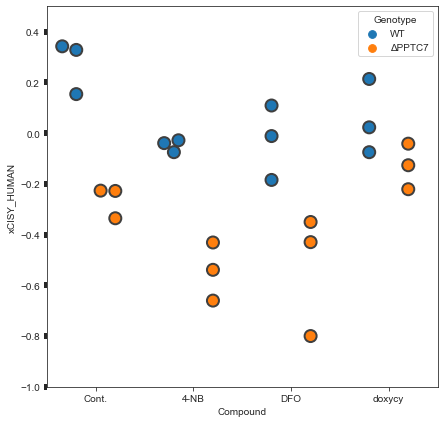

In [87]:
plt.rcParams['figure.figsize'] = 7,7
sns.set_style("ticks")
sns.set_context(font_scale= 12, rc={"ytick.major.width":6})

g = sns.swarmplot(x='Compound', y='xCISY_HUMAN', hue='Genotype', 
        data=df24h_dmem, dodge=True, size=12, linewidth=2)
g.set(ylim=(-1,0.5))
plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/Fig4D_CISY_HUMAN_DMEM_pts.svg')

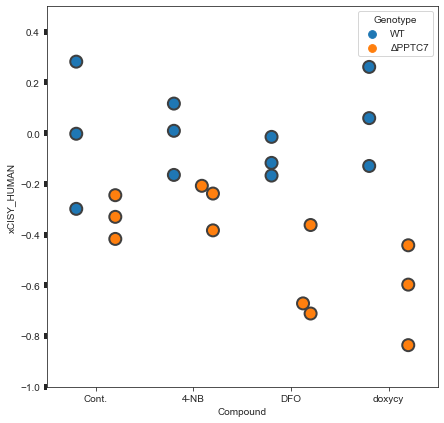

In [89]:
plt.rcParams['figure.figsize'] = 7,7
g = sns.swarmplot(x='Compound', y='xCISY_HUMAN', hue='Genotype', 
        data=df24h_hplm, dodge=True, size=12,  linewidth=2)
g.set(ylim=(-1,0.5))
plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/Fig4D_CISY_HUMAN_HPLM_pts.svg')

In [54]:
g = sns.catplot(x='Compound', y='xCISY_HUMAN', hue='Genotype', 
        height=6, aspect=.75,
        data=df24h_dmem, kind="box", dodge=True)
sns.stripplot(x='Compound', y='xCISY_HUMAN', hue='Genotype', 
        data=df24h_dmem, ax=g.ax, dodge=True, linewidth=1, marker='x',size=12, color='k')

g.set_xticklabels(rotation=90, fontsize=16)
g.set_yticklabels(fontsize=16)

g.fig.subplots_adjust(top=0.8)
g.axes.flat[0].set_ylabel('log2(ratio)', fontsize=16)
g.fig.suptitle('Citrate Synthase', fontsize=24)
#plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/Fig4D_CISY_HUMAN.svg')

Text(0.5, 0.98, 'Citrate Synthase')

Text(0.5, 0.98, 'Citrate Synthase')

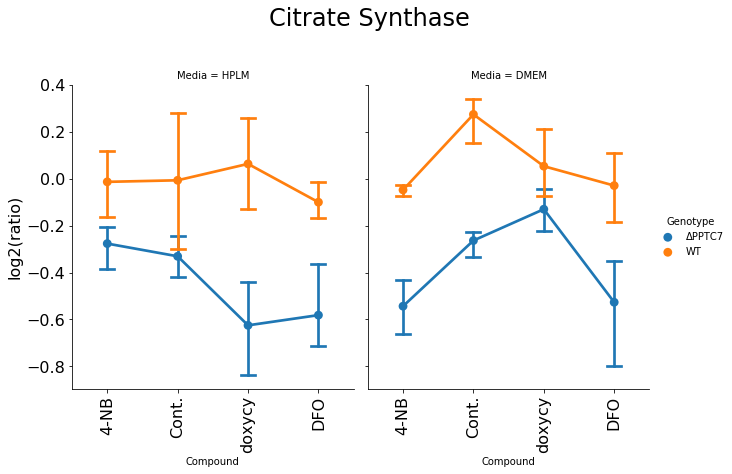

In [10]:
g = sns.catplot(x='Compound', y='xCISY_HUMAN', hue='Genotype', col='Media',
        capsize=.2, height=6, aspect=.75,
        kind="point", data=df24h, rotation=90)
g.set_xticklabels(rotation=90, fontsize=16)
g.set_yticklabels(fontsize=16)

g.fig.subplots_adjust(top=0.8)
g.axes.flat[0].set_ylabel('log2(ratio)', fontsize=16)
g.fig.suptitle('Citrate Synthase', fontsize=24)
#plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/Fig4D_CISY_HUMAN.svg')

In [279]:
filter_col = [col for col in df24h if col.startswith('x')]
filter_col = ['class']+filter_col
#filter_col

In [280]:
df24h_filter = df24h[filter_col]
#df24h_filter['class']

In [281]:
na_counts_24h = df24h_filter.drop('class',1).isna().groupby(df24h_filter['class'], sort=False).sum().reset_index()

In [282]:
na_counts_24h

class  xNUDT5_HUMAN  xRPN1_HUMAN  xPEBP1_HUMAN  xLBR_HUMAN  \
0         WTDMEM4-NB           0.0          0.0           0.0         0.0   
1         WTHPLM4-NB           0.0          0.0           0.0         0.0   
2     ΔPPTC7DMEM4-NB           0.0          0.0           0.0         0.0   
3     ΔPPTC7HPLM4-NB           1.0          0.0           0.0         1.0   
4          WTDMEMDFO           0.0          0.0           0.0         0.0   
5          WTHPLMDFO           0.0          0.0           0.0         0.0   
6      ΔPPTC7DMEMDFO           0.0          0.0           0.0         0.0   
7      ΔPPTC7HPLMDFO           0.0          0.0           0.0         0.0   
8       WTDMEMdoxycy           0.0          0.0           0.0         0.0   
9       WTHPLMdoxycy           0.0          0.0           0.0         0.0   
10  ΔPPTC7DMEMdoxycy           0.0          0.0           0.0         0.0   
11  ΔPPTC7HPLMdoxycy           0.0          0.0           0.0         0.0   
12       WTDMEMCont.           0.0          0.0           0.0         0.0   
13       WTHPLMCont.           0.0          0.0           0.0         0.0   
14   ΔPPTC7DMEMCont.           0.0          0.0           0.0         0.0   
15   ΔPPTC7HPLMCont.           0.0          0.0           0.0         0.0   

    xACTB_HUMAN  xCOPZ1_HUMAN  xPSB3_HUMAN  xACTG_HUMAN  xG3BP1_HUMAN  ...  \
0           0.0           0.0          0.0          0.0           0.0  ...   
1           0.0           0.0          0.0          0.0           0.0  ...   
2           0.0           0.0          0.0          0.0           0.0  ...   
3           0.0           0.0          0.0          0.0           0.0  ...   
4           0.0           0.0          0.0          0.0           0.0  ...   
5           0.0           0.0          0.0          0.0           0.0  ...   
6           0.0           0.0          0.0          0.0           0.0  ...   
7           0.0           0.0          0.0          0.0           0.0  ...   
8           0.0           0.0          0.0          0.0           0.0  ...   
9           0.0           0.0          0.0          0.0           0.0  ...   
10          0.0           0.0          0.0          0.0           0.0  ...   
11          0.0           0.0          0.0          0.0           0.0  ...   
12          0.0           0.0          0.0          0.0           0.0  ...   
13          0.0           0.0          0.0          0.0           0.0  ...   
14          0.0           1.0          0.0          0.0           0.0  ...   
15          0.0           0.0          0.0          0.0           0.0  ...   

    xCX6B1_HUMAN  xTCTP_HUMAN  xMARE1_HUMAN  xRL30_HUMAN  xVDAC1_HUMAN  \
0            0.0          0.0           0.0          0.0           0.0   
1            0.0          0.0           2.0          0.0           0.0   
2            0.0          0.0           3.0          0.0           0.0   
3            0.0          0.0           1.0          0.0           0.0   
4            0.0          0.0           0.0          0.0           0.0   
5            0.0          0.0           1.0          0.0           0.0   
6            0.0          0.0           1.0          0.0           0.0   
7            0.0          0.0           1.0          0.0           0.0   
8            0.0          0.0           1.0          0.0           1.0   
9            0.0          0.0           2.0          0.0           0.0   
10           0.0          0.0           2.0          0.0           0.0   
11           0.0          0.0           2.0          0.0           1.0   
12           0.0          0.0           1.0          0.0           0.0   
13           0.0          0.0           0.0          0.0           0.0   
14           1.0          0.0           2.0          0.0           2.0   
15           0.0          0.0           2.0          0.0           3.0   

    xFPPS_HUMAN  xTRAP1_HUMAN  xSYMC_HUMAN  xTXNL1_HUMAN  xRBM8A_HUMAN  
0           0.0           0.0          0.0    

In [257]:
prot_names_24h_atleast1 = na_counts_24h.max().drop('class',0).index[na_counts_24h.max().drop('class',0)<3]
len(prot_names_24h_atleast1)

411

In [258]:
prot_names_24h_atleast2 = na_counts_24h.max().drop('class',0).index[na_counts_24h.max().drop('class',0)<2]
len(prot_names_24h_atleast2)

401

In [259]:
prot_names_24h_atleast3 = na_counts_24h.max().drop('class',0).index[na_counts_24h.max().drop('class',0)<1]
len(prot_names_24h_atleast3)

380

In [260]:
np.arange(-12, len(df24h))

array([-12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,
         1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47])

In [261]:
### flip so the controls are first
#df24h = df24h.reindex(index=df24h.index[::-1])
df24h = df24h.iloc[np.arange(-12, len(df24h)-12)]

In [262]:
complete_proteins = df_complete.index.values

In [263]:
df24h.head()

key_0  Sample Cell line Genotype Media Compound concentration  \
120   121     121      293T       WT  DMEM    Cont.           NaN   
121   122     122      293T       WT  DMEM    Cont.           NaN   
122   123     123      293T       WT  DMEM    Cont.           NaN   
123   124     124      293T       WT  HPLM    Cont.           NaN   
124   125     125      293T       WT  HPLM    Cont.           NaN   

    Treatment duration Control group  Replicate  ... xCX6B1_HUMAN  \
120                NaN           24h          1  ...     0.528533   
121                NaN           24h          2  ...     0.715485   
122                NaN           24h          3  ...     0.306047   
123                NaN           24h          1  ...    -0.370782   
124                NaN           24h          2  ...    -0.125305   

     xTCTP_HUMAN  xMARE1_HUMAN  xRL30_HUMAN  xVDAC1_HUMAN  xFPPS_HUMAN  \
120    -2.771957     -1.086510     0.169076     -0.179975     0.312132   
121    -1.900754     -0.847982     0.404003      0.061364     0.186507   
122    -1.688388           NaN     0.216812     -0.198187     0.060393   
123    -1.150462     -0.230462     0.290555      0.643609     0.657810   
124    -1.605419     -0.930356     0.266336      0.651625     0.165131   

     xTRAP1_HUMAN  xSYMC_HUMAN  xTXNL1_HUMAN  xRBM8A_HUMAN  
120      0.266178     0.334158      1.643952      0.899950  
121     -0.106812     1.136734      0.731259      0.557152  
122     -0.368995     0.210262      1.291711      0.923583  
123      0.034320     1.400018      1.154660      0.531752  
124     -0.344968     0.795924      1.603670      0.757229  

[5 rows x 442 columns]

In [264]:
### now do loops through all those and post-hoc testing for differences!!!
pvals = []
PATH='P:/JGM_DI2A/Python/outputs/mitotox3/24h_1ion12ppm_2reps/'
for x in prot_names_24h_atleast2:
    print(x)
    model = ols(x +'~ C(Genotype)*C(Media)*C(Compound)', df24h).fit()
    pvals.append(model.f_pvalue)
    table = sm.stats.anova_lm(model, typ=2)
    table.to_csv(PATH+ x+'.csv')  ### write table of ANOVA results
    print(table)
    g = sns.catplot(x='Compound', y=x, hue='Genotype', col='Media',
            capsize=.2, height=6, aspect=.75,
            kind="point", data=df24h, rotation=90)
    g.set_xticklabels(rotation=90)
    g.fig.subplots_adjust(top=0.8)
    g.axes.flat[0].set_ylabel('log2(light/heavy)', fontsize=16)
    g.fig.suptitle(x+ ', OLS f_pval = '+str(np.round(model.f_pvalue, 4)), fontsize=24)
    plt.savefig(PATH + x  + '.png')
    plt.clf()

xNUDT5_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.224069   1.0  1.595460  0.215966
C(Media)                          0.294981   1.0  2.100381  0.157304
C(Compound)                       1.144627   3.0  2.716731  0.061572
C(Genotype):C(Media)              0.106626   1.0  0.759222  0.390270
C(Genotype):C(Compound)           0.610644   3.0  1.449342  0.247460
C(Media):C(Compound)              0.308391   3.0  0.731956  0.540835
C(Genotype):C(Media):C(Compound)  0.456653   3.0  1.083849  0.370410
Residual                          4.353693  31.0       NaN       NaN
xRPN1_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.001074   1.0  0.002700  0.958880
C(Media)                           0.002605   1.0  0.006548  0.936011
C(Compound)                        1.097412   3.0  0.919342  0.442593
C(Genotype):C(Media)               0.495135   1.0  1.244379  0.272936
C(Ge

xPTMA_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.006818   1.0  0.482488  0.492311
C(Media)                          0.013116   1.0  0.928218  0.342551
C(Compound)                       0.411531   3.0  9.707732  0.000105
C(Genotype):C(Media)              0.000097   1.0  0.006890  0.934364
C(Genotype):C(Compound)           0.166675   3.0  3.931745  0.017002
C(Media):C(Compound)              0.025247   3.0  0.595552  0.622525
C(Genotype):C(Media):C(Compound)  0.016849   3.0  0.397459  0.755715
Residual                          0.452183  32.0       NaN       NaN
xECHM_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       5.591261   1.0  23.480542  0.000031
C(Media)                          0.225508   1.0   0.947023  0.337778
C(Compound)                       0.710313   3.0   0.994322  0.407992
C(Genotype):C(Media)              0.749326   1.0   3.146801  0.085593
C(Gen

C:\Users\jesse\Anaconda3\envs\pyms\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


xHNRDL_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.529503   1.0  3.312551  0.078118
C(Media)                          0.011513   1.0  0.072028  0.790129
C(Compound)                       0.587847   3.0  1.225850  0.316335
C(Genotype):C(Media)              0.233506   1.0  1.460807  0.235657
C(Genotype):C(Compound)           0.231816   3.0  0.483411  0.696157
C(Media):C(Compound)              0.077559   3.0  0.161735  0.921305
C(Genotype):C(Media):C(Compound)  0.440470   3.0  0.918521  0.442986
Residual                          5.115116  32.0       NaN       NaN
xCOX5A_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       1.185822   1.0  6.576816  0.015227
C(Media)                          0.149315   1.0  0.828133  0.369617
C(Compound)                       2.825409   3.0  5.223434  0.004758
C(Genotype):C(Media)              0.028154   1.0  0.156148  0.695350
C(Genoty

xNASP_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.056345   1.0  1.153054  0.290942
C(Media)                          0.037805   1.0  0.773641  0.385651
C(Compound)                       0.887961   3.0  6.057139  0.002188
C(Genotype):C(Media)              0.021775   1.0  0.445615  0.509210
C(Genotype):C(Compound)           0.283017   3.0  1.930574  0.144476
C(Media):C(Compound)              0.196895   3.0  1.343101  0.277776
C(Genotype):C(Media):C(Compound)  0.393483   3.0  2.684106  0.063176
Residual                          1.563706  32.0       NaN       NaN
xPRS6A_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.172661   1.0  0.647913  0.426800
C(Media)                          0.370901   1.0  1.391813  0.246796
C(Compound)                       1.747161   3.0  2.185415  0.108975
C(Genotype):C(Media)              0.822667   1.0  3.087068  0.088483
C(Genotyp

xERF3A_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.363829   1.0  1.371570  0.250189
C(Media)                          0.017180   1.0  0.064766  0.800744
C(Compound)                       0.486551   3.0  0.611403  0.612555
C(Genotype):C(Media)              1.998230   1.0  7.532974  0.009850
C(Genotype):C(Compound)           0.902256   3.0  1.133782  0.350172
C(Media):C(Compound)              1.329377   3.0  1.670506  0.192937
C(Genotype):C(Media):C(Compound)  1.066728   3.0  1.340458  0.278593
Residual                          8.488464  32.0       NaN       NaN
xACO13_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       1.802656   1.0  11.502174  0.001865
C(Media)                          0.091613   1.0   0.584554  0.450134
C(Compound)                       3.572089   3.0   7.597456  0.000567
C(Genotype):C(Media)              1.019013   1.0   6.502000  0.015765
C(G

x1433B_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.177011   1.0   2.391024  0.131867
C(Media)                          0.784501   1.0  10.596868  0.002678
C(Compound)                       1.028630   3.0   4.631502  0.008437
C(Genotype):C(Media)              0.034175   1.0   0.461624  0.501751
C(Genotype):C(Compound)           0.770891   3.0   3.471011  0.027352
C(Media):C(Compound)              0.194280   3.0   0.874762  0.464391
C(Genotype):C(Media):C(Compound)  0.112243   3.0   0.505384  0.681327
Residual                          2.369005  32.0        NaN       NaN
xRS7_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.017246   1.0  0.676999  0.416711
C(Media)                          0.205378   1.0  8.062022  0.007791
C(Compound)                       0.530310   3.0  6.939036  0.000997
C(Genotype):C(Media)              0.012431   1.0  0.487966  0.489882
C

xMDHM_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       2.165618   1.0  38.772062  5.639670e-07
C(Media)                          0.022964   1.0   0.411141  5.259569e-01
C(Compound)                       1.279501   3.0   7.635832  5.493348e-04
C(Genotype):C(Media)              0.014361   1.0   0.257116  6.155850e-01
C(Genotype):C(Compound)           0.028098   3.0   0.167687  9.173871e-01
C(Media):C(Compound)              0.264288   3.0   1.577224  2.140643e-01
C(Genotype):C(Media):C(Compound)  0.053574   3.0   0.319717  8.110264e-01
Residual                          1.787364  32.0        NaN           NaN
xPRDX1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000740   1.0  0.017062  0.896891
C(Media)                          0.033192   1.0  0.765738  0.388060
C(Compound)                       0.521589   3.0  4.011014  0.015685
C(Genotype):C(Media)             

xTCPB_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.118799   1.0  3.275920  0.079704
C(Media)                          0.029962   1.0  0.826219  0.370163
C(Compound)                       0.607850   3.0  5.587193  0.003376
C(Genotype):C(Media)              0.017219   1.0  0.474815  0.495747
C(Genotype):C(Compound)           0.083794   3.0  0.770214  0.519213
C(Media):C(Compound)              0.229981   3.0  2.113926  0.117924
C(Genotype):C(Media):C(Compound)  0.173392   3.0  1.593769  0.210155
Residual                          1.160463  32.0       NaN       NaN
xRL14_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.318548   1.0  17.377905  0.000218
C(Media)                          0.006964   1.0   0.379899  0.542018
C(Compound)                       0.683260   3.0  12.424722  0.000015
C(Genotype):C(Media)              0.002244   1.0   0.122427  0.728709
C(Gen

xRACK1_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.043828   1.0   1.637169  0.209914
C(Media)                          0.202788   1.0   7.574960  0.009667
C(Compound)                       1.238705   3.0  15.423548  0.000002
C(Genotype):C(Media)              0.004150   1.0   0.155003  0.696410
C(Genotype):C(Compound)           0.167245   3.0   2.082426  0.122102
C(Media):C(Compound)              0.282056   3.0   3.511977  0.026208
C(Genotype):C(Media):C(Compound)  0.011296   3.0   0.140652  0.934892
Residual                          0.856667  32.0        NaN       NaN
xG3P_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.011326   1.0   2.592559  1.171887e-01
C(Media)                          0.107101   1.0  24.515791  2.288934e-05
C(Compound)                       0.763267   3.0  58.238359  4.642293e-13
C(Genotype):C(Media)              0.005505   1.0  

xCOF1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.220479   1.0  5.124441  0.030507
C(Media)                          0.011389   1.0  0.264697  0.610447
C(Compound)                       1.058531   3.0  8.200906  0.000344
C(Genotype):C(Media)              0.011539   1.0  0.268189  0.608112
C(Genotype):C(Compound)           0.129548   3.0  1.003666  0.403857
C(Media):C(Compound)              0.053983   3.0  0.418229  0.741126
C(Genotype):C(Media):C(Compound)  0.197751   3.0  1.532063  0.225108
Residual                          1.376799  32.0       NaN       NaN
xRS24_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.208250   1.0  2.297549  0.139395
C(Media)                          0.060166   1.0  0.663792  0.421247
C(Compound)                       1.012156   3.0  3.722255  0.021076
C(Genotype):C(Media)              0.100680   1.0  1.110763  0.299809
C(Genotype

xDDX21_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       1.469844   1.0   9.538428  0.004139
C(Media)                          0.025676   1.0   0.166624  0.685849
C(Compound)                       4.640232   3.0  10.037467  0.000082
C(Genotype):C(Media)              0.014573   1.0   0.094572  0.760436
C(Genotype):C(Compound)           1.638497   3.0   3.544297  0.025341
C(Media):C(Compound)              0.654979   3.0   1.416810  0.255925
C(Genotype):C(Media):C(Compound)  0.154813   3.0   0.334883  0.800183
Residual                          4.931106  32.0        NaN       NaN
xPSB5_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.108998   1.0  1.035494  0.316504
C(Media)                          0.131762   1.0  1.251759  0.271545
C(Compound)                       0.529765   3.0  1.677614  0.191416
C(Genotype):C(Media)              0.060769   1.0  0.577318  0.452927


xDHB4_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.053517   1.0  1.441396  0.238726
C(Media)                          0.020465   1.0  0.551182  0.463250
C(Compound)                       0.413370   3.0  3.711172  0.021318
C(Genotype):C(Media)              0.004827   1.0  0.129995  0.720806
C(Genotype):C(Compound)           0.154912   3.0  1.390772  0.263444
C(Media):C(Compound)              0.175448   3.0  1.575146  0.214561
C(Genotype):C(Media):C(Compound)  0.088731   3.0  0.796617  0.504872
Residual                          1.188109  32.0       NaN       NaN
xTCPG_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.078915   1.0  4.450573  0.042802
C(Media)                          0.058112   1.0  3.277312  0.079643
C(Compound)                       0.360600   3.0  6.778902  0.001147
C(Genotype):C(Media)              0.018135   1.0  1.022780  0.319447
C(Genotype

xGSTP1_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.471418   1.0  18.887611  1.312945e-04
C(Media)                          0.003286   1.0   0.131663  7.191001e-01
C(Compound)                       2.443171   3.0  32.628996  7.456496e-10
C(Genotype):C(Media)              0.049223   1.0   1.972131  1.698540e-01
C(Genotype):C(Compound)           0.142948   3.0   1.909100  1.479620e-01
C(Media):C(Compound)              0.095571   3.0   1.276363  2.991261e-01
C(Genotype):C(Media):C(Compound)  0.067144   3.0   0.896726  4.535355e-01
Residual                          0.798691  32.0        NaN           NaN
xPSDE_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.057645   1.0  1.061085  0.310691
C(Media)                          0.227836   1.0  4.193840  0.048852
C(Compound)                       0.398877   3.0  2.447408  0.081732
C(Genotype):C(Media)             

xSYDC_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.047205   1.0  0.570824  0.455457
C(Media)                          0.090776   1.0  1.097710  0.302618
C(Compound)                       0.637586   3.0  2.570018  0.071503
C(Genotype):C(Media)              0.065020   1.0  0.786263  0.381848
C(Genotype):C(Compound)           0.244057   3.0  0.983761  0.412712
C(Media):C(Compound)              0.158337   3.0  0.638233  0.595944
C(Genotype):C(Media):C(Compound)  0.207056   3.0  0.834614  0.484824
Residual                          2.646252  32.0       NaN       NaN
xATPO_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.554351   1.0  7.662139  0.009298
C(Media)                          0.420333   1.0  5.809766  0.021859
C(Compound)                       0.226860   3.0  1.045207  0.385937
C(Genotype):C(Media)              0.001291   1.0  0.017848  0.894557
C(Genotype

xPSMD1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.003235   1.0  0.023163  0.879991
C(Media)                          0.080355   1.0  0.575264  0.453725
C(Compound)                       0.110902   3.0  0.264652  0.850342
C(Genotype):C(Media)              0.014954   1.0  0.107058  0.745650
C(Genotype):C(Compound)           0.523239   3.0  1.248633  0.308458
C(Media):C(Compound)              0.194838   3.0  0.464952  0.708751
C(Genotype):C(Media):C(Compound)  0.562888   3.0  1.343248  0.277730
Residual                          4.469861  32.0       NaN       NaN
xGSTO1_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.000441   1.0  0.001114  0.973576
C(Media)                           0.211885   1.0  0.535897  0.469466
C(Compound)                        0.346733   3.0  0.292317  0.830621
C(Genotype):C(Media)               0.051388   1.0  0.129969  0.720833
C(G

xKCRB_HUMAN
                                    sum_sq    df           F        PR(>F)
C(Genotype)                       0.391616   1.0   50.146158  4.946871e-08
C(Media)                          0.028496   1.0    3.648938  6.510191e-02
C(Compound)                       3.480260   3.0  148.548404  7.363017e-19
C(Genotype):C(Media)              0.000151   1.0    0.019331  8.902926e-01
C(Genotype):C(Compound)           0.048688   3.0    2.078137  1.226829e-01
C(Media):C(Compound)              0.058102   3.0    2.479982  7.887506e-02
C(Genotype):C(Media):C(Compound)  0.028692   3.0    1.224651  3.167547e-01
Residual                          0.249904  32.0         NaN           NaN
xLDHB_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.195745   1.0  11.011023  0.002267
C(Media)                          0.019146   1.0   1.076979  0.307153
C(Compound)                       0.070285   3.0   1.317889  0.285661
C(Genotype):C(Media) 

xIF4A1_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.031675   1.0   1.130434  2.956407e-01
C(Media)                          0.637643   1.0  22.756375  3.869029e-05
C(Compound)                       1.519053   3.0  18.070804  4.834959e-07
C(Genotype):C(Media)              0.001967   1.0   0.070205  7.927374e-01
C(Genotype):C(Compound)           0.170024   3.0   2.022621  1.304581e-01
C(Media):C(Compound)              0.080611   3.0   0.958962  4.239919e-01
C(Genotype):C(Media):C(Compound)  0.129228   3.0   1.537315  2.237955e-01
Residual                          0.896653  32.0        NaN           NaN
xHNRPM_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.037847   1.0  0.806008  0.376009
C(Media)                          0.000995   1.0  0.021188  0.885181
C(Compound)                       0.097207   3.0  0.690050  0.564820
C(Genotype):C(Media)            

xRS25_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.124501   1.0   9.301186  0.004573
C(Media)                          0.014419   1.0   1.077234  0.307097
C(Compound)                       0.437623   3.0  10.897943  0.000043
C(Genotype):C(Media)              0.018864   1.0   1.409311  0.243909
C(Genotype):C(Compound)           0.035233   3.0   0.877395  0.463078
C(Media):C(Compound)              0.083498   3.0   2.079319  0.122523
C(Genotype):C(Media):C(Compound)  0.008395   3.0   0.209047  0.889384
Residual                          0.428335  32.0        NaN       NaN
xRL32_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.085123   1.0  0.473628  0.496282
C(Media)                          0.011421   1.0  0.063549  0.802583
C(Compound)                       2.155323   3.0  3.997435  0.015902
C(Genotype):C(Media)              0.118817   1.0  0.661104  0.422179
C

xCDC37_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.208864   1.0  5.006722  0.032339
C(Media)                          0.014595   1.0  0.349870  0.558342
C(Compound)                       0.163160   3.0  1.303714  0.290190
C(Genotype):C(Media)              0.021038   1.0  0.504307  0.482757
C(Genotype):C(Compound)           0.314669   3.0  2.514337  0.075974
C(Media):C(Compound)              0.013138   3.0  0.104979  0.956565
C(Genotype):C(Media):C(Compound)  0.073511   3.0  0.587380  0.627709
Residual                          1.334934  32.0       NaN       NaN
xILF3_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.195266   1.0  5.922490  0.020712
C(Media)                          0.025317   1.0  0.767860  0.387411
C(Compound)                       0.212219   3.0  2.145555  0.113875
C(Genotype):C(Media)              0.000517   1.0  0.015685  0.901117
C(Genotyp

xMCES_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.003342   1.0  0.010849  0.917692
C(Media)                          0.045612   1.0  0.148076  0.702927
C(Compound)                       0.363162   3.0  0.392992  0.758867
C(Genotype):C(Media)              0.675349   1.0  2.192467  0.148467
C(Genotype):C(Compound)           0.470250   3.0  0.508876  0.678987
C(Media):C(Compound)              1.753107   3.0  1.897108  0.149946
C(Genotype):C(Media):C(Compound)  0.852909   3.0  0.922967  0.440861
Residual                          9.857008  32.0       NaN       NaN
xCLH1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.035626   1.0  0.984502  0.328534
C(Media)                          0.008599   1.0  0.237614  0.629258
C(Compound)                       0.242059   3.0  2.229687  0.103786
C(Genotype):C(Media)              0.047504   1.0  1.312717  0.260400
C(Genotype

xENPL_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.286005   1.0  14.072619  0.000700
C(Media)                          0.030740   1.0   1.512520  0.227720
C(Compound)                       0.795297   3.0  13.043966  0.000010
C(Genotype):C(Media)              0.065215   1.0   3.208844  0.082704
C(Genotype):C(Compound)           0.033057   3.0   0.542185  0.656913
C(Media):C(Compound)              0.046231   3.0   0.758248  0.525823
C(Genotype):C(Media):C(Compound)  0.139416   3.0   2.286609  0.097486
Residual                          0.650352  32.0        NaN       NaN
xSPEE_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       7.032100   1.0  51.829017  3.555469e-08
C(Media)                          0.049396   1.0   0.364066  5.505100e-01
C(Compound)                       1.007180   3.0   2.474423  7.935521e-02
C(Genotype):C(Media)              0.010295   1.0  

xPSA1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.071061   1.0  0.624817  0.435082
C(Media)                          0.017378   1.0  0.152797  0.698467
C(Compound)                       3.027219   3.0  8.872478  0.000200
C(Genotype):C(Media)              0.037667   1.0  0.331197  0.568980
C(Genotype):C(Compound)           0.556903   3.0  1.632229  0.201341
C(Media):C(Compound)              0.500673   3.0  1.467422  0.241909
C(Genotype):C(Media):C(Compound)  0.722159   3.0  2.116576  0.117579
Residual                          3.639382  32.0       NaN       NaN
xRSSA_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.449961   1.0  0.502954  0.483340
C(Media)                           0.028530   1.0  0.031890  0.859394
C(Compound)                        2.568851   3.0  0.957132  0.424835
C(Genotype):C(Media)               0.634464   1.0  0.709188  0.405964
C(Gen

xIDE_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.048669   1.0  0.903789  0.348893
C(Media)                          0.217227   1.0  4.033952  0.053095
C(Compound)                       0.820568   3.0  5.079376  0.005461
C(Genotype):C(Media)              0.020641   1.0  0.383303  0.540224
C(Genotype):C(Compound)           0.185982   3.0  1.151243  0.343501
C(Media):C(Compound)              0.007494   3.0  0.046390  0.986498
C(Genotype):C(Media):C(Compound)  0.010854   3.0  0.067189  0.976936
Residual                          1.723189  32.0       NaN       NaN
xSFXN1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.171537   1.0  3.103808  0.087662
C(Media)                          0.003401   1.0  0.061545  0.805656
C(Compound)                       0.524834   3.0  3.165473  0.037719
C(Genotype):C(Media)              0.056887   1.0  1.029325  0.317927
C(Genotype

xPTBP1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.057081   1.0  2.229196  0.145219
C(Media)                          0.009876   1.0  0.385685  0.538975
C(Compound)                       0.104094   3.0  1.355054  0.274112
C(Genotype):C(Media)              0.001485   1.0  0.057992  0.811234
C(Genotype):C(Compound)           0.023579   3.0  0.306942  0.820165
C(Media):C(Compound)              0.032391   3.0  0.421648  0.738735
C(Genotype):C(Media):C(Compound)  0.079121   3.0  1.029972  0.392422
Residual                          0.819402  32.0       NaN       NaN
xUTS2_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.418667   1.0  17.999477  1.763409e-04
C(Media)                          0.064883   1.0   2.789466  1.046405e-01
C(Compound)                       2.045059   3.0  29.307325  2.640488e-09
C(Genotype):C(Media)              0.005644   1.0   0.24266

xPCBP1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000075   1.0  0.002969  0.956883
C(Media)                          0.095382   1.0  3.799577  0.060076
C(Compound)                       0.406434   3.0  5.396804  0.004037
C(Genotype):C(Media)              0.015621   1.0  0.622263  0.436013
C(Genotype):C(Compound)           0.064936   3.0  0.862253  0.470676
C(Media):C(Compound)              0.016613   3.0  0.220589  0.881380
C(Genotype):C(Media):C(Compound)  0.177316   3.0  2.354471  0.090486
Residual                          0.803308  32.0       NaN       NaN
xC1TC_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.208096   1.0  4.848104  0.035003
C(Media)                          0.012996   1.0  0.302772  0.585970
C(Compound)                       0.828518   3.0  6.434119  0.001557
C(Genotype):C(Media)              0.003408   1.0  0.079389  0.779941
C(Genotyp

xPRS7_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.012866   1.0  0.028147  0.867891
C(Media)                           0.003363   1.0  0.007358  0.932214
C(Compound)                        1.046754   3.0  0.763292  0.523579
C(Genotype):C(Media)               0.021465   1.0  0.046956  0.829914
C(Genotype):C(Compound)            0.826682   3.0  0.602816  0.618257
C(Media):C(Compound)               1.837336   3.0  1.339785  0.280035
C(Genotype):C(Media):C(Compound)   2.131832   3.0  1.554531  0.220907
Residual                          13.713668  30.0       NaN       NaN
xRS23_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.040398   1.0  0.061715  0.805393
C(Media)                           1.970684   1.0  3.010589  0.092345
C(Compound)                        8.097859   3.0  4.123665  0.013994
C(Genotype):C(Media)               2.087672   1.0  3.189310  0.083

xBUB3_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000053   1.0  0.000961  0.975467
C(Media)                          0.398334   1.0  7.219200  0.011344
C(Compound)                       0.279242   3.0  1.686948  0.189436
C(Genotype):C(Media)              0.000291   1.0  0.005280  0.942524
C(Genotype):C(Compound)           0.038042   3.0  0.229818  0.874935
C(Media):C(Compound)              0.050427   3.0  0.304640  0.821812
C(Genotype):C(Media):C(Compound)  0.606850   3.0  3.666080  0.022334
Residual                          1.765664  32.0       NaN       NaN
xHS90B_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.173924   1.0  12.292712  0.001370
C(Media)                          0.026808   1.0   1.894784  0.178219
C(Compound)                       0.200293   3.0   4.718822  0.007745
C(Genotype):C(Media)              0.023952   1.0   1.692893  0.202511
C(Ge

xRS16_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.108356   1.0  2.248222  0.143570
C(Media)                          0.183370   1.0  3.804648  0.059915
C(Compound)                       0.216948   3.0  1.500444  0.233177
C(Genotype):C(Media)              0.316575   1.0  6.568435  0.015286
C(Genotype):C(Compound)           0.627358   3.0  4.338901  0.011274
C(Media):C(Compound)              0.321369   3.0  2.222634  0.104596
C(Genotype):C(Media):C(Compound)  0.108392   3.0  0.749652  0.530614
Residual                          1.542283  32.0       NaN       NaN
xVINC_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        3.030785   1.0  7.852683  0.008544
C(Media)                           1.070859   1.0  2.774567  0.105534
C(Compound)                        2.104166   3.0  1.817280  0.163857
C(Genotype):C(Media)               0.070374   1.0  0.182336  0.672232
C(Gen

xNP1L1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.050016   1.0  0.517916  0.476956
C(Media)                          0.339248   1.0  3.512940  0.070046
C(Compound)                       0.204116   3.0  0.704548  0.556342
C(Genotype):C(Media)              0.127020   1.0  1.315304  0.259940
C(Genotype):C(Compound)           0.587481   3.0  2.027807  0.129711
C(Media):C(Compound)              0.676735   3.0  2.335885  0.092350
C(Genotype):C(Media):C(Compound)  0.136453   3.0  0.470995  0.704614
Residual                          3.090267  32.0       NaN       NaN
xLKHA4_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.145653   1.0  1.323184  0.258545
C(Media)                          0.006729   1.0  0.061125  0.806306
C(Compound)                       1.769596   3.0  5.358621  0.004185
C(Genotype):C(Media)              0.134309   1.0  1.220124  0.277573
C(Genoty

xTHIL_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.803911   1.0  47.059347  9.235541e-08
C(Media)                          0.190176   1.0  11.132496  2.159317e-03
C(Compound)                       0.937420   3.0  18.291562  4.286529e-07
C(Genotype):C(Media)              0.019280   1.0   1.128615  2.960230e-01
C(Genotype):C(Compound)           0.017484   3.0   0.341157  7.957010e-01
C(Media):C(Compound)              0.036996   3.0   0.721896  5.463302e-01
C(Genotype):C(Media):C(Compound)  0.009311   3.0   0.181674  9.080562e-01
Residual                          0.546654  32.0        NaN           NaN
xSAE2_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.001490   1.0  0.035987  0.850740
C(Media)                          0.007716   1.0  0.186357  0.668861
C(Compound)                       0.753190   3.0  6.063502  0.002175
C(Genotype):C(Media)              

xRBMX_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       1.060641   1.0  4.404759  0.044360
C(Media)                          0.217920   1.0  0.905006  0.349045
C(Compound)                       2.997216   3.0  4.149067  0.014241
C(Genotype):C(Media)              0.054621   1.0  0.226839  0.637328
C(Genotype):C(Compound)           1.950611   3.0  2.700244  0.063303
C(Media):C(Compound)              0.518382   3.0  0.717600  0.549279
C(Genotype):C(Media):C(Compound)  1.882343   3.0  2.605742  0.070041
Residual                          7.223830  30.0       NaN       NaN
xPPAC_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.011207   1.0   0.205215  0.653601
C(Media)                          0.131506   1.0   2.408039  0.130549
C(Compound)                       1.802935   3.0  11.004675  0.000040
C(Genotype):C(Media)              0.002537   1.0   0.046451  0.830726
C(Gen

xFPPS_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.483172   1.0  3.568112  0.067991
C(Media)                          0.009200   1.0  0.067940  0.796030
C(Compound)                       1.159522   3.0  2.854266  0.052580
C(Genotype):C(Media)              0.206964   1.0  1.528377  0.225354
C(Genotype):C(Compound)           0.350172   3.0  0.861980  0.470813
C(Media):C(Compound)              0.303882   3.0  0.748032  0.531521
C(Genotype):C(Media):C(Compound)  0.238253   3.0  0.586480  0.628282
Residual                          4.333245  32.0       NaN       NaN
xTXNL1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.256794   1.0  1.739760  0.196531
C(Media)                          0.201375   1.0  1.364301  0.251423
C(Compound)                       1.488415   3.0  3.361299  0.030681
C(Genotype):C(Media)              0.000594   1.0  0.004023  0.949824
C(Genotyp

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

In [265]:
### now do loops through all those and post-hoc testing for differences!!!
pvals24h = []
PATH='P:/JGM_DI2A/Python/outputs/mitotox3/24h_1ion12ppm_1rep/'
for x in prot_names_24h_atleast1:
    print(x)
    model = ols(x +'~ C(Genotype)*C(Media)*C(Compound)', df24h).fit()
    pvals24h.append(model.f_pvalue)
    table = sm.stats.anova_lm(model, typ=2)
    table.to_csv(PATH+ x+'.csv')  ### write table of ANOVA results
    print(table)
    g = sns.catplot(x='Compound', y=x, hue='Genotype', col='Media',
            capsize=.2, height=6, aspect=.75,
            kind="point", data=df24h, rotation=90)
    g.set_xticklabels(rotation=90)
    g.fig.subplots_adjust(top=0.8)
    g.axes.flat[0].set_ylabel('log2(light/heavy)', fontsize=16)
    g.fig.suptitle(x+', OLS f_pval = '+str(np.round(model.f_pvalue, 4)), fontsize=24)
    plt.savefig(PATH + x  + '.png')
    plt.clf()

xNUDT5_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.224069   1.0  1.595460  0.215966
C(Media)                          0.294981   1.0  2.100381  0.157304
C(Compound)                       1.144627   3.0  2.716731  0.061572
C(Genotype):C(Media)              0.106626   1.0  0.759222  0.390270
C(Genotype):C(Compound)           0.610644   3.0  1.449342  0.247460
C(Media):C(Compound)              0.308391   3.0  0.731956  0.540835
C(Genotype):C(Media):C(Compound)  0.456653   3.0  1.083849  0.370410
Residual                          4.353693  31.0       NaN       NaN
xRPN1_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.001074   1.0  0.002700  0.958880
C(Media)                           0.002605   1.0  0.006548  0.936011
C(Compound)                        1.097412   3.0  0.919342  0.442593
C(Genotype):C(Media)               0.495135   1.0  1.244379  0.272936
C(Ge

xPTMA_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.006818   1.0  0.482488  0.492311
C(Media)                          0.013116   1.0  0.928218  0.342551
C(Compound)                       0.411531   3.0  9.707732  0.000105
C(Genotype):C(Media)              0.000097   1.0  0.006890  0.934364
C(Genotype):C(Compound)           0.166675   3.0  3.931745  0.017002
C(Media):C(Compound)              0.025247   3.0  0.595552  0.622525
C(Genotype):C(Media):C(Compound)  0.016849   3.0  0.397459  0.755715
Residual                          0.452183  32.0       NaN       NaN
xECHM_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       5.591261   1.0  23.480542  0.000031
C(Media)                          0.225508   1.0   0.947023  0.337778
C(Compound)                       0.710313   3.0   0.994322  0.407992
C(Genotype):C(Media)              0.749326   1.0   3.146801  0.085593
C(Gen

xEXOS4_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        1.148673   1.0  2.953074  0.095377
C(Media)                           0.253059   1.0  0.650580  0.425860
C(Compound)                        0.438746   3.0  0.375984  0.770903
C(Genotype):C(Media)               0.077773   1.0  0.199944  0.657778
C(Genotype):C(Compound)            1.080489   3.0  0.925928  0.439451
C(Media):C(Compound)               0.122399   3.0  0.104890  0.956616
C(Genotype):C(Media):C(Compound)   1.087597   3.0  0.932019  0.436563
Residual                          12.447206  32.0       NaN       NaN
xWBP11_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.276278   1.0   1.751429  0.195075
C(Media)                          4.317777   1.0  27.371963  0.000010
C(Compound)                       0.936082   3.0   1.978055  0.137063
C(Genotype):C(Media)              0.631298   1.0   4.002028  0.0

xMCM6_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.325903   1.0  0.572090  0.454962
C(Media)                           0.099648   1.0  0.174923  0.678567
C(Compound)                        3.193639   3.0  1.868704  0.154753
C(Genotype):C(Media)               0.031903   1.0  0.056002  0.814439
C(Genotype):C(Compound)            1.929534   3.0  1.129034  0.352008
C(Media):C(Compound)               1.678028   3.0  0.981870  0.413562
C(Genotype):C(Media):C(Compound)   2.598883   3.0  1.520693  0.227977
Residual                          18.229469  32.0       NaN       NaN
xPSMD2_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        1.570841   1.0  4.774083  0.036327
C(Media)                           1.561144   1.0  4.744613  0.036870
C(Compound)                        1.901897   3.0  1.926742  0.145092
C(Genotype):C(Media)               0.119732   1.0  0.363888  0.55

xPABP2_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.157670   1.0  1.218247  0.278199
C(Media)                          0.043128   1.0  0.333235  0.567930
C(Compound)                       1.613230   3.0  4.154918  0.013848
C(Genotype):C(Media)              0.140056   1.0  1.082151  0.306263
C(Genotype):C(Compound)           0.960457   3.0  2.473682  0.080055
C(Media):C(Compound)              0.775949   3.0  1.998477  0.134688
C(Genotype):C(Media):C(Compound)  0.575539   3.0  1.482316  0.238574
Residual                          4.012125  31.0       NaN       NaN
xP5CR2_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.053005   1.0  0.522515  0.475021
C(Media)                          0.204641   1.0  2.017317  0.165184
C(Compound)                       0.901881   3.0  2.963529  0.046767
C(Genotype):C(Media)              0.006846   1.0  0.067490  0.796691
C(Genoty

xICLN_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.132841   1.0  0.685712  0.413760
C(Media)                          0.004546   1.0  0.023464  0.879219
C(Compound)                       0.039832   3.0  0.068537  0.976269
C(Genotype):C(Media)              0.038989   1.0  0.201256  0.656732
C(Genotype):C(Compound)           0.073246   3.0  0.126029  0.944004
C(Media):C(Compound)              0.822069   3.0  1.414483  0.256588
C(Genotype):C(Media):C(Compound)  0.283935   3.0  0.488549  0.692673
Residual                          6.199249  32.0       NaN       NaN
xHSP7C_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.000754   1.0   0.025251  8.747428e-01
C(Media)                          0.097960   1.0   3.281248  7.947142e-02
C(Compound)                       2.310839   3.0  25.801205  1.128327e-08
C(Genotype):C(Media)              0.000160   1.0   0.00536

xMIF_HUMAN
                                    sum_sq    df           F        PR(>F)
C(Genotype)                       0.053928   1.0   11.676015  1.741565e-03
C(Media)                          0.008859   1.0    1.918059  1.756512e-01
C(Compound)                       4.321356   3.0  311.874244  9.305139e-24
C(Genotype):C(Media)              0.006839   1.0    1.480639  2.325732e-01
C(Genotype):C(Compound)           0.004566   3.0    0.329564  8.039847e-01
C(Media):C(Compound)              0.079852   3.0    5.762969  2.866910e-03
C(Genotype):C(Media):C(Compound)  0.004615   3.0    0.333032  8.015053e-01
Residual                          0.147798  32.0         NaN           NaN
xPFD2_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.157799   1.0   2.278017  0.141031
C(Media)                          0.007941   1.0   0.114633  0.737141
C(Compound)                       2.914348   3.0  14.024021  0.000005
C(Genotype):C(Media)  

xRL27_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.538594   1.0  8.744707  0.005793
C(Media)                          0.110304   1.0  1.790909  0.190247
C(Compound)                       0.436371   3.0  2.361664  0.089775
C(Genotype):C(Media)              0.000264   1.0  0.004290  0.948184
C(Genotype):C(Compound)           0.017339   3.0  0.093841  0.962896
C(Media):C(Compound)              0.190462   3.0  1.030793  0.392070
C(Genotype):C(Media):C(Compound)  0.296530   3.0  1.604834  0.207580
Residual                          1.970909  32.0       NaN       NaN
xROA2_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.030093   1.0  0.284248  0.597614
C(Media)                          0.074175   1.0  0.700625  0.408782
C(Compound)                       0.177292   3.0  0.558207  0.646459
C(Genotype):C(Media)              0.104479   1.0  0.986869  0.327962
C(Genotype

xHNRPC_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.090678   1.0  13.647269  0.000820
C(Media)                          0.007054   1.0   1.061600  0.310576
C(Compound)                       0.037848   3.0   1.898727  0.149676
C(Genotype):C(Media)              0.007633   1.0   1.148808  0.291816
C(Genotype):C(Compound)           0.047174   3.0   2.366601  0.089291
C(Media):C(Compound)              0.021525   3.0   1.079850  0.371560
C(Genotype):C(Media):C(Compound)  0.016224   3.0   0.813910  0.495662
Residual                          0.212621  32.0        NaN       NaN
xPUR9_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.000049   1.0   0.000317  0.985899
C(Media)                          1.257532   1.0   8.105365  0.007645
C(Compound)                       0.214314   3.0   0.460449  0.711840
C(Genotype):C(Media)              1.737008   1.0  11.195808  0.00

xPARP1_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       1.520037   1.0  41.055801  3.354029e-07
C(Media)                          0.027977   1.0   0.755662  3.911633e-01
C(Compound)                       5.095871   3.0  45.879388  1.076609e-11
C(Genotype):C(Media)              0.047639   1.0   1.286717  2.650801e-01
C(Genotype):C(Compound)           0.012636   3.0   0.113761  9.514122e-01
C(Media):C(Compound)              0.097573   3.0   0.878473  4.625410e-01
C(Genotype):C(Media):C(Compound)  0.138833   3.0   1.249946  3.080097e-01
Residual                          1.184758  32.0        NaN           NaN
xFKB1A_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.050107   1.0   1.026635  0.318551
C(Media)                          0.085685   1.0   1.755593  0.194559
C(Compound)                       2.116263   3.0  14.453233  0.000004
C(Genotype):C(Media)        

xRS17_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000129   1.0  0.001238  0.972156
C(Media)                          0.260549   1.0  2.507282  0.123156
C(Compound)                       0.829630   3.0  2.661192  0.064764
C(Genotype):C(Media)              0.186828   1.0  1.797860  0.189412
C(Genotype):C(Compound)           0.461388   3.0  1.479986  0.238549
C(Media):C(Compound)              0.524031   3.0  1.680928  0.190711
C(Genotype):C(Media):C(Compound)  0.151914   3.0  0.487291  0.693525
Residual                          3.325348  32.0       NaN       NaN
xRL23_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.338495   1.0  2.247875  0.143600
C(Media)                          0.403784   1.0  2.681443  0.111322
C(Compound)                       1.687424   3.0  3.735273  0.020795
C(Genotype):C(Media)              0.030090   1.0  0.199822  0.657876
C(Genotype

xDDX5_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.497010   1.0   2.317593  0.137740
C(Media)                          0.143429   1.0   0.668822  0.419511
C(Compound)                       8.244518   3.0  12.814932  0.000011
C(Genotype):C(Media)              0.358022   1.0   1.669485  0.205581
C(Genotype):C(Compound)           1.636549   3.0   2.543784  0.073575
C(Media):C(Compound)              0.344323   3.0   0.535200  0.661504
C(Genotype):C(Media):C(Compound)  0.247100   3.0   0.384081  0.765166
Residual                          6.862426  32.0        NaN       NaN
xEF1D_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.768101   1.0  9.733570  0.003816
C(Media)                          0.059412   1.0  0.752886  0.392025
C(Compound)                       0.150866   3.0  0.637272  0.596533
C(Genotype):C(Media)              0.012267   1.0  0.155448  0.695998
C

xRL37A_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.067491   1.0  2.129695  0.154217
C(Media)                          0.068923   1.0  2.174905  0.150050
C(Compound)                       0.709117   3.0  7.458811  0.000638
C(Genotype):C(Media)              0.050300   1.0  1.587221  0.216835
C(Genotype):C(Compound)           0.128270   3.0  1.349200  0.275901
C(Media):C(Compound)              0.057328   3.0  0.603005  0.617823
C(Genotype):C(Media):C(Compound)  0.008397   3.0  0.088321  0.965941
Residual                          1.014091  32.0       NaN       NaN
xPRS4_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       1.306197   1.0  7.897006  0.008379
C(Media)                          0.003792   1.0  0.022928  0.880595
C(Compound)                       2.502671   3.0  5.043547  0.005652
C(Genotype):C(Media)              0.016616   1.0  0.100457  0.753340
C(Genotyp

xATPO_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.554351   1.0  7.662139  0.009298
C(Media)                          0.420333   1.0  5.809766  0.021859
C(Compound)                       0.226860   3.0  1.045207  0.385937
C(Genotype):C(Media)              0.001291   1.0  0.017848  0.894557
C(Genotype):C(Compound)           0.101056   3.0  0.465592  0.708312
C(Media):C(Compound)              0.264246   3.0  1.217451  0.319287
C(Genotype):C(Media):C(Compound)  0.074726   3.0  0.344283  0.793469
Residual                          2.315182  32.0       NaN       NaN
xDYHC1_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.017624   1.0  0.031182  0.860948
C(Media)                           0.562804   1.0  0.995785  0.325819
C(Compound)                        5.791993   3.0  3.415979  0.028972
C(Genotype):C(Media)               0.259701   1.0  0.459496  0.502732
C(Ge

xGSTO1_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.000441   1.0  0.001114  0.973576
C(Media)                           0.211885   1.0  0.535897  0.469466
C(Compound)                        0.346733   3.0  0.292317  0.830621
C(Genotype):C(Media)               0.051388   1.0  0.129969  0.720833
C(Genotype):C(Compound)            2.250901   3.0  1.897650  0.149855
C(Media):C(Compound)               0.414613   3.0  0.349544  0.789715
C(Genotype):C(Media):C(Compound)   0.165599   3.0  0.139611  0.935551
Residual                          12.652286  32.0       NaN       NaN
xPA1B3_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       1.374015   1.0  10.623128  0.002649
C(Media)                          0.073487   1.0   0.568160  0.456502
C(Compound)                       5.261177   3.0  13.558844  0.000007
C(Genotype):C(Media)              0.001339   1.0   0.010356  0.9

xLDHB_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.195745   1.0  11.011023  0.002267
C(Media)                          0.019146   1.0   1.076979  0.307153
C(Compound)                       0.070285   3.0   1.317889  0.285661
C(Genotype):C(Media)              0.006851   1.0   0.385391  0.539129
C(Genotype):C(Compound)           0.017302   3.0   0.324422  0.807661
C(Media):C(Compound)              0.115555   3.0   2.166732  0.111244
C(Genotype):C(Media):C(Compound)  0.035565   3.0   0.666859  0.578592
Residual                          0.568869  32.0        NaN       NaN
xPCBP2_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.112927   1.0  4.999183  0.032461
C(Media)                          0.096611   1.0  4.276874  0.046797
C(Compound)                       0.645836   3.0  9.530190  0.000120
C(Genotype):C(Media)              0.006391   1.0  0.282937  0.598456


xHNRPM_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.037847   1.0  0.806008  0.376009
C(Media)                          0.000995   1.0  0.021188  0.885181
C(Compound)                       0.097207   3.0  0.690050  0.564820
C(Genotype):C(Media)              0.000675   1.0  0.014377  0.905309
C(Genotype):C(Compound)           0.042053   3.0  0.298529  0.826182
C(Media):C(Compound)              0.536739   3.0  3.810195  0.019254
C(Genotype):C(Media):C(Compound)  0.371931   3.0  2.640259  0.066250
Residual                          1.502605  32.0       NaN       NaN
xHS90A_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.001320   1.0  0.111301  0.740844
C(Media)                          0.088531   1.0  7.465655  0.010152
C(Compound)                       0.340020   3.0  9.557728  0.000117
C(Genotype):C(Media)              0.010095   1.0  0.851310  0.363087
C(Genoty

xRL32_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.085123   1.0  0.473628  0.496282
C(Media)                          0.011421   1.0  0.063549  0.802583
C(Compound)                       2.155323   3.0  3.997435  0.015902
C(Genotype):C(Media)              0.118817   1.0  0.661104  0.422179
C(Genotype):C(Compound)           0.151757   3.0  0.281461  0.838373
C(Media):C(Compound)              0.478536   3.0  0.887530  0.458053
C(Genotype):C(Media):C(Compound)  0.488822   3.0  0.906608  0.448725
Residual                          5.751216  32.0       NaN       NaN
xVIME_HUMAN
                                    sum_sq    df           F        PR(>F)
C(Genotype)                       3.346516   1.0  165.045277  3.559204e-14
C(Media)                          0.024323   1.0    1.199562  2.815843e-01
C(Compound)                       2.132387   3.0   35.055401  3.141120e-10
C(Genotype):C(Media)              0.000714   1.0    0.0

xILF3_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.195266   1.0  5.922490  0.020712
C(Media)                          0.025317   1.0  0.767860  0.387411
C(Compound)                       0.212219   3.0  2.145555  0.113875
C(Genotype):C(Media)              0.000517   1.0  0.015685  0.901117
C(Genotype):C(Compound)           0.238616   3.0  2.412433  0.084919
C(Media):C(Compound)              0.163338   3.0  1.651370  0.197094
C(Genotype):C(Media):C(Compound)  0.016661   3.0  0.168447  0.916884
Residual                          1.055050  32.0       NaN       NaN
xBMS1_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.146018   1.0  0.230455  0.634452
C(Media)                           0.523598   1.0  0.826376  0.370119
C(Compound)                        5.090924   3.0  2.678277  0.063576
C(Genotype):C(Media)               0.962423   1.0  1.518959  0.226756
C(Gen

xCLH1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.035626   1.0  0.984502  0.328534
C(Media)                          0.008599   1.0  0.237614  0.629258
C(Compound)                       0.242059   3.0  2.229687  0.103786
C(Genotype):C(Media)              0.047504   1.0  1.312717  0.260400
C(Genotype):C(Compound)           0.241579   3.0  2.225265  0.104293
C(Media):C(Compound)              0.248930   3.0  2.292975  0.096806
C(Genotype):C(Media):C(Compound)  0.237183   3.0  2.184774  0.109052
Residual                          1.157994  32.0       NaN       NaN
xRL23A_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.542851   1.0  3.485711  0.071086
C(Media)                          0.167448   1.0  1.075201  0.307546
C(Compound)                       2.086868   3.0  4.466674  0.009928
C(Genotype):C(Media)              0.112325   1.0  0.721249  0.402044
C(Genotyp

xSPEE_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       7.032100   1.0  51.829017  3.555469e-08
C(Media)                          0.049396   1.0   0.364066  5.505100e-01
C(Compound)                       1.007180   3.0   2.474423  7.935521e-02
C(Genotype):C(Media)              0.010295   1.0   0.075879  7.847331e-01
C(Genotype):C(Compound)           0.047519   3.0   0.116745  9.496317e-01
C(Media):C(Compound)              0.221400   3.0   0.543931  6.557680e-01
C(Genotype):C(Media):C(Compound)  0.108509   3.0   0.266582  8.489706e-01
Residual                          4.341722  32.0        NaN           NaN
xRUVB1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.535974   1.0  7.380851  0.010546
C(Media)                          0.154362   1.0  2.125700  0.154592
C(Compound)                       0.637799   3.0  2.927689  0.048596
C(Genotype):C(Media)             

xRSSA_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.449961   1.0  0.502954  0.483340
C(Media)                           0.028530   1.0  0.031890  0.859394
C(Compound)                        2.568851   3.0  0.957132  0.424835
C(Genotype):C(Media)               0.634464   1.0  0.709188  0.405964
C(Genotype):C(Compound)            2.258676   3.0  0.841563  0.481233
C(Media):C(Compound)               1.197614   3.0  0.446221  0.721649
C(Genotype):C(Media):C(Compound)   1.043318   3.0  0.388731  0.761877
Residual                          28.628324  32.0       NaN       NaN
xHMCS1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.756382   1.0  6.079183  0.019226
C(Media)                          0.030689   1.0  0.246655  0.622835
C(Compound)                       0.187205   3.0  0.501534  0.683912
C(Genotype):C(Media)              0.003269   1.0  0.026271  0.872258


xSFXN1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.171537   1.0  3.103808  0.087662
C(Media)                          0.003401   1.0  0.061545  0.805656
C(Compound)                       0.524834   3.0  3.165473  0.037719
C(Genotype):C(Media)              0.056887   1.0  1.029325  0.317927
C(Genotype):C(Compound)           0.448848   3.0  2.707169  0.061618
C(Media):C(Compound)              0.386345   3.0  2.330189  0.092929
C(Genotype):C(Media):C(Compound)  0.053971   3.0  0.325522  0.806875
Residual                          1.768530  32.0       NaN       NaN
xEF1A2_HUMAN
                                     sum_sq    df          F        PR(>F)
C(Genotype)                       12.253075   1.0  66.452264  1.665027e-08
C(Media)                           0.785567   1.0   4.260376  4.953547e-02
C(Compound)                        6.293969   3.0  11.378055  6.790455e-05
C(Genotype):C(Media)               0.309093   1.0   1

xPTBP1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.057081   1.0  2.229196  0.145219
C(Media)                          0.009876   1.0  0.385685  0.538975
C(Compound)                       0.104094   3.0  1.355054  0.274112
C(Genotype):C(Media)              0.001485   1.0  0.057992  0.811234
C(Genotype):C(Compound)           0.023579   3.0  0.306942  0.820165
C(Media):C(Compound)              0.032391   3.0  0.421648  0.738735
C(Genotype):C(Media):C(Compound)  0.079121   3.0  1.029972  0.392422
Residual                          0.819402  32.0       NaN       NaN
xUTS2_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.418667   1.0  17.999477  1.763409e-04
C(Media)                          0.064883   1.0   2.789466  1.046405e-01
C(Compound)                       2.045059   3.0  29.307325  2.640488e-09
C(Genotype):C(Media)              0.005644   1.0   0.24266

xPCBP1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000075   1.0  0.002969  0.956883
C(Media)                          0.095382   1.0  3.799577  0.060076
C(Compound)                       0.406434   3.0  5.396804  0.004037
C(Genotype):C(Media)              0.015621   1.0  0.622263  0.436013
C(Genotype):C(Compound)           0.064936   3.0  0.862253  0.470676
C(Media):C(Compound)              0.016613   3.0  0.220589  0.881380
C(Genotype):C(Media):C(Compound)  0.177316   3.0  2.354471  0.090486
Residual                          0.803308  32.0       NaN       NaN
xC1TC_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.208096   1.0  4.848104  0.035003
C(Media)                          0.012996   1.0  0.302772  0.585970
C(Compound)                       0.828518   3.0  6.434119  0.001557
C(Genotype):C(Media)              0.003408   1.0  0.079389  0.779941
C(Genotyp

xPRS7_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.012866   1.0  0.028147  0.867891
C(Media)                           0.003363   1.0  0.007358  0.932214
C(Compound)                        1.046754   3.0  0.763292  0.523579
C(Genotype):C(Media)               0.021465   1.0  0.046956  0.829914
C(Genotype):C(Compound)            0.826682   3.0  0.602816  0.618257
C(Media):C(Compound)               1.837336   3.0  1.339785  0.280035
C(Genotype):C(Media):C(Compound)   2.131832   3.0  1.554531  0.220907
Residual                          13.713668  30.0       NaN       NaN
xRS23_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.040398   1.0  0.061715  0.805393
C(Media)                           1.970684   1.0  3.010589  0.092345
C(Compound)                        8.097859   3.0  4.123665  0.013994
C(Genotype):C(Media)               2.087672   1.0  3.189310  0.083

xCPIN1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.006677   1.0  0.053580  0.818420
C(Media)                          0.001527   1.0  0.012250  0.912560
C(Compound)                       1.150264   3.0  3.076882  0.041440
C(Genotype):C(Media)              0.052785   1.0  0.423593  0.519796
C(Genotype):C(Compound)           0.513995   3.0  1.374904  0.268132
C(Media):C(Compound)              0.687843   3.0  1.839937  0.159781
C(Genotype):C(Media):C(Compound)  0.249015   3.0  0.666098  0.579048
Residual                          3.987634  32.0       NaN       NaN
xBUB3_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000053   1.0  0.000961  0.975467
C(Media)                          0.398334   1.0  7.219200  0.011344
C(Compound)                       0.279242   3.0  1.686948  0.189436
C(Genotype):C(Media)              0.000291   1.0  0.005280  0.942524
C(Genotyp

xRS4X_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.053377   1.0  1.442634  0.238529
C(Media)                          0.070428   1.0  1.903457  0.177257
C(Compound)                       0.943688   3.0  8.501702  0.000269
C(Genotype):C(Media)              0.016340   1.0  0.441617  0.511104
C(Genotype):C(Compound)           0.253827   3.0  2.286733  0.097472
C(Media):C(Compound)              0.209040   3.0  1.883243  0.152273
C(Genotype):C(Media):C(Compound)  0.024892   3.0  0.224251  0.878827
Residual                          1.183999  32.0       NaN       NaN
xMCM5_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.836550   1.0  10.346954  0.002964
C(Media)                          0.316108   1.0   3.909808  0.056673
C(Compound)                       0.245056   3.0   1.010335  0.400929
C(Genotype):C(Media)              0.492591   1.0   6.092665  0.019104
C(Gen

xDX39B_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.012083   1.0  0.351140  0.557633
C(Media)                          0.059298   1.0  1.723216  0.198617
C(Compound)                       0.058872   3.0  0.570279  0.638654
C(Genotype):C(Media)              0.011421   1.0  0.331888  0.568580
C(Genotype):C(Compound)           0.093694   3.0  0.907595  0.448247
C(Media):C(Compound)              0.037975   3.0  0.367861  0.776671
C(Genotype):C(Media):C(Compound)  0.149383   3.0  1.447043  0.247459
Residual                          1.101152  32.0       NaN       NaN
xVTNC_HUMAN
                                     sum_sq    df          F    PR(>F)
C(Genotype)                        7.391463   1.0  13.458663  0.001056
C(Media)                           0.517398   1.0   0.942098  0.340354
C(Compound)                       11.214109   3.0   6.806361  0.001456
C(Genotype):C(Media)               0.507860   1.0   0.924731  0.344769

xRS15A_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.273922   1.0   8.226105  0.007251
C(Media)                          0.061821   1.0   1.856539  0.182538
C(Compound)                       1.096473   3.0  10.975995  0.000041
C(Genotype):C(Media)              0.087808   1.0   2.636946  0.114215
C(Genotype):C(Compound)           0.487112   3.0   4.876125  0.006644
C(Media):C(Compound)              0.417427   3.0   4.178553  0.013240
C(Genotype):C(Media):C(Compound)  0.077239   3.0   0.773184  0.517583
Residual                          1.065572  32.0        NaN       NaN
xRRS1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.008221   1.0  0.112360  0.739660
C(Media)                          0.248260   1.0  3.393106  0.074754
C(Compound)                       1.485443   3.0  6.767465  0.001159
C(Genotype):C(Media)              0.086792   1.0  1.186233  0.284225


xPPM1F_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.124193   1.0  0.740747  0.395825
C(Media)                          0.162729   1.0  0.970591  0.331924
C(Compound)                       2.034684   3.0  4.045273  0.015149
C(Genotype):C(Media)              0.551050   1.0  3.286724  0.079233
C(Genotype):C(Compound)           0.104465   3.0  0.207693  0.890318
C(Media):C(Compound)              1.061843   3.0  2.111112  0.118291
C(Genotype):C(Media):C(Compound)  0.800437   3.0  1.591395  0.210711
Residual                          5.365101  32.0       NaN       NaN
xMYL6_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.187739   1.0  8.775624  0.005717
C(Media)                          0.069379   1.0  3.243034  0.081159
C(Compound)                       0.371563   3.0  5.789411  0.002798
C(Genotype):C(Media)              0.011463   1.0  0.535808  0.469503
C(Genotyp

xDNPH1_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.002267   1.0   0.023070  8.802294e-01
C(Media)                          0.058817   1.0   0.598419  4.448595e-01
C(Compound)                       9.326811   3.0  31.631307  1.078895e-09
C(Genotype):C(Media)              0.013158   1.0   0.133877  7.168534e-01
C(Genotype):C(Compound)           0.250952   3.0   0.851087  4.763475e-01
C(Media):C(Compound)              0.232165   3.0   0.787372  5.098552e-01
C(Genotype):C(Media):C(Compound)  0.329669   3.0   1.118054  3.562868e-01
Residual                          3.145175  32.0        NaN           NaN
xCX6B1_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.408820   1.0  1.199481  0.281862
C(Media)                           0.388536   1.0  1.139968  0.293903
C(Compound)                        1.652522   3.0  1.616172  0.205647
C(Genotype):C(Media)        

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

In [266]:
### now do loops through all those and post-hoc testing for differences!!!
pvals24h = []
PATH='P:/JGM_DI2A/Python/outputs/mitotox3/24h_1ion12ppm_3reps/'
for x in prot_names_24h_atleast3:
    print(x)
    model = ols(x +'~ C(Genotype)*C(Media)*C(Compound)', df24h).fit()
    pvals24h.append(model.f_pvalue)
    table = sm.stats.anova_lm(model, typ=2)
    table.to_csv(PATH+ x+'.csv')  ### write table of ANOVA results
    print(table)
    g = sns.catplot(x='Compound', y=x, hue='Genotype', col='Media',
            capsize=.2, height=6, aspect=.75,
            kind="point", data=df24h, rotation=90)
    g.set_xticklabels(rotation=90)
    g.fig.subplots_adjust(top=0.8)
    g.axes.flat[0].set_ylabel('log2(light/heavy)', fontsize=16)
    g.fig.suptitle(x+', OLS f_pval = '+str(np.round(model.f_pvalue, 4)), fontsize=24)
    plt.savefig(PATH + x  + '.png')
    plt.clf()

xRPN1_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.001074   1.0  0.002700  0.958880
C(Media)                           0.002605   1.0  0.006548  0.936011
C(Compound)                        1.097412   3.0  0.919342  0.442593
C(Genotype):C(Media)               0.495135   1.0  1.244379  0.272936
C(Genotype):C(Compound)            0.218463   3.0  0.183014  0.907154
C(Media):C(Compound)               0.506926   3.0  0.424670  0.736624
C(Genotype):C(Media):C(Compound)   0.993545   3.0  0.832329  0.486010
Residual                          12.732718  32.0       NaN       NaN
xPEBP1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.001979   1.0  0.007625  0.930958
C(Media)                          1.068926   1.0  4.118749  0.050796
C(Compound)                       0.787587   3.0  1.011569  0.400390
C(Genotype):C(Media)              0.000885   1.0  0.003410  0.953799


xHMGN5_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.466967   1.0  3.083141  0.088676
C(Media)                          0.000030   1.0  0.000198  0.988855
C(Compound)                       1.082021   3.0  2.381340  0.087860
C(Genotype):C(Media)              0.246032   1.0  1.624421  0.211654
C(Genotype):C(Compound)           0.340838   3.0  0.750124  0.530351
C(Media):C(Compound)              0.133666   3.0  0.294175  0.829294
C(Genotype):C(Media):C(Compound)  1.256859   3.0  2.766126  0.057816
Residual                          4.846667  32.0       NaN       NaN
xACTZ_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.982745   1.0  8.992310  0.005212
C(Media)                          0.002243   1.0  0.020521  0.886990
C(Compound)                       0.363443   3.0  1.108526  0.360040
C(Genotype):C(Media)              0.022572   1.0  0.206541  0.652560
C(Genotyp

xU5S1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000195   1.0  0.000916  0.976041
C(Media)                          0.275829   1.0  1.294418  0.263683
C(Compound)                       1.809631   3.0  2.830767  0.053926
C(Genotype):C(Media)              0.025231   1.0  0.118406  0.733021
C(Genotype):C(Compound)           0.616768   3.0  0.964797  0.421313
C(Media):C(Compound)              0.066139   3.0  0.103460  0.957442
C(Genotype):C(Media):C(Compound)  2.222353   3.0  3.476379  0.027199
Residual                          6.818905  32.0       NaN       NaN
xCPSF7_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.036205   1.0  0.108008  0.744565
C(Media)                           0.036267   1.0  0.108192  0.744355
C(Compound)                        1.211451   3.0  1.204670  0.323831
C(Genotype):C(Media)               0.007992   1.0  0.023841  0.878259
C(Ge

xACO13_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       1.802656   1.0  11.502174  0.001865
C(Media)                          0.091613   1.0   0.584554  0.450134
C(Compound)                       3.572089   3.0   7.597456  0.000567
C(Genotype):C(Media)              1.019013   1.0   6.502000  0.015765
C(Genotype):C(Compound)           0.794380   3.0   1.689562  0.188886
C(Media):C(Compound)              2.274935   3.0   4.838547  0.006891
C(Genotype):C(Media):C(Compound)  0.100862   3.0   0.214524  0.885594
Residual                          5.015137  32.0        NaN       NaN
xP5CR1_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.195166   1.0   1.002060  0.324322
C(Media)                          0.011531   1.0   0.059205  0.809310
C(Compound)                       9.581416   3.0  16.398263  0.000001
C(Genotype):C(Media)              0.223856   1.0   1.149367  0.2

xHSP7C_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.000754   1.0   0.025251  8.747428e-01
C(Media)                          0.097960   1.0   3.281248  7.947142e-02
C(Compound)                       2.310839   3.0  25.801205  1.128327e-08
C(Genotype):C(Media)              0.000160   1.0   0.005368  9.420504e-01
C(Genotype):C(Compound)           0.013876   3.0   0.154925  9.257463e-01
C(Media):C(Compound)              0.253558   3.0   2.831046  5.390952e-02
C(Genotype):C(Media):C(Compound)  0.161438   3.0   1.802507  1.665717e-01
Residual                          0.955341  32.0        NaN           NaN
xHNRPR_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       3.461272   1.0  12.656093  0.001192
C(Media)                          0.124664   1.0   0.455834  0.504427
C(Compound)                       1.599477   3.0   1.949488  0.141476
C(Genotype):C(Media)        

xPFD2_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.157799   1.0   2.278017  0.141031
C(Media)                          0.007941   1.0   0.114633  0.737141
C(Compound)                       2.914348   3.0  14.024021  0.000005
C(Genotype):C(Media)              0.264752   1.0   3.822012  0.059366
C(Genotype):C(Compound)           0.038992   3.0   0.187632  0.904035
C(Media):C(Compound)              0.079159   3.0   0.380920  0.767405
C(Genotype):C(Media):C(Compound)  0.143844   3.0   0.692187  0.563564
Residual                          2.216652  32.0        NaN       NaN
xHCD2_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       1.496831   1.0  42.479145  2.446693e-07
C(Media)                          0.074916   1.0   2.126075  1.545567e-01
C(Compound)                       0.035927   3.0   0.339862  7.966257e-01
C(Genotype):C(Media)              0.126500   1.0  

xROA2_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.030093   1.0  0.284248  0.597614
C(Media)                          0.074175   1.0  0.700625  0.408782
C(Compound)                       0.177292   3.0  0.558207  0.646459
C(Genotype):C(Media)              0.104479   1.0  0.986869  0.327962
C(Genotype):C(Compound)           0.193161   3.0  0.608171  0.614579
C(Media):C(Compound)              0.235215   3.0  0.740582  0.535709
C(Genotype):C(Media):C(Compound)  0.254598   3.0  0.801608  0.502199
Residual                          3.387827  32.0       NaN       NaN
xRL18_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.050763   1.0  1.443185  0.238441
C(Media)                          0.009344   1.0  0.265661  0.609800
C(Compound)                       0.521638   3.0  4.943371  0.006225
C(Genotype):C(Media)              0.043653   1.0  1.241049  0.273567
C(Genotype

xPUR9_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.000049   1.0   0.000317  0.985899
C(Media)                          1.257532   1.0   8.105365  0.007645
C(Compound)                       0.214314   3.0   0.460449  0.711840
C(Genotype):C(Media)              1.737008   1.0  11.195808  0.002106
C(Genotype):C(Compound)           0.901727   3.0   1.937346  0.143395
C(Media):C(Compound)              0.450370   3.0   0.967614  0.420025
C(Genotype):C(Media):C(Compound)  1.424484   3.0   3.060482  0.042169
Residual                          4.964739  32.0        NaN       NaN
xSNF5_HUMAN
                                        sum_sq    df         F    PR(>F)
C(Genotype)                       7.372722e-07   1.0  0.000001  0.999173
C(Media)                          2.018021e-02   1.0  0.029899  0.863808
C(Compound)                       2.801238e+00   3.0  1.383454  0.265596
C(Genotype):C(Media)              6.853420e-01   1.0  

xRL29_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.039314   1.0   1.791801  1.901401e-01
C(Media)                          0.001640   1.0   0.074763  7.862814e-01
C(Compound)                       1.328504   3.0  20.183158  1.582618e-07
C(Genotype):C(Media)              0.003640   1.0   0.165889  6.865037e-01
C(Genotype):C(Compound)           0.021839   3.0   0.331793  8.023911e-01
C(Media):C(Compound)              0.099310   3.0   1.508753  2.310288e-01
C(Genotype):C(Media):C(Compound)  0.050721   3.0   0.770573  5.190152e-01
Residual                          0.702106  32.0        NaN           NaN
xNPM_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.135435   1.0  9.141632  0.004892
C(Media)                          0.015564   1.0  1.050553  0.313066
C(Compound)                       0.107679   3.0  2.422719  0.083969
C(Genotype):C(Media)              0

xSFPQ_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.017246   1.0  0.812240  0.374192
C(Media)                          0.007880   1.0  0.371139  0.546685
C(Compound)                       0.097068   3.0  1.523877  0.227170
C(Genotype):C(Media)              0.001595   1.0  0.075106  0.785804
C(Genotype):C(Compound)           0.019171   3.0  0.300973  0.824434
C(Media):C(Compound)              0.093483   3.0  1.467582  0.241866
C(Genotype):C(Media):C(Compound)  0.065123   3.0  1.022363  0.395698
Residual                          0.679449  32.0       NaN       NaN
xRAN_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.636878   1.0  25.897072  0.000015
C(Media)                          0.023072   1.0   0.938167  0.340014
C(Compound)                       0.109599   3.0   1.485519  0.237084
C(Genotype):C(Media)              0.000365   1.0   0.014838  0.903810
C(Geno

xCLIC1_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.632043   1.0  1.452446  0.236973
C(Media)                           0.312895   1.0  0.719039  0.402757
C(Compound)                        3.058220   3.0  2.342615  0.091671
C(Genotype):C(Media)               0.028643   1.0  0.065822  0.799162
C(Genotype):C(Compound)            0.399369   3.0  0.305919  0.820897
C(Media):C(Compound)               0.860207   3.0  0.658924  0.583363
C(Genotype):C(Media):C(Compound)   0.058907   3.0  0.045123  0.987031
Residual                          13.925046  32.0       NaN       NaN
xSYWC_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        4.232668   1.0  3.736269  0.062134
C(Media)                           0.840871   1.0  0.742255  0.395350
C(Compound)                        3.237360   3.0  0.952563  0.426948
C(Genotype):C(Media)               0.999932   1.0  0.882662  0.35

xTALDO_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.061219   1.0   1.631444  0.210693
C(Media)                          0.006872   1.0   0.183136  0.671559
C(Compound)                       1.734138   3.0  15.404563  0.000002
C(Genotype):C(Media)              0.030274   1.0   0.806771  0.375786
C(Genotype):C(Compound)           0.039425   3.0   0.350217  0.789235
C(Media):C(Compound)              0.476343   3.0   4.231415  0.012555
C(Genotype):C(Media):C(Compound)  0.071380   3.0   0.634080  0.598493
Residual                          1.200778  32.0        NaN       NaN
xILF2_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.621393   1.0  23.491673  0.000031
C(Media)                          0.004099   1.0   0.154951  0.696459
C(Compound)                       0.302367   3.0   3.810312  0.019251
C(Genotype):C(Media)              0.112396   1.0   4.249113  0.04

xFABP5_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.036401   1.0  0.224782  0.638639
C(Media)                          0.209547   1.0  1.293985  0.263761
C(Compound)                       2.185365   3.0  4.498313  0.009622
C(Genotype):C(Media)              0.370644   1.0  2.288777  0.140127
C(Genotype):C(Compound)           0.166617   3.0  0.342962  0.794412
C(Media):C(Compound)              0.503834   3.0  1.037083  0.389383
C(Genotype):C(Media):C(Compound)  0.909040   3.0  1.871151  0.154332
Residual                          5.182066  32.0       NaN       NaN
xDDX1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.784005   1.0  9.007880  0.005177
C(Media)                          0.222653   1.0  2.558190  0.119552
C(Compound)                       0.279282   3.0  1.069610  0.375757
C(Genotype):C(Media)              0.002340   1.0  0.026882  0.870795
C(Genotyp

xPDIA4_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.450621   1.0  4.432808  0.043193
C(Media)                          0.000012   1.0  0.000119  0.991348
C(Compound)                       1.565885   3.0  5.134591  0.005180
C(Genotype):C(Media)              0.075843   1.0  0.746073  0.394151
C(Genotype):C(Compound)           0.147924   3.0  0.485047  0.695046
C(Media):C(Compound)              0.145103   3.0  0.475796  0.701337
C(Genotype):C(Media):C(Compound)  0.173362   3.0  0.568461  0.639826
Residual                          3.252991  32.0       NaN       NaN
xRTCB_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.073829   1.0  1.022728  0.319459
C(Media)                          0.000014   1.0  0.000199  0.988825
C(Compound)                       0.732535   3.0  3.382526  0.030005
C(Genotype):C(Media)              0.027259   1.0  0.377616  0.543227
C(Genotyp

xDHX57_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       1.191396   1.0  48.276787  7.198590e-08
C(Media)                          0.081788   1.0   3.314162  7.804924e-02
C(Compound)                       0.111241   3.0   1.502534  2.326344e-01
C(Genotype):C(Media)              0.023208   1.0   0.940436  3.394391e-01
C(Genotype):C(Compound)           0.109882   3.0   1.484189  2.374353e-01
C(Media):C(Compound)              0.148648   3.0   2.007797  1.326184e-01
C(Genotype):C(Media):C(Compound)  0.046740   3.0   0.631325  6.001888e-01
Residual                          0.789710  32.0        NaN           NaN
xXRCC5_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.010416   1.0  0.500434  0.484430
C(Media)                          0.009489   1.0  0.455885  0.504403
C(Compound)                       0.034567   3.0  0.553562  0.649478
C(Genotype):C(Media)            

xNUCL_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.013281   1.0  0.500293  0.484491
C(Media)                          0.127317   1.0  4.796165  0.035927
C(Compound)                       0.681688   3.0  8.559988  0.000257
C(Genotype):C(Media)              0.000009   1.0  0.000331  0.985605
C(Genotype):C(Compound)           0.051113   3.0  0.641826  0.593744
C(Media):C(Compound)              0.132435   3.0  1.662990  0.194559
C(Genotype):C(Media):C(Compound)  0.148582   3.0  1.865753  0.155261
Residual                          0.849457  32.0       NaN       NaN
xCH60_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       1.048916   1.0  38.132291  6.543899e-07
C(Media)                          0.024264   1.0   0.882096  3.546638e-01
C(Compound)                       0.354950   3.0   4.301278  1.170620e-02
C(Genotype):C(Media)              0.002072   1.0   0.075333

xRANG_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.001519   1.0  0.036367  0.849964
C(Media)                          0.000015   1.0  0.000368  0.984804
C(Compound)                       0.359589   3.0  2.870037  0.051696
C(Genotype):C(Media)              0.028993   1.0  0.694212  0.410911
C(Genotype):C(Compound)           0.358222   3.0  2.859126  0.052306
C(Media):C(Compound)              0.099361   3.0  0.793044  0.506793
C(Genotype):C(Media):C(Compound)  0.032297   3.0  0.257777  0.855223
Residual                          1.336433  32.0       NaN       NaN
xRL27A_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000296   1.0  0.016218  0.899460
C(Media)                          0.032217   1.0  1.765587  0.193327
C(Compound)                       0.458906   3.0  8.383017  0.000296
C(Genotype):C(Media)              0.003356   1.0  0.183924  0.670896
C(Genotyp

xTBB5_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.407369   1.0  29.354967  0.000006
C(Media)                          0.051331   1.0   3.698941  0.063383
C(Compound)                       0.610271   3.0  14.658700  0.000004
C(Genotype):C(Media)              0.007302   1.0   0.526205  0.473479
C(Genotype):C(Compound)           0.031911   3.0   0.766500  0.521257
C(Media):C(Compound)              0.062449   3.0   1.500026  0.233285
C(Genotype):C(Media):C(Compound)  0.031005   3.0   0.744750  0.533363
Residual                          0.444075  32.0        NaN       NaN
xPHB2_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.614208   1.0  23.379534  3.206014e-05
C(Media)                          0.006623   1.0   0.252087  6.190468e-01
C(Compound)                       1.371635   3.0  17.403555  6.995886e-07
C(Genotype):C(Media)              0.002130   1.0  

xTAGL2_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.135802   1.0   4.232531  4.788232e-02
C(Media)                          0.118628   1.0   3.697287  6.343946e-02
C(Compound)                       2.795128   3.0  29.038613  2.938046e-09
C(Genotype):C(Media)              0.022540   1.0   0.702505  4.081604e-01
C(Genotype):C(Compound)           0.029006   3.0   0.301345  8.241679e-01
C(Media):C(Compound)              0.796802   3.0   8.277989  3.228605e-04
C(Genotype):C(Media):C(Compound)  0.110525   3.0   1.148250  3.446359e-01
Residual                          1.026726  32.0        NaN           NaN
xRL22_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       1.288898   1.0  16.738138  0.000271
C(Media)                          0.000284   1.0   0.003688  0.951952
C(Compound)                       1.111175   3.0   4.810052  0.007085
C(Genotype):C(Media)         

xHINT1_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.024463   1.0   0.659834  4.226205e-01
C(Media)                          0.006472   1.0   0.174567  6.788748e-01
C(Compound)                       2.353802   3.0  21.162453  9.670042e-08
C(Genotype):C(Media)              0.000648   1.0   0.017471  8.956711e-01
C(Genotype):C(Compound)           0.063637   3.0   0.572144  6.374546e-01
C(Media):C(Compound)              0.120555   3.0   1.083883  3.699189e-01
C(Genotype):C(Media):C(Compound)  0.133012   3.0   1.195880  3.269911e-01
Residual                          1.186404  32.0        NaN           NaN
xGLYM_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.001581   1.0   0.050389  8.238149e-01
C(Media)                          0.224871   1.0   7.168838  1.160598e-02
C(Compound)                       1.909672   3.0  20.293311  1.496174e-07
C(Genotype):C

x1433T_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.002065   1.0  0.062434  0.804286
C(Media)                          0.005274   1.0  0.159503  0.692268
C(Compound)                       0.270693   3.0  2.728728  0.060199
C(Genotype):C(Media)              0.020191   1.0  0.610623  0.440297
C(Genotype):C(Compound)           0.068139   3.0  0.686878  0.566689
C(Media):C(Compound)              0.091853   3.0  0.925932  0.439449
C(Genotype):C(Media):C(Compound)  0.045027   3.0  0.453897  0.716349
Residual                          1.058145  32.0       NaN       NaN
xIF4G1_HUMAN
                                     sum_sq    df          F        PR(>F)
C(Genotype)                        0.526179   1.0   6.218589  1.800174e-02
C(Media)                           0.431075   1.0   5.094609  3.096016e-02
C(Compound)                       10.512670   3.0  41.414251  3.977209e-11
C(Genotype):C(Media)               0.021073   1.0   0

xCH10_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       1.476136   1.0  53.628382  2.516336e-08
C(Media)                          0.002717   1.0   0.098721  7.554090e-01
C(Compound)                       0.433974   3.0   5.255453  4.615462e-03
C(Genotype):C(Media)              0.115507   1.0   4.196400  4.878693e-02
C(Genotype):C(Compound)           0.085469   3.0   1.035040  3.902535e-01
C(Media):C(Compound)              0.218186   3.0   2.642252  6.610734e-02
C(Genotype):C(Media):C(Compound)  0.287922   3.0   3.486763  2.690590e-02
Residual                          0.880809  32.0        NaN           NaN
xRL7_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.062330   1.0   6.196532  1.818972e-02
C(Media)                          0.155862   1.0  15.494981  4.186584e-04
C(Compound)                       0.850625   3.0  28.188139  4.139037e-09
C(Genotype):C(M

xEXOS2_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.014173   1.0  0.154497  0.696881
C(Media)                          0.034764   1.0  0.378957  0.542516
C(Compound)                       0.064762   3.0  0.235316  0.871079
C(Genotype):C(Media)              0.080670   1.0  0.879363  0.355400
C(Genotype):C(Compound)           0.381752   3.0  1.387118  0.264516
C(Media):C(Compound)              0.219282   3.0  0.796775  0.504787
C(Genotype):C(Media):C(Compound)  0.404189   3.0  1.468646  0.241580
Residual                          2.935595  32.0       NaN       NaN
xRS21_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.014820   1.0  0.496109  0.486310
C(Media)                          0.020348   1.0  0.681141  0.415305
C(Compound)                       0.398233   3.0  4.443612  0.010158
C(Genotype):C(Media)              0.007203   1.0  0.241108  0.626758
C(Genotyp

xRS30_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.166404   1.0  1.199107  0.281674
C(Media)                          0.013581   1.0  0.097865  0.756436
C(Compound)                       1.787625   3.0  4.293875  0.011793
C(Genotype):C(Media)              0.094492   1.0  0.680906  0.415384
C(Genotype):C(Compound)           0.790524   3.0  1.898840  0.149658
C(Media):C(Compound)              0.144675   3.0  0.347510  0.791166
C(Genotype):C(Media):C(Compound)  0.328598   3.0  0.789292  0.508817
Residual                          4.440743  32.0       NaN       NaN
xCOPB_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.025978   1.0  0.087735  0.768990
C(Media)                          0.215579   1.0  0.728065  0.399853
C(Compound)                       6.566408   3.0  7.392160  0.000675
C(Genotype):C(Media)              0.030585   1.0  0.103293  0.750003
C(Genotype

xPRDX5_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.955163   1.0   7.377582  0.010562
C(Media)                          0.004908   1.0   0.037907  0.846860
C(Compound)                       4.705258   3.0  12.114312  0.000018
C(Genotype):C(Media)              0.024526   1.0   0.189437  0.666307
C(Genotype):C(Compound)           0.350391   3.0   0.902128  0.450900
C(Media):C(Compound)              0.541852   3.0   1.395070  0.262188
C(Genotype):C(Media):C(Compound)  0.165595   3.0   0.426346  0.735454
Residual                          4.142985  32.0        NaN       NaN
xDHX9_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.171410   1.0  0.522543  0.475010
C(Media)                           0.262787   1.0  0.801104  0.377447
C(Compound)                        0.816287   3.0  0.829483  0.487491
C(Genotype):C(Media)               0.181909   1.0  0.554550  0.46

xBAZ1B_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.048455   1.0  1.402481  0.245031
C(Media)                          0.007534   1.0  0.218053  0.643691
C(Compound)                       0.557862   3.0  5.382307  0.004093
C(Genotype):C(Media)              0.023639   1.0  0.684225  0.414262
C(Genotype):C(Compound)           0.006870   3.0  0.066280  0.977382
C(Media):C(Compound)              0.084890   3.0  0.819026  0.492965
C(Genotype):C(Media):C(Compound)  0.080208   3.0  0.773854  0.517216
Residual                          1.105572  32.0       NaN       NaN
xCALR_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.067096   1.0   1.239997  2.737663e-01
C(Media)                          0.282523   1.0   5.221285  2.908435e-02
C(Compound)                       2.948874   3.0  18.165959  4.589944e-07
C(Genotype):C(Media)              0.179382   1.0   3.31514

xEIF3A_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.024314   1.0  0.257402  0.615390
C(Media)                          0.020876   1.0  0.221007  0.641462
C(Compound)                       1.225105   3.0  4.323282  0.011452
C(Genotype):C(Media)              0.264671   1.0  2.802000  0.103896
C(Genotype):C(Compound)           0.465838   3.0  1.643900  0.198741
C(Media):C(Compound)              0.631135   3.0  2.227218  0.104069
C(Genotype):C(Media):C(Compound)  0.410240   3.0  1.447698  0.247278
Residual                          3.022655  32.0       NaN       NaN
xPSIP1_HUMAN
                                     sum_sq    df          F    PR(>F)
C(Genotype)                        1.062116   1.0   2.609983  0.116011
C(Media)                           0.312310   1.0   0.767453  0.387535
C(Compound)                       13.554175   3.0  11.102418  0.000037
C(Genotype):C(Media)               0.162938   1.0   0.400394  0.53138

xRS13_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.017654   1.0   0.814528  0.373528
C(Media)                          0.090859   1.0   4.192023  0.048898
C(Compound)                       0.742205   3.0  11.414506  0.000030
C(Genotype):C(Media)              0.000311   1.0   0.014327  0.905474
C(Genotype):C(Compound)           0.024452   3.0   0.376055  0.770853
C(Media):C(Compound)              0.263315   3.0   4.049572  0.015083
C(Genotype):C(Media):C(Compound)  0.056351   3.0   0.866632  0.468467
Residual                          0.693578  32.0        NaN       NaN
xRS15A_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.273922   1.0   8.226105  0.007251
C(Media)                          0.061821   1.0   1.856539  0.182538
C(Compound)                       1.096473   3.0  10.975995  0.000041
C(Genotype):C(Media)              0.087808   1.0   2.636946  0.11

xCHIP_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.971976   1.0  10.855525  0.002412
C(Media)                          0.000643   1.0   0.007182  0.932990
C(Compound)                       3.690977   3.0  13.740912  0.000006
C(Genotype):C(Media)              0.121726   1.0   1.359499  0.252241
C(Genotype):C(Compound)           0.169333   3.0   0.630400  0.600759
C(Media):C(Compound)              0.727974   3.0   2.710131  0.061421
C(Genotype):C(Media):C(Compound)  1.016761   3.0   3.785238  0.019753
Residual                          2.865197  32.0        NaN       NaN
xPPM1F_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.124193   1.0  0.740747  0.395825
C(Media)                          0.162729   1.0  0.970591  0.331924
C(Compound)                       2.034684   3.0  4.045273  0.015149
C(Genotype):C(Media)              0.551050   1.0  3.286724  0.079233


xRL30_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000004   1.0  0.000025  0.996029
C(Media)                          0.111373   1.0  0.735177  0.397586
C(Compound)                       1.113864   3.0  2.450895  0.081421
C(Genotype):C(Media)              0.114802   1.0  0.757816  0.390497
C(Genotype):C(Compound)           0.408784   3.0  0.899469  0.452195
C(Media):C(Compound)              0.622262   3.0  1.369197  0.269838
C(Genotype):C(Media):C(Compound)  0.418212   3.0  0.920213  0.442176
Residual                          4.847707  32.0       NaN       NaN
xFPPS_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.483172   1.0  3.568112  0.067991
C(Media)                          0.009200   1.0  0.067940  0.796030
C(Compound)                       1.159522   3.0  2.854266  0.052580
C(Genotype):C(Media)              0.206964   1.0  1.528377  0.225354
C(Genotype

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

In [267]:
df6h_filter = df6h[filter_col]
na_counts_6h = df6h_filter.drop('class',1).isna().groupby(df6h_filter['class'], sort=False).sum().reset_index()
prot_names_6h_atleast3 = na_counts_6h.max().drop('class',0).index[na_counts_6h.max().drop('class',0)<1]
prot_names_6h_atleast2 = na_counts_6h.max().drop('class',0).index[na_counts_6h.max().drop('class',0)<2]
prot_names_6h_atleast1 = na_counts_6h.max().drop('class',0).index[na_counts_6h.max().drop('class',0)<3]
print('6h profiles with at least 3 replicates for each profile = ' + str(len(prot_names_6h_atleast3)))
print('6h profiles with at least 2 replicates for each profile = ' + str(len(prot_names_6h_atleast2)))
print('6h profiles with at least 1 replicates for each profile = ' + str(len(prot_names_6h_atleast1)))


6h profiles with at least 3 replicates for each profile = 341
6h profiles with at least 2 replicates for each profile = 386
6h profiles with at least 1 replicates for each profile = 399


In [268]:
### now do loops through all those and post-hoc testing for differences!!!
pvals = []
PATH='P:/JGM_DI2A/Python/outputs/mitotox3/6h_1ion12ppm_2reps/'
for x in prot_names_6h_atleast2:
    print(x)
    model = ols(x +'~ C(Genotype)*C(Media)*C(Compound)', df6h).fit()
    pvals.append(model.f_pvalue)
    table = sm.stats.anova_lm(model, typ=2)
    table.to_csv(PATH+ x+'.csv')  ### write table of ANOVA results
    print(table)
    g = sns.catplot(x='Compound', y=x, hue='Genotype', col='Media',
            capsize=.2, height=6, aspect=.75,
            kind="point", data=df6h, rotation=90)
    g.set_xticklabels(rotation=90)
    g.fig.subplots_adjust(top=0.8)
    g.axes.flat[0].set_ylabel('log2(light/heavy)', fontsize=16)
    g.fig.suptitle(x+', OLS f_pval = '+str(np.round(model.f_pvalue, 4)), fontsize=24)
    plt.savefig(PATH + x  + '.png')
    plt.clf()

xNUDT5_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.490396   1.0  2.871068  0.095946
C(Media)                          0.000833   1.0  0.004877  0.944585
C(Compound)                       0.755524   6.0  0.737215  0.621909
C(Genotype):C(Media)              0.252075   1.0  1.475794  0.229719
C(Genotype):C(Compound)           0.221752   6.0  0.216378  0.969991
C(Media):C(Compound)              1.026664   6.0  1.001783  0.433824
C(Genotype):C(Media):C(Compound)  0.828239   6.0  0.808167  0.568115
Residual                          9.223527  54.0       NaN       NaN
xRPN1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       1.306338   1.0  7.544177  0.008252
C(Media)                          0.713334   1.0  4.119546  0.047522
C(Compound)                       7.949581   6.0  7.651545  0.000006
C(Genotype):C(Media)              0.125953   1.0  0.727384  0.397644
C(Genotyp

xECHM_HUMAN
                                     sum_sq    df          F    PR(>F)
C(Genotype)                        5.024667   1.0  23.753932  0.000010
C(Media)                           0.437223   1.0   2.066957  0.156292
C(Compound)                        3.408131   6.0   2.685303  0.023567
C(Genotype):C(Media)               0.636499   1.0   3.009028  0.088507
C(Genotype):C(Compound)            1.323658   6.0   1.042924  0.408191
C(Media):C(Compound)               0.924155   6.0   0.728151  0.628901
C(Genotype):C(Media):C(Compound)   1.628666   6.0   1.283243  0.280544
Residual                          11.422614  54.0        NaN       NaN
xDDB1_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.353590   1.0  1.633624  0.206772
C(Media)                           0.029926   1.0  0.138262  0.711497
C(Compound)                        1.224531   6.0  0.942910  0.472549
C(Genotype):C(Media)               0.657638   1.0  3.0383

xWBP11_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.000131   1.0  0.000292  0.986419
C(Media)                           1.578936   1.0  3.523870  0.065704
C(Compound)                        4.165127   6.0  1.549289  0.179287
C(Genotype):C(Media)               0.001494   1.0  0.003335  0.954153
C(Genotype):C(Compound)            0.613356   6.0  0.228148  0.965854
C(Media):C(Compound)               3.737539   6.0  1.390240  0.234678
C(Genotype):C(Media):C(Compound)   1.749753   6.0  0.650850  0.689197
Residual                          25.091849  56.0       NaN       NaN
xMCM7_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.253265   1.0  1.905882  0.173006
C(Media)                          0.002400   1.0  0.018063  0.893579
C(Compound)                       0.993678   6.0  1.246276  0.297433
C(Genotype):C(Media)              0.015940   1.0  0.119953  0.730407


xIF4B_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.043888   1.0  0.178270  0.674481
C(Media)                           0.198543   1.0  0.806460  0.373014
C(Compound)                        0.578731   6.0  0.391790  0.881244
C(Genotype):C(Media)               0.358533   1.0  1.456324  0.232589
C(Genotype):C(Compound)            1.126460   6.0  0.762593  0.602350
C(Media):C(Compound)               2.019791   6.0  1.367362  0.243777
C(Genotype):C(Media):C(Compound)   2.594339   6.0  1.756321  0.125012
Residual                          13.786675  56.0       NaN       NaN
xSCFD1_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.091914   1.0  0.453899  0.503363
C(Media)                           0.431114   1.0  2.128963  0.150331
C(Compound)                        3.160031   6.0  2.600857  0.027490
C(Genotype):C(Media)               0.145024   1.0  0.716168  0.40

xANM5_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.221399   1.0  1.766614  0.189192
C(Media)                          0.006680   1.0  0.053299  0.818261
C(Compound)                       0.315363   6.0  0.419397  0.863050
C(Genotype):C(Media)              1.215120   1.0  9.695846  0.002909
C(Genotype):C(Compound)           0.687626   6.0  0.914466  0.491459
C(Media):C(Compound)              0.568589   6.0  0.756160  0.607267
C(Genotype):C(Media):C(Compound)  2.295523   6.0  3.052791  0.011792
Residual                          7.018129  56.0       NaN       NaN
xEF2_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       1.484722   1.0  14.302532  0.000380
C(Media)                          0.352264   1.0   3.393404  0.070755
C(Compound)                       3.849481   6.0   6.180431  0.000051
C(Genotype):C(Media)              0.091607   1.0   0.882461  0.351563
C(Geno

xHNRPD_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.119452   1.0   4.858120  3.164331e-02
C(Media)                          0.093365   1.0   3.797180  5.635597e-02
C(Compound)                       1.823267   6.0  12.358735  8.260929e-09
C(Genotype):C(Media)              0.059606   1.0   2.424181  1.251097e-01
C(Genotype):C(Compound)           0.275576   6.0   1.867952  1.025551e-01
C(Media):C(Compound)              0.265344   6.0   1.798596  1.160097e-01
C(Genotype):C(Media):C(Compound)  0.196836   6.0   1.334225  2.574943e-01
Residual                          1.376933  56.0        NaN           NaN
xSTIP1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.001603   1.0  0.021394  0.884236
C(Media)                          0.015310   1.0  0.204368  0.652965
C(Compound)                       2.199638   6.0  4.893646  0.000439
C(Genotype):C(Media)            

xRS15_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        2.075763   1.0  2.009405  0.161867
C(Media)                           1.908125   1.0  1.847127  0.179567
C(Compound)                        5.862501   6.0  0.945848  0.470065
C(Genotype):C(Media)               1.068660   1.0  1.034497  0.313479
C(Genotype):C(Compound)            1.697082   6.0  0.273805  0.946942
C(Media):C(Compound)               4.190094   6.0  0.676024  0.669448
C(Genotype):C(Media):C(Compound)   6.040772   6.0  0.974610  0.450980
Residual                          57.849313  56.0       NaN       NaN
xGANAB_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.331903   1.0  4.721728  0.034030
C(Media)                          0.001496   1.0  0.021277  0.884550
C(Compound)                       2.820925   6.0  6.688522  0.000022
C(Genotype):C(Media)              0.090021   1.0  1.280661  0.262599


xMETK2_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.555935   1.0  11.588480  0.001233
C(Media)                          0.094709   1.0   1.974204  0.165526
C(Compound)                       1.296801   6.0   4.505308  0.000863
C(Genotype):C(Media)              0.190661   1.0   3.974325  0.051078
C(Genotype):C(Compound)           0.817506   6.0   2.840156  0.017425
C(Media):C(Compound)              0.352207   6.0   1.223626  0.308109
C(Genotype):C(Media):C(Compound)  0.393408   6.0   1.366766  0.244018
Residual                          2.686493  56.0        NaN       NaN
xDDX17_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.080391   1.0  0.296867  0.588017
C(Media)                           0.762083   1.0  2.814222  0.099006
C(Compound)                        0.656033   6.0  0.403767  0.873459
C(Genotype):C(Media)               0.364471   1.0  1.345919  0.2

xRS5_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.671243   1.0  2.165738  0.146715
C(Media)                           0.239905   1.0  0.774043  0.382729
C(Compound)                        4.926707   6.0  2.649303  0.024747
C(Genotype):C(Media)               0.265659   1.0  0.857137  0.358514
C(Genotype):C(Compound)            1.090956   6.0  0.586654  0.739491
C(Media):C(Compound)               1.631979   6.0  0.877585  0.517328
C(Genotype):C(Media):C(Compound)   1.161842   6.0  0.624772  0.709669
Residual                          17.356487  56.0       NaN       NaN
xRS8_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.006768   1.0  0.144829  0.704966
C(Media)                          0.070311   1.0  1.504573  0.225102
C(Compound)                       0.145679   6.0  0.519561  0.791043
C(Genotype):C(Media)              0.152580   1.0  3.265027  0.076145
C(G

xCAZA1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.071789   1.0  0.647538  0.424398
C(Media)                          0.073637   1.0  0.664204  0.418532
C(Compound)                       0.317903   6.0  0.477914  0.821931
C(Genotype):C(Media)              0.239282   1.0  2.158321  0.147395
C(Genotype):C(Compound)           0.964296   6.0  1.449657  0.212422
C(Media):C(Compound)              0.758090   6.0  1.139662  0.351734
C(Genotype):C(Media):C(Compound)  0.606381   6.0  0.911592  0.493447
Residual                          6.208430  56.0       NaN       NaN
x1433Z_HUMAN
                                     sum_sq    df          F    PR(>F)
C(Genotype)                        2.380243   1.0  11.081372  0.001546
C(Media)                           0.663984   1.0   3.091219  0.084180
C(Compound)                        3.757789   6.0   2.915771  0.015164
C(Genotype):C(Media)               0.553692   1.0   2.577748  0.11400

xERF1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.005438   1.0  0.048113  0.827177
C(Media)                          0.087043   1.0  0.770131  0.383926
C(Compound)                       0.710057   6.0  1.047063  0.405222
C(Genotype):C(Media)              0.293041   1.0  2.592745  0.112977
C(Genotype):C(Compound)           0.538590   6.0  0.794214  0.578394
C(Media):C(Compound)              0.612669   6.0  0.903452  0.499104
C(Genotype):C(Media):C(Compound)  0.256703   6.0  0.378539  0.889650
Residual                          6.329323  56.0       NaN       NaN
x4F2_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       3.218527   1.0  25.329005  0.000005
C(Media)                          0.081746   1.0   0.643321  0.425901
C(Compound)                       2.024571   6.0   2.655478  0.024468
C(Genotype):C(Media)              0.029224   1.0   0.229985  0.633403
C(Geno

xTEBP_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000701   1.0  0.004170  0.948742
C(Media)                          0.002670   1.0  0.015876  0.900183
C(Compound)                       1.653041   6.0  1.638388  0.153702
C(Genotype):C(Media)              0.087292   1.0  0.519109  0.474219
C(Genotype):C(Compound)           3.356266   6.0  3.326516  0.007145
C(Media):C(Compound)              2.025180   6.0  2.007228  0.079895
C(Genotype):C(Media):C(Compound)  0.116461   6.0  0.115429  0.994215
Residual                          9.416805  56.0       NaN       NaN
xRS2_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.006567   1.0  0.065272  0.799286
C(Media)                          0.112556   1.0  1.118799  0.294719
C(Compound)                       1.077434   6.0  1.784942  0.118848
C(Genotype):C(Media)              0.276032   1.0  2.743745  0.103229
C(Genotype)

xAMPB_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000185   1.0  0.001263  0.971779
C(Media)                          1.331924   1.0  9.101371  0.003837
C(Compound)                       3.154383   6.0  3.592450  0.004404
C(Genotype):C(Media)              0.049307   1.0  0.336928  0.563937
C(Genotype):C(Compound)           0.331233   6.0  0.377234  0.890466
C(Media):C(Compound)              0.762113   6.0  0.867952  0.524208
C(Genotype):C(Media):C(Compound)  1.082039   6.0  1.232307  0.303859
Residual                          8.195218  56.0       NaN       NaN
xARPC2_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.032209   1.0  0.252218  0.617486
C(Media)                          0.040935   1.0  0.320548  0.573540
C(Compound)                       0.860500   6.0  1.123056  0.360910
C(Genotype):C(Media)              0.040596   1.0  0.317895  0.575126
C(Genotyp

xNUDC_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       2.165050   1.0  14.135224  0.000408
C(Media)                          0.646518   1.0   4.220998  0.044604
C(Compound)                       0.772155   6.0   0.840210  0.544290
C(Genotype):C(Media)              0.001198   1.0   0.007819  0.929856
C(Genotype):C(Compound)           0.319385   6.0   0.347535  0.908398
C(Media):C(Compound)              0.577571   6.0   0.628476  0.706763
C(Genotype):C(Media):C(Compound)  0.136631   6.0   0.148673  0.988590
Residual                          8.577352  56.0        NaN       NaN
xPUR4_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.326244   1.0  1.917338  0.171643
C(Media)                          0.045789   1.0  0.269102  0.605979
C(Compound)                       0.764718   6.0  0.749042  0.612725
C(Genotype):C(Media)              0.018825   1.0  0.110632  0.740668
C

xSR140_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        1.248350   1.0  5.265101  0.025528
C(Media)                           0.000287   1.0  0.001212  0.972354
C(Compound)                        1.041833   6.0  0.732347  0.625584
C(Genotype):C(Media)               0.016808   1.0  0.070890  0.791024
C(Genotype):C(Compound)            0.662457   6.0  0.465668  0.830784
C(Media):C(Compound)               0.416971   6.0  0.293106  0.937754
C(Genotype):C(Media):C(Compound)   0.751408   6.0  0.528196  0.784511
Residual                          13.277542  56.0       NaN       NaN
xRS6_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.012334   1.0  0.249947  0.619071
C(Media)                          0.000260   1.0  0.005259  0.942447
C(Compound)                       1.847513   6.0  6.240124  0.000046
C(Genotype):C(Media)              0.051822   1.0  1.050188  0.309870
C

xRL28_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.003707   1.0  0.067381  0.796140
C(Media)                          0.049233   1.0  0.894827  0.348237
C(Compound)                       2.038942   6.0  6.176471  0.000051
C(Genotype):C(Media)              0.151860   1.0  2.760134  0.102229
C(Genotype):C(Compound)           0.122939   6.0  0.372415  0.893459
C(Media):C(Compound)              0.289205   6.0  0.876077  0.518402
C(Genotype):C(Media):C(Compound)  0.202658   6.0  0.613901  0.718194
Residual                          3.081067  56.0       NaN       NaN
xHNRPK_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.155702   1.0  4.551352  0.037288
C(Media)                          0.025616   1.0  0.748797  0.390549
C(Compound)                       1.137408   6.0  5.541285  0.000146
C(Genotype):C(Media)              0.000879   1.0  0.025697  0.873220
C(Genotyp

xRL13_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.071942   1.0  0.780947  0.380630
C(Media)                          0.002920   1.0  0.031693  0.859345
C(Compound)                       0.870507   6.0  1.574926  0.171553
C(Genotype):C(Media)              0.170073   1.0  1.846187  0.179675
C(Genotype):C(Compound)           0.470527   6.0  0.851281  0.536229
C(Media):C(Compound)              0.514123   6.0  0.930154  0.480691
C(Genotype):C(Media):C(Compound)  0.483738   6.0  0.875182  0.519040
Residual                          5.158801  56.0       NaN       NaN
xPGAM1_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       5.832502   1.0  93.498724  1.523561e-13
C(Media)                          0.112518   1.0   1.803742  1.846788e-01
C(Compound)                       2.642044   6.0   7.058941  1.251172e-05
C(Genotype):C(Media)              0.046989   1.0   0.75326

xUBA1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.181579   1.0  1.769012  0.188896
C(Media)                          0.035021   1.0  0.341188  0.561490
C(Compound)                       2.783619   6.0  4.519849  0.000841
C(Genotype):C(Media)              0.040359   1.0  0.393194  0.533174
C(Genotype):C(Compound)           0.280493   6.0  0.455446  0.838081
C(Media):C(Compound)              0.537930   6.0  0.873454  0.520272
C(Genotype):C(Media):C(Compound)  0.243157   6.0  0.394822  0.879290
Residual                          5.748077  56.0       NaN       NaN
xSRSF1_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.443110   1.0  14.121801  0.000411
C(Media)                          0.250055   1.0   7.969175  0.006576
C(Compound)                       0.778088   6.0   4.132912  0.001667
C(Genotype):C(Media)              0.037445   1.0   1.193355  0.279331
C(Ge

xHSP74_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.009167   1.0  0.068250  0.794861
C(Media)                          0.242238   1.0  1.803528  0.184704
C(Compound)                       1.323465   6.0  1.642260  0.152671
C(Genotype):C(Media)              0.204623   1.0  1.523474  0.222249
C(Genotype):C(Compound)           0.869695   6.0  1.079186  0.386025
C(Media):C(Compound)              0.582520   6.0  0.722837  0.632944
C(Genotype):C(Media):C(Compound)  0.712793   6.0  0.884490  0.512427
Residual                          7.521553  56.0       NaN       NaN
xSRRM2_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        2.419673   1.0  6.677890  0.012397
C(Media)                           0.412770   1.0  1.139175  0.290406
C(Compound)                        1.995416   6.0  0.917835  0.489134
C(Genotype):C(Media)               0.295841   1.0  0.816471  0.370085
C(G

xCBR1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.798408   1.0  8.606851  0.004846
C(Media)                          0.053234   1.0  0.573859  0.451906
C(Compound)                       1.842400   6.0  3.310184  0.007361
C(Genotype):C(Media)              0.014831   1.0  0.159877  0.690791
C(Genotype):C(Compound)           1.350322   6.0  2.426084  0.037280
C(Media):C(Compound)              0.638084   6.0  1.146427  0.348048
C(Genotype):C(Media):C(Compound)  0.403931   6.0  0.725731  0.630702
Residual                          5.194796  56.0       NaN       NaN
xPRDX6_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000281   1.0  0.005304  0.942205
C(Media)                          0.000672   1.0  0.012685  0.910728
C(Compound)                       0.490215   6.0  1.541481  0.181705
C(Genotype):C(Media)              0.000886   1.0  0.016724  0.897568
C(Genotyp

xRL13A_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000281   1.0  0.001717  0.967098
C(Media)                          0.005209   1.0  0.031865  0.858968
C(Compound)                       0.929308   6.0  0.947504  0.468952
C(Genotype):C(Media)              0.082789   1.0  0.506459  0.479630
C(Genotype):C(Compound)           0.519061   6.0  0.529224  0.783731
C(Media):C(Compound)              0.560882   6.0  0.571864  0.750988
C(Genotype):C(Media):C(Compound)  0.803458   6.0  0.819189  0.559758
Residual                          9.154096  56.0       NaN       NaN
xPSA1_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.004007   1.0  0.013330  0.908499
C(Media)                           0.029249   1.0  0.097304  0.756248
C(Compound)                        2.208592   6.0  1.224552  0.307653
C(Genotype):C(Media)               0.181230   1.0  0.602895  0.440743
C(Ge

xRL15_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.309269   1.0  5.063489  0.028382
C(Media)                          0.040746   1.0  0.667113  0.417521
C(Compound)                       0.153169   6.0  0.417959  0.864020
C(Genotype):C(Media)              0.304000   1.0  4.977212  0.029706
C(Genotype):C(Compound)           0.578494   6.0  1.578560  0.170482
C(Media):C(Compound)              0.346301   6.0  0.944965  0.470659
C(Genotype):C(Media):C(Compound)  0.636501   6.0  1.736844  0.129377
Residual                          3.420384  56.0       NaN       NaN
xIDE_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.202754   1.0  2.825036  0.098375
C(Media)                          0.054879   1.0  0.764647  0.385613
C(Compound)                       0.345465   6.0  0.802245  0.572372
C(Genotype):C(Media)              0.018206   1.0  0.253664  0.616482
C(Genotype)

xTCPQ_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.337176   1.0  10.398725  0.002106
C(Media)                          0.019760   1.0   0.609427  0.438291
C(Compound)                       0.164862   6.0   0.847411  0.539040
C(Genotype):C(Media)              0.000058   1.0   0.001800  0.966312
C(Genotype):C(Compound)           0.092091   6.0   0.473358  0.825238
C(Media):C(Compound)              0.100776   6.0   0.517998  0.792221
C(Genotype):C(Media):C(Compound)  0.031630   6.0   0.162582  0.985567
Residual                          1.815783  56.0        NaN       NaN
xPTBP1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.262872   1.0  8.988157  0.004047
C(Media)                          0.271285   1.0  9.275821  0.003536
C(Compound)                       0.973629   6.0  5.548410  0.000144
C(Genotype):C(Media)              0.062109   1.0  2.123642  0.150626


xCAP1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.473694   1.0  3.791331  0.056540
C(Media)                          0.167561   1.0  1.341118  0.251752
C(Compound)                       0.339582   6.0  0.452988  0.839823
C(Genotype):C(Media)              0.173276   1.0  1.386857  0.243917
C(Genotype):C(Compound)           1.114476   6.0  1.486665  0.199523
C(Media):C(Compound)              0.314395   6.0  0.419390  0.863056
C(Genotype):C(Media):C(Compound)  0.061127   6.0  0.081542  0.997786
Residual                          6.996716  56.0       NaN       NaN
xPCBP1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.070745   1.0  0.502511  0.481340
C(Media)                          0.297996   1.0  2.116710  0.151282
C(Compound)                       1.619294   6.0  1.917017  0.093948
C(Genotype):C(Media)              0.375188   1.0  2.665021  0.108188
C(Genotyp

xPAIRB_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.737269   1.0  2.042219  0.158541
C(Media)                           1.532361   1.0  4.244606  0.044033
C(Compound)                        3.134888   6.0  1.447261  0.213282
C(Genotype):C(Media)               0.103821   1.0  0.287581  0.593898
C(Genotype):C(Compound)            1.484882   6.0  0.685515  0.662018
C(Media):C(Compound)               1.720045   6.0  0.794081  0.578494
C(Genotype):C(Media):C(Compound)   1.929992   6.0  0.891006  0.507827
Residual                          20.216770  56.0       NaN       NaN
xRS23_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.171847   1.0  0.325532  0.570585
C(Media)                           5.149479   1.0  9.754736  0.002831
C(Compound)                       13.418968   6.0  4.236625  0.001386
C(Genotype):C(Media)               0.235193   1.0  0.445530  0.50

xHS90B_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.264888   1.0  16.656840  0.000144
C(Media)                          0.070414   1.0   4.427840  0.039859
C(Compound)                       0.145177   6.0   1.521513  0.188022
C(Genotype):C(Media)              0.029085   1.0   1.828922  0.181691
C(Genotype):C(Compound)           0.243925   6.0   2.556436  0.029351
C(Media):C(Compound)              0.199922   6.0   2.095262  0.068148
C(Genotype):C(Media):C(Compound)  0.063115   6.0   0.661475  0.680857
Residual                          0.890550  56.0        NaN       NaN
xHNRH3_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.273262   1.0  3.868580  0.054161
C(Media)                          0.061318   1.0  0.868084  0.355486
C(Compound)                       1.160096   6.0  2.737254  0.021053
C(Genotype):C(Media)              0.004323   1.0  0.061196  0.805520

xVINC_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.321166   1.0  1.100260  0.298796
C(Media)                           0.217926   1.0  0.746576  0.391315
C(Compound)                        1.767168   6.0  1.009003  0.429039
C(Genotype):C(Media)               0.125932   1.0  0.431423  0.514031
C(Genotype):C(Compound)            0.999291   6.0  0.570567  0.751957
C(Media):C(Compound)               2.763829   6.0  1.578068  0.171003
C(Genotype):C(Media):C(Compound)   1.288276   6.0  0.735569  0.623136
Residual                          16.054498  55.0       NaN       NaN
xRL19_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.056252   1.0  0.596388  0.443207
C(Media)                          0.117426   1.0  1.244955  0.269283
C(Compound)                       0.645871   6.0  1.141256  0.350863
C(Genotype):C(Media)              0.029282   1.0  0.310444  0.579628
C

xIF6_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.234651   1.0  1.118358  0.294980
C(Media)                           0.072331   1.0  0.344734  0.559556
C(Compound)                        1.252087   6.0  0.994583  0.438423
C(Genotype):C(Media)               0.104499   1.0  0.498046  0.483393
C(Genotype):C(Compound)            1.630548   6.0  1.295210  0.275154
C(Media):C(Compound)               2.168970   6.0  1.722900  0.133353
C(Genotype):C(Media):C(Compound)   3.296204   6.0  2.618307  0.026629
Residual                          11.330159  54.0       NaN       NaN
xATOX1_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.011983   1.0  0.056191  0.813486
C(Media)                           0.029106   1.0  0.136484  0.713195
C(Compound)                        2.427461   6.0  1.897133  0.097349
C(Genotype):C(Media)               0.237620   1.0  1.114242  0.295

xRS29_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.028312   1.0  0.372526  0.544100
C(Media)                          0.009188   1.0  0.120899  0.729365
C(Compound)                       1.249048   6.0  2.739110  0.020981
C(Genotype):C(Media)              0.002950   1.0  0.038811  0.844538
C(Genotype):C(Compound)           0.980607   6.0  2.150429  0.061659
C(Media):C(Compound)              0.532199   6.0  1.167089  0.336977
C(Genotype):C(Media):C(Compound)  0.204633   6.0  0.448751  0.842812
Residual                          4.256047  56.0       NaN       NaN
xSYEP_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       1.121646   1.0  41.298584  3.052378e-08
C(Media)                          0.006228   1.0   0.229328  6.338870e-01
C(Compound)                       0.511174   6.0   3.136872  1.010729e-02
C(Genotype):C(Media)              0.098001   1.0   3.608373

xRL35A_HUMAN
                                    sum_sq    df         F        PR(>F)
C(Genotype)                       0.000384   1.0  0.005175  9.429053e-01
C(Media)                          0.105293   1.0  1.418070  2.387446e-01
C(Compound)                       4.037881   6.0  9.063632  6.346319e-07
C(Genotype):C(Media)              0.017963   1.0  0.241921  6.247450e-01
C(Genotype):C(Compound)           0.881212   6.0  1.978014  8.420833e-02
C(Media):C(Compound)              0.658512   6.0  1.478129  2.024345e-01
C(Genotype):C(Media):C(Compound)  0.776093   6.0  1.742058  1.281944e-01
Residual                          4.158034  56.0       NaN           NaN
xSRRT_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.157777   1.0  1.062622  0.307050
C(Media)                          0.018401   1.0  0.123927  0.726135
C(Compound)                       0.775689   6.0  0.870707  0.522236
C(Genotype):C(Media)              0.397587

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

In [269]:
### now do loops through all those and post-hoc testing for differences!!!
pvals = []
PATH='P:/JGM_DI2A/Python/outputs/mitotox3/6h_1ion12ppm_1rep/'
for x in prot_names_6h_atleast1:
    print(x)
    model = ols(x +'~ C(Genotype)*C(Media)*C(Compound)', df6h).fit()
    pvals.append(model.f_pvalue)
    table = sm.stats.anova_lm(model, typ=2)
    table.to_csv(PATH+ x+'.csv')  ### write table of ANOVA results
    print(table)
    g = sns.catplot(x='Compound', y=x, hue='Genotype', col='Media',
            capsize=.2, height=6, aspect=.75,
            kind="point", data=df6h, rotation=90)
    g.set_xticklabels(rotation=90)
    g.fig.subplots_adjust(top=0.8)
    g.axes.flat[0].set_ylabel('log2(light/heavy)', fontsize=16)
    g.fig.suptitle(x+', OLS f_pval = '+str(np.round(model.f_pvalue, 4)), fontsize=24)
    plt.savefig(PATH + x  + '.png')
    plt.clf()

xNUDT5_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.490396   1.0  2.871068  0.095946
C(Media)                          0.000833   1.0  0.004877  0.944585
C(Compound)                       0.755524   6.0  0.737215  0.621909
C(Genotype):C(Media)              0.252075   1.0  1.475794  0.229719
C(Genotype):C(Compound)           0.221752   6.0  0.216378  0.969991
C(Media):C(Compound)              1.026664   6.0  1.001783  0.433824
C(Genotype):C(Media):C(Compound)  0.828239   6.0  0.808167  0.568115
Residual                          9.223527  54.0       NaN       NaN
xRPN1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       1.306338   1.0  7.544177  0.008252
C(Media)                          0.713334   1.0  4.119546  0.047522
C(Compound)                       7.949581   6.0  7.651545  0.000006
C(Genotype):C(Media)              0.125953   1.0  0.727384  0.397644
C(Genotyp

xPTMA_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.004937   1.0  0.156543  0.693863
C(Media)                          0.054903   1.0  1.740985  0.192383
C(Compound)                       1.594317   6.0  8.425946  0.000002
C(Genotype):C(Media)              0.015328   1.0  0.486065  0.488572
C(Genotype):C(Compound)           0.614427   6.0  3.247239  0.008259
C(Media):C(Compound)              0.325275   6.0  1.719073  0.133483
C(Genotype):C(Media):C(Compound)  0.141786   6.0  0.749339  0.612497
Residual                          1.766008  56.0       NaN       NaN
xECHM_HUMAN
                                     sum_sq    df          F    PR(>F)
C(Genotype)                        5.024667   1.0  23.753932  0.000010
C(Media)                           0.437223   1.0   2.066957  0.156292
C(Compound)                        3.408131   6.0   2.685303  0.023567
C(Genotype):C(Media)               0.636499   1.0   3.009028  0.088507


xEXOS4_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.100438   1.0  0.380789  0.539823
C(Media)                           0.527305   1.0  1.999172  0.163233
C(Compound)                        4.550257   6.0  2.875230  0.016846
C(Genotype):C(Media)               0.042794   1.0  0.162243  0.688720
C(Genotype):C(Compound)            1.700874   6.0  1.074753  0.389369
C(Media):C(Compound)               3.741040   6.0  2.363899  0.042605
C(Genotype):C(Media):C(Compound)   0.611209   6.0  0.386213  0.884618
Residual                          13.979382  53.0       NaN       NaN
xWBP11_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.000131   1.0  0.000292  0.986419
C(Media)                           1.578936   1.0  3.523870  0.065704
C(Compound)                        4.165127   6.0  1.549289  0.179287
C(Genotype):C(Media)               0.001494   1.0  0.003335  0.9

xMCM6_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000048   1.0  0.000309  0.986028
C(Media)                          0.417687   1.0  2.677775  0.107468
C(Compound)                       5.857914   6.0  6.259147  0.000047
C(Genotype):C(Media)              0.001090   1.0  0.006989  0.933679
C(Genotype):C(Compound)           1.178208   6.0  1.258908  0.291451
C(Media):C(Compound)              1.714453   6.0  1.831884  0.109722
C(Genotype):C(Media):C(Compound)  1.069418   6.0  1.142667  0.350363
Residual                          8.579050  55.0       NaN       NaN
xPSMD2_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        1.585531   1.0  5.695774  0.020831
C(Media)                           0.011060   1.0  0.039731  0.842817
C(Compound)                        2.280120   6.0  1.365162  0.246948
C(Genotype):C(Media)               0.099993   1.0  0.359209  0.551652
C(Ge

xP5CR2_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.494006   1.0  2.337002  0.131962
C(Media)                           0.000094   1.0  0.000444  0.983272
C(Compound)                        1.734090   6.0  1.367248  0.243823
C(Genotype):C(Media)               0.006763   1.0  0.031996  0.858682
C(Genotype):C(Compound)            1.061288   6.0  0.836776  0.546803
C(Media):C(Compound)               0.790278   6.0  0.623097  0.710984
C(Genotype):C(Media):C(Compound)   0.394193   6.0  0.310802  0.928747
Residual                          11.837533  56.0       NaN       NaN
xIF4G2_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.064177   1.0  0.278934  0.599648
C(Media)                           0.308234   1.0  1.339679  0.252380
C(Compound)                        1.710813   6.0  1.239287  0.301782
C(Genotype):C(Media)               0.026908   1.0  0.116951  0.7

xHNRPR_HUMAN
                                     sum_sq    df          F    PR(>F)
C(Genotype)                        3.580763   1.0  12.604279  0.000788
C(Media)                           0.415471   1.0   1.462458  0.231620
C(Compound)                        1.467404   6.0   0.860877  0.529292
C(Genotype):C(Media)               0.165116   1.0   0.581209  0.449038
C(Genotype):C(Compound)            3.878906   6.0   2.275624  0.049091
C(Media):C(Compound)               3.672020   6.0   2.154250  0.061233
C(Genotype):C(Media):C(Compound)   1.024555   6.0   0.601072  0.728237
Residual                          15.909100  56.0        NaN       NaN
xATPB_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.431706   1.0  9.341329  0.003430
C(Media)                          0.018953   1.0  0.410108  0.524527
C(Compound)                       0.245850   6.0  0.886623  0.510919
C(Genotype):C(Media)              0.003831   1.0  0.082895  

xHCD2_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.145296   1.0  1.481713  0.228612
C(Media)                          0.003476   1.0  0.035450  0.851337
C(Compound)                       0.265214   6.0  0.450771  0.841388
C(Genotype):C(Media)              0.010802   1.0  0.110161  0.741200
C(Genotype):C(Compound)           0.418867   6.0  0.711928  0.641413
C(Media):C(Compound)              0.201856   6.0  0.343085  0.910976
C(Genotype):C(Media):C(Compound)  0.209408   6.0  0.355921  0.903461
Residual                          5.491322  56.0       NaN       NaN
xDDX3X_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.009120   1.0  0.231830  0.632046
C(Media)                          0.017388   1.0  0.441991  0.508892
C(Compound)                       0.587586   6.0  2.489403  0.033194
C(Genotype):C(Media)              0.125727   1.0  3.195983  0.079231
C(Genotyp

xRL18_HUMAN
                                     sum_sq    df          F        PR(>F)
C(Genotype)                        1.497950   1.0   7.150047  9.805705e-03
C(Media)                           0.285500   1.0   1.362754  2.480073e-01
C(Compound)                       12.896032   6.0  10.259269  1.219530e-07
C(Genotype):C(Media)               0.001215   1.0   0.005798  9.395778e-01
C(Genotype):C(Compound)            2.221322   6.0   1.767143  1.226467e-01
C(Media):C(Compound)               3.201085   6.0   2.546581  2.988672e-02
C(Genotype):C(Media):C(Compound)   2.033992   6.0   1.618116  1.592098e-01
Residual                          11.732119  56.0        NaN           NaN
xRL7A_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.362093   1.0  2.894981  0.094402
C(Media)                          0.044087   1.0  0.352478  0.555104
C(Compound)                       0.635293   6.0  0.846542  0.539672
C(Genotype):C(Media)     

xTERA_HUMAN
                                     sum_sq    df          F        PR(>F)
C(Genotype)                        0.171319   1.0   0.528813  4.702472e-01
C(Media)                           0.247230   1.0   0.763133  3.862184e-01
C(Compound)                       40.847093   6.0  21.013967  1.545213e-12
C(Genotype):C(Media)               0.386706   1.0   1.193655  2.794438e-01
C(Genotype):C(Compound)            1.743809   6.0   0.897110  5.038130e-01
C(Media):C(Compound)               3.283294   6.0   1.689105  1.414527e-01
C(Genotype):C(Media):C(Compound)   2.822983   6.0   1.452296  2.122200e-01
Residual                          17.494262  54.0        NaN           NaN
xSNF5_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        3.034358   1.0  2.613901  0.111551
C(Media)                           0.852845   1.0  0.734670  0.395027
C(Compound)                        8.659117   6.0  1.243210  0.298589
C(Genotype):C(Media) 

xRL29_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.041421   1.0  0.642885  0.426057
C(Media)                          0.244320   1.0  3.791997  0.056519
C(Compound)                       0.912225   6.0  2.359717  0.042098
C(Genotype):C(Media)              0.033623   1.0  0.521843  0.473062
C(Genotype):C(Compound)           0.270444   6.0  0.699577  0.651033
C(Media):C(Compound)              0.408694   6.0  1.057198  0.399092
C(Genotype):C(Media):C(Compound)  0.176311   6.0  0.456076  0.837634
Residual                          3.608103  56.0       NaN       NaN
xNPM_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.621212   1.0  35.224254  1.938707e-07
C(Media)                          0.000358   1.0   0.020300  8.872140e-01
C(Compound)                       0.415826   6.0   3.929724  2.396754e-03
C(Genotype):C(Media)              0.007545   1.0   0.427797 

xSFPQ_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.282690   1.0  4.780144  0.032985
C(Media)                          0.212671   1.0  3.596148  0.063077
C(Compound)                       1.182300   6.0  3.332013  0.007074
C(Genotype):C(Media)              0.131849   1.0  2.229496  0.141011
C(Genotype):C(Compound)           0.702631   6.0  1.980188  0.083880
C(Media):C(Compound)              0.858379   6.0  2.419125  0.037759
C(Genotype):C(Media):C(Compound)  1.003317   6.0  2.827595  0.017832
Residual                          3.311752  56.0       NaN       NaN
xRAN_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.960661   1.0  13.747073  0.000481
C(Media)                          0.117657   1.0   1.683676  0.199757
C(Compound)                       0.196401   6.0   0.468418  0.828806
C(Genotype):C(Media)              0.000095   1.0   0.001360  0.970713
C(Geno

xWAPL_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        3.749142   1.0  4.168612  0.046077
C(Media)                           0.878146   1.0  0.976396  0.327497
C(Compound)                        2.406052   6.0  0.445875  0.844707
C(Genotype):C(Media)               0.038448   1.0  0.042750  0.836974
C(Genotype):C(Compound)            7.095405   6.0  1.314878  0.266485
C(Media):C(Compound)               8.941775   6.0  1.657036  0.149560
C(Genotype):C(Media):C(Compound)  10.019508   6.0  1.856756  0.105361
Residual                          48.566204  54.0       NaN       NaN
xCLIC1_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        2.598822   1.0  2.407810  0.126365
C(Media)                           0.022361   1.0  0.020718  0.886067
C(Compound)                       14.576282   6.0  2.250822  0.051363
C(Genotype):C(Media)               0.223122   1.0  0.206723  0.65

xEIF3F_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.128817   1.0  0.620290  0.434261
C(Media)                           1.080725   1.0  5.203980  0.026359
C(Compound)                        0.636384   6.0  0.510726  0.797684
C(Genotype):C(Media)               1.504114   1.0  7.242707  0.009368
C(Genotype):C(Compound)            4.023462   6.0  3.229007  0.008539
C(Media):C(Compound)               3.714047   6.0  2.980687  0.013460
C(Genotype):C(Media):C(Compound)   2.400310   6.0  1.926355  0.092390
Residual                          11.629680  56.0       NaN       NaN
xDHX15_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.802772   1.0  4.009727  0.050466
C(Media)                           0.167931   1.0  0.838792  0.363970
C(Compound)                        1.982633   6.0  1.650493  0.152092
C(Genotype):C(Media)               0.007986   1.0  0.039889  0.8

xNOLC1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.007934   1.0  0.089067  0.766472
C(Media)                          0.118344   1.0  1.328554  0.253959
C(Compound)                       1.772486   6.0  3.316391  0.007278
C(Genotype):C(Media)              0.103152   1.0  1.158006  0.286494
C(Genotype):C(Compound)           0.816828   6.0  1.528316  0.185848
C(Media):C(Compound)              0.551882   6.0  1.032592  0.414090
C(Genotype):C(Media):C(Compound)  1.138875   6.0  2.130880  0.063887
Residual                          4.988315  56.0       NaN       NaN
xSYTC_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.183717   1.0  1.230338  0.272082
C(Media)                          0.352809   1.0  2.362731  0.129896
C(Compound)                       1.614456   6.0  1.801980  0.115316
C(Genotype):C(Media)              0.011031   1.0  0.073872  0.786780
C(Genotyp

xPDC6I_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.961109   1.0  8.876923  0.004265
C(Media)                          0.081270   1.0  0.750618  0.389978
C(Compound)                       0.297869   6.0  0.458525  0.835892
C(Genotype):C(Media)              0.000804   1.0  0.007425  0.931638
C(Genotype):C(Compound)           2.498446   6.0  3.845994  0.002786
C(Media):C(Compound)              0.861355   6.0  1.325931  0.261030
C(Genotype):C(Media):C(Compound)  0.628064   6.0  0.966813  0.456103
Residual                          6.063148  56.0       NaN       NaN
xPRP8_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       5.955195   1.0  42.364008  2.234969e-08
C(Media)                          0.026721   1.0   0.190085  6.645219e-01
C(Compound)                       4.562053   6.0   5.408914  1.820991e-04
C(Genotype):C(Media)              0.122621   1.0   0.87230

xH4_HUMAN
                                     sum_sq    df           F        PR(>F)
C(Genotype)                       22.324737   1.0  194.793179  7.031942e-20
C(Media)                           0.014661   1.0    0.127928  7.219350e-01
C(Compound)                       84.134767   6.0  122.352158  2.459739e-30
C(Genotype):C(Media)               0.050945   1.0    0.444515  5.076889e-01
C(Genotype):C(Compound)           38.749129   6.0   56.350540  6.060554e-22
C(Media):C(Compound)               1.194573   6.0    1.737195  1.292967e-01
C(Genotype):C(Media):C(Compound)   1.698935   6.0    2.470659  3.435484e-02
Residual                           6.418014  56.0         NaN           NaN
xFUBP1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.001549   1.0  0.021786  0.883188
C(Media)                          0.008252   1.0  0.116049  0.734634
C(Compound)                       0.996143   6.0  2.334819  0.044059
C(Genotype):C(Med

xRL4_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.004895   1.0  0.035960  0.850285
C(Media)                          0.013668   1.0  0.100410  0.752516
C(Compound)                       0.826918   6.0  1.012473  0.426646
C(Genotype):C(Media)              0.041759   1.0  0.306775  0.581871
C(Genotype):C(Compound)           0.541969   6.0  0.663584  0.679202
C(Media):C(Compound)              0.745102   6.0  0.912299  0.492958
C(Genotype):C(Media):C(Compound)  0.771519   6.0  0.944643  0.470875
Residual                          7.622817  56.0       NaN       NaN
xRL3_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.086786   1.0  1.808394  0.184123
C(Media)                          0.025898   1.0  0.539643  0.465646
C(Compound)                       0.455303   6.0  1.581218  0.169702
C(Genotype):C(Media)              0.003211   1.0  0.066899  0.796854
C(Genotype):

xPHB_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       1.442549   1.0  12.829872  0.000715
C(Media)                          0.010835   1.0   0.096363  0.757391
C(Compound)                       2.670561   6.0   3.958613  0.002276
C(Genotype):C(Media)              0.637523   1.0   5.670059  0.020682
C(Genotype):C(Compound)           0.682605   6.0   1.011836  0.427048
C(Media):C(Compound)              0.996427   6.0   1.477018  0.202816
C(Genotype):C(Media):C(Compound)  0.775260   6.0   1.149181  0.346557
Residual                          6.296456  56.0        NaN       NaN
xSMD3_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.019723   1.0  0.431472  0.513958
C(Media)                          0.000215   1.0  0.004700  0.945585
C(Compound)                       0.700213   6.0  2.553095  0.029531
C(Genotype):C(Media)              0.010806   1.0  0.236401  0.628715
C(

xBIP_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.029022   1.0  0.308397  0.580877
C(Media)                          0.045644   1.0  0.485033  0.489032
C(Compound)                       0.749473   6.0  1.327378  0.260410
C(Genotype):C(Media)              0.563457   1.0  5.987578  0.017570
C(Genotype):C(Compound)           0.580930   6.0  1.028876  0.416390
C(Media):C(Compound)              0.592075   6.0  1.048614  0.404279
C(Genotype):C(Media):C(Compound)  0.439206   6.0  0.777870  0.590729
Residual                          5.269846  56.0       NaN       NaN
xEF1G_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.264269   1.0  10.089439  0.002426
C(Media)                          0.045167   1.0   1.724429  0.194479
C(Compound)                       0.169868   6.0   1.080892  0.385025
C(Genotype):C(Media)              0.088077   1.0   3.362669  0.072006
C(Geno

xALDOA_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       1.578438   1.0  22.305869  0.000016
C(Media)                          0.621020   1.0   8.776012  0.004473
C(Compound)                       0.730853   6.0   1.721354  0.132949
C(Genotype):C(Media)              0.009630   1.0   0.136086  0.713594
C(Genotype):C(Compound)           2.546796   6.0   5.998389  0.000068
C(Media):C(Compound)              1.474418   6.0   3.472650  0.005474
C(Genotype):C(Media):C(Compound)  2.133734   6.0   5.025517  0.000350
Residual                          3.962747  56.0        NaN       NaN
xTBB4B_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.496188   1.0  8.220529  0.005827
C(Media)                          0.076528   1.0  1.267859  0.264971
C(Compound)                       1.386388   6.0  3.828130  0.002877
C(Genotype):C(Media)              0.251725   1.0  4.170425  0.045855

xSERC_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       1.749905   1.0  21.430813  0.000022
C(Media)                          0.008023   1.0   0.098259  0.755094
C(Compound)                       0.704359   6.0   1.437695  0.216747
C(Genotype):C(Media)              0.000484   1.0   0.005926  0.938914
C(Genotype):C(Compound)           0.600453   6.0   1.225608  0.307134
C(Media):C(Compound)              0.463415   6.0   0.945895  0.470033
C(Genotype):C(Media):C(Compound)  0.537138   6.0   1.096375  0.376033
Residual                          4.572608  56.0        NaN       NaN
xSND1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.073754   1.0  1.078896  0.303409
C(Media)                          0.020461   1.0  0.299311  0.586488
C(Compound)                       0.365520   6.0  0.891157  0.507720
C(Genotype):C(Media)              0.064773   1.0  0.947513  0.334539
C

xMDHC_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.150089   1.0  1.073904  0.304520
C(Media)                          0.000050   1.0  0.000357  0.985000
C(Compound)                       0.459771   6.0  0.548285  0.769181
C(Genotype):C(Media)              0.054173   1.0  0.387614  0.536083
C(Genotype):C(Compound)           0.812595   6.0  0.969033  0.454640
C(Media):C(Compound)              0.069466   6.0  0.082839  0.997686
C(Genotype):C(Media):C(Compound)  0.699403   6.0  0.834050  0.548801
Residual                          7.826581  56.0       NaN       NaN
xRL9_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.008944   1.0  0.067822  0.795490
C(Media)                          0.098480   1.0  0.746768  0.391188
C(Compound)                       2.040597   6.0  2.578963  0.028161
C(Genotype):C(Media)              0.075487   1.0  0.572418  0.452471
C(Genotype)

x2AAA_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000038   1.0  0.000223  0.988127
C(Media)                          0.344123   1.0  2.000784  0.162754
C(Compound)                       0.635731   6.0  0.616039  0.716518
C(Genotype):C(Media)              0.395493   1.0  2.299459  0.135044
C(Genotype):C(Compound)           1.317686   6.0  1.276871  0.282794
C(Media):C(Compound)              2.500291   6.0  2.422845  0.037502
C(Genotype):C(Media):C(Compound)  0.430106   6.0  0.416783  0.864810
Residual                          9.631673  56.0       NaN       NaN
xG6PI_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.441225   1.0  15.710090  0.000211
C(Media)                          0.012446   1.0   0.443132  0.508347
C(Compound)                       0.249684   6.0   1.481693  0.201214
C(Genotype):C(Media)              0.000339   1.0   0.012066  0.912925
C(Gen

xGUAA_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.188566   1.0  0.306278  0.582176
C(Media)                           0.076034   1.0  0.123497  0.726591
C(Compound)                       12.631004   6.0  3.419316  0.006033
C(Genotype):C(Media)               5.504092   1.0  8.940017  0.004140
C(Genotype):C(Compound)            2.967663   6.0  0.803371  0.571530
C(Media):C(Compound)               3.924868   6.0  1.062494  0.395916
C(Genotype):C(Media):C(Compound)   9.507542   6.0  2.573770  0.028431
Residual                          34.477467  56.0       NaN       NaN
xIMDH2_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.128127   1.0  4.315103  0.042374
C(Media)                          0.033249   1.0  1.119761  0.294513
C(Compound)                       0.094149   6.0  0.528462  0.784309
C(Genotype):C(Media)              0.001084   1.0  0.036522  0.849134


xPSA6_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.445518   1.0  3.336161  0.073105
C(Media)                          0.109527   1.0  0.820165  0.369012
C(Compound)                       1.152441   6.0  1.438298  0.216527
C(Genotype):C(Media)              0.044598   1.0  0.333961  0.565652
C(Genotype):C(Compound)           0.313049   6.0  0.390699  0.881944
C(Media):C(Compound)              0.490337   6.0  0.611962  0.719713
C(Genotype):C(Media):C(Compound)  0.884744   6.0  1.104200  0.371549
Residual                          7.478363  56.0       NaN       NaN
xPRS6B_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.129493   1.0  0.302965  0.584219
C(Media)                           1.867234   1.0  4.368612  0.041160
C(Compound)                        4.879291   6.0  1.902612  0.096401
C(Genotype):C(Media)               0.016198   1.0  0.037898  0.846352
C(Ge

xSUCA_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.241122   1.0  0.654680  0.421869
C(Media)                           0.004860   1.0  0.013196  0.908956
C(Compound)                        3.198440   6.0  1.447371  0.213243
C(Genotype):C(Media)               0.454916   1.0  1.235163  0.271154
C(Genotype):C(Compound)            5.960612   6.0  2.697320  0.022657
C(Media):C(Compound)               2.060258   6.0  0.932316  0.479218
C(Genotype):C(Media):C(Compound)   1.916289   6.0  0.867166  0.524771
Residual                          20.625060  56.0       NaN       NaN
xSRSF7_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.261280   1.0  0.932743  0.338621
C(Media)                           0.010891   1.0  0.038880  0.844455
C(Compound)                        3.804915   6.0  2.263863  0.051373
C(Genotype):C(Media)               1.387681   1.0  4.953889  0.03

xHNRPL_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.478347   1.0  5.099610  0.027846
C(Media)                          0.097518   1.0  1.039624  0.312294
C(Compound)                       0.345166   6.0  0.613297  0.718667
C(Genotype):C(Media)              0.062326   1.0  0.664449  0.418447
C(Genotype):C(Compound)           1.903756   6.0  3.382624  0.006450
C(Media):C(Compound)              0.372863   6.0  0.662508  0.680046
C(Genotype):C(Media):C(Compound)  0.521347   6.0  0.926338  0.483297
Residual                          5.252843  56.0       NaN       NaN
xANXA5_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.014090   1.0  0.418641  0.520260
C(Media)                          0.002348   1.0  0.069760  0.792656
C(Compound)                       1.099836   6.0  5.446291  0.000171
C(Genotype):C(Media)              0.010034   1.0  0.298119  0.587233
C(Genoty

xCOX2_HUMAN
                                     sum_sq    df          F        PR(>F)
C(Genotype)                        2.212133   1.0  16.133097  1.807025e-04
C(Media)                           0.133242   1.0   0.971734  3.285649e-01
C(Compound)                       15.002922   6.0  18.236062  1.609548e-11
C(Genotype):C(Media)               0.243154   1.0   1.773325  1.884639e-01
C(Genotype):C(Compound)            0.773669   6.0   0.940396  4.739010e-01
C(Media):C(Compound)               0.369133   6.0   0.448682  8.427999e-01
C(Genotype):C(Media):C(Compound)   1.278047   6.0   1.553467  1.783807e-01
Residual                           7.541474  55.0        NaN           NaN
xPSA4_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.183022   1.0  2.130450  0.149986
C(Media)                          0.375854   1.0  4.375086  0.041015
C(Compound)                       1.645501   6.0  3.192378  0.009130
C(Genotype):C(Media)     

xPRDX4_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       2.442305   1.0  17.352166  0.000108
C(Media)                          0.039396   1.0   0.279899  0.598858
C(Compound)                       2.887329   6.0   3.418998  0.006036
C(Genotype):C(Media)              0.302575   1.0   2.149742  0.148187
C(Genotype):C(Compound)           1.015774   6.0   1.202817  0.318493
C(Media):C(Compound)              0.638866   6.0   0.756506  0.607003
C(Genotype):C(Media):C(Compound)  0.548867   6.0   0.649935  0.689915
Residual                          7.881959  56.0        NaN       NaN
xQCR1_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       1.222196   1.0  24.571963  0.000007
C(Media)                          0.044642   1.0   0.897515  0.347519
C(Compound)                       1.286829   6.0   4.311898  0.001213
C(Genotype):C(Media)              0.000258   1.0   0.005187  0.94

xESYT1_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.509450   1.0  1.977455  0.165184
C(Media)                           0.026693   1.0  0.103609  0.748740
C(Compound)                        2.439940   6.0  1.578457  0.170512
C(Genotype):C(Media)               0.595384   1.0  2.311011  0.134087
C(Genotype):C(Compound)            1.147908   6.0  0.742610  0.617670
C(Media):C(Compound)               2.044941   6.0  1.322922  0.262322
C(Genotype):C(Media):C(Compound)   1.479714   6.0  0.957263  0.462429
Residual                          14.427238  56.0       NaN       NaN
xCCD86_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.833512   1.0  3.252654  0.076786
C(Media)                           0.036519   1.0  0.142511  0.707250
C(Compound)                        1.288503   6.0  0.838031  0.545983
C(Genotype):C(Media)               0.072980   1.0  0.284793  0.5

xIF4H_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.016697   1.0  0.107524  0.744203
C(Media)                          0.002058   1.0  0.013255  0.908754
C(Compound)                       2.295089   6.0  2.463259  0.034824
C(Genotype):C(Media)              0.049639   1.0  0.319660  0.574070
C(Genotype):C(Compound)           2.654691   6.0  2.849210  0.017137
C(Media):C(Compound)              1.478629   6.0  1.586974  0.168025
C(Genotype):C(Media):C(Compound)  1.372842   6.0  1.473435  0.204052
Residual                          8.696136  56.0       NaN       NaN
xCLCB_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.844547   1.0  4.516402  0.037997
C(Media)                           0.008221   1.0  0.043965  0.834680
C(Compound)                        3.510460   6.0  3.128826  0.010257
C(Genotype):C(Media)               0.110418   1.0  0.590485  0.445460
C(Gen

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

In [270]:
### now do loops through all those and post-hoc testing for differences!!!
pvals = []
PATH='P:/JGM_DI2A/Python/outputs/mitotox3/6h_1ion12ppm_3reps/'
for x in prot_names_6h_atleast3:
    print(x)
    model = ols(x +'~ C(Genotype)*C(Media)*C(Compound)', df6h).fit()
    pvals.append(model.f_pvalue)
    table = sm.stats.anova_lm(model, typ=2)
    table.to_csv(PATH+ x+'.csv')  ### write table of ANOVA results
    print(table)
    g = sns.catplot(x='Compound', y=x, hue='Genotype', col='Media',
            capsize=.2, height=6, aspect=.75,
            kind="point", data=df6h, rotation=90)
    g.set_xticklabels(rotation=90)
    g.fig.subplots_adjust(top=0.8)
    g.axes.flat[0].set_ylabel('log2(light/heavy)', fontsize=16)
    g.fig.suptitle(x+', OLS f_pval = '+str(np.round(model.f_pvalue, 4)), fontsize=24)
    plt.savefig(PATH + x  + '.png')
    plt.clf()

xACTB_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.782782   1.0  10.001718  0.002526
C(Media)                          0.045348   1.0   0.579423  0.449732
C(Compound)                       1.949194   6.0   4.150854  0.001614
C(Genotype):C(Media)              0.001295   1.0   0.016551  0.898095
C(Genotype):C(Compound)           0.405591   6.0   0.863715  0.527250
C(Media):C(Compound)              0.453681   6.0   0.966124  0.456557
C(Genotype):C(Media):C(Compound)  0.373862   6.0   0.796148  0.576941
Residual                          4.382828  56.0        NaN       NaN
xACTG_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       2.040817   1.0  13.201021  0.000609
C(Media)                          0.014361   1.0   0.092897  0.761656
C(Compound)                       0.380391   6.0   0.410093  0.869280
C(Genotype):C(Media)              0.003901   1.0   0.025234  0.874

xNASP_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.003982   1.0  0.022145  0.882236
C(Media)                           0.100141   1.0  0.556856  0.458651
C(Compound)                        1.597066   6.0  1.480134  0.201747
C(Genotype):C(Media)               0.077424   1.0  0.430533  0.514415
C(Genotype):C(Compound)            1.097880   6.0  1.017496  0.423486
C(Media):C(Compound)               0.585073   6.0  0.542236  0.773815
C(Genotype):C(Media):C(Compound)   0.970315   6.0  0.899271  0.502025
Residual                          10.070680  56.0       NaN       NaN
xTIM13_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.319561   1.0  3.180714  0.079931
C(Media)                          0.002877   1.0  0.028632  0.866241
C(Compound)                       0.380006   6.0  0.630390  0.705261
C(Genotype):C(Media)              0.153115   1.0  1.524013  0.222169


xHNRPR_HUMAN
                                     sum_sq    df          F    PR(>F)
C(Genotype)                        3.580763   1.0  12.604279  0.000788
C(Media)                           0.415471   1.0   1.462458  0.231620
C(Compound)                        1.467404   6.0   0.860877  0.529292
C(Genotype):C(Media)               0.165116   1.0   0.581209  0.449038
C(Genotype):C(Compound)            3.878906   6.0   2.275624  0.049091
C(Media):C(Compound)               3.672020   6.0   2.154250  0.061233
C(Genotype):C(Media):C(Compound)   1.024555   6.0   0.601072  0.728237
Residual                          15.909100  56.0        NaN       NaN
xATPB_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.431706   1.0  9.341329  0.003430
C(Media)                          0.018953   1.0  0.410108  0.524527
C(Compound)                       0.245850   6.0  0.886623  0.510919
C(Genotype):C(Media)              0.003831   1.0  0.082895  

xHCD2_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.145296   1.0  1.481713  0.228612
C(Media)                          0.003476   1.0  0.035450  0.851337
C(Compound)                       0.265214   6.0  0.450771  0.841388
C(Genotype):C(Media)              0.010802   1.0  0.110161  0.741200
C(Genotype):C(Compound)           0.418867   6.0  0.711928  0.641413
C(Media):C(Compound)              0.201856   6.0  0.343085  0.910976
C(Genotype):C(Media):C(Compound)  0.209408   6.0  0.355921  0.903461
Residual                          5.491322  56.0       NaN       NaN
xDDX3X_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.009120   1.0  0.231830  0.632046
C(Media)                          0.017388   1.0  0.441991  0.508892
C(Compound)                       0.587586   6.0  2.489403  0.033194
C(Genotype):C(Media)              0.125727   1.0  3.195983  0.079231
C(Genotyp

xRL18_HUMAN
                                     sum_sq    df          F        PR(>F)
C(Genotype)                        1.497950   1.0   7.150047  9.805705e-03
C(Media)                           0.285500   1.0   1.362754  2.480073e-01
C(Compound)                       12.896032   6.0  10.259269  1.219530e-07
C(Genotype):C(Media)               0.001215   1.0   0.005798  9.395778e-01
C(Genotype):C(Compound)            2.221322   6.0   1.767143  1.226467e-01
C(Media):C(Compound)               3.201085   6.0   2.546581  2.988672e-02
C(Genotype):C(Media):C(Compound)   2.033992   6.0   1.618116  1.592098e-01
Residual                          11.732119  56.0        NaN           NaN
xRL7A_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.362093   1.0  2.894981  0.094402
C(Media)                          0.044087   1.0  0.352478  0.555104
C(Compound)                       0.635293   6.0  0.846542  0.539672
C(Genotype):C(Media)     

xSNF5_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        3.034358   1.0  2.613901  0.111551
C(Media)                           0.852845   1.0  0.734670  0.395027
C(Compound)                        8.659117   6.0  1.243210  0.298589
C(Genotype):C(Media)               0.023463   1.0  0.020212  0.887457
C(Genotype):C(Compound)           13.750863   6.0  1.974245  0.084781
C(Media):C(Compound)               5.194635   6.0  0.745806  0.615211
C(Genotype):C(Media):C(Compound)   2.141747   6.0  0.307496  0.930471
Residual                          65.007849  56.0       NaN       NaN
xRL12_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000099   1.0  0.001757  0.966718
C(Media)                          0.000327   1.0  0.005814  0.939493
C(Compound)                       0.368726   6.0  1.093209  0.377859
C(Genotype):C(Media)              0.000233   1.0  0.004151  0.948856
C

xNPM_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.621212   1.0  35.224254  1.938707e-07
C(Media)                          0.000358   1.0   0.020300  8.872140e-01
C(Compound)                       0.415826   6.0   3.929724  2.396754e-03
C(Genotype):C(Media)              0.007545   1.0   0.427797  5.157489e-01
C(Genotype):C(Compound)           0.348173   6.0   3.290374  7.632456e-03
C(Media):C(Compound)              0.038194   6.0   0.360948  9.004529e-01
C(Genotype):C(Media):C(Compound)  0.082476   6.0   0.779430  5.895472e-01
Residual                          0.987612  56.0        NaN           NaN
xPGK1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.355677   1.0  3.752094  0.057792
C(Media)                          0.010952   1.0  0.115538  0.735197
C(Compound)                       1.089836   6.0  1.916145  0.094094
C(Genotype):C(Media)              0

xRAN_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.960661   1.0  13.747073  0.000481
C(Media)                          0.117657   1.0   1.683676  0.199757
C(Compound)                       0.196401   6.0   0.468418  0.828806
C(Genotype):C(Media)              0.000095   1.0   0.001360  0.970713
C(Genotype):C(Compound)           0.477347   6.0   1.138474  0.352384
C(Media):C(Compound)              0.669482   6.0   1.596716  0.165220
C(Genotype):C(Media):C(Compound)  0.534150   6.0   1.273950  0.284136
Residual                          3.913342  56.0        NaN       NaN
xPUR6_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.043915   1.0  0.322829  0.572184
C(Media)                          0.024809   1.0  0.182379  0.670974
C(Compound)                       1.584963   6.0  1.941903  0.089850
C(Genotype):C(Media)              0.071121   1.0  0.522828  0.472647
C(

xSYWC_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        1.301986   1.0  1.552584  0.217942
C(Media)                           1.220117   1.0  1.454958  0.232805
C(Compound)                        5.748058   6.0  1.142402  0.350238
C(Genotype):C(Media)               0.086162   1.0  0.102746  0.749752
C(Genotype):C(Compound)            7.933721   6.0  1.576793  0.171002
C(Media):C(Compound)               4.277054   6.0  0.850046  0.537125
C(Genotype):C(Media):C(Compound)   6.338812   6.0  1.259811  0.290710
Residual                          46.961192  56.0       NaN       NaN
xRL24_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.016336   1.0  0.123859  0.726207
C(Media)                          0.192249   1.0  1.457637  0.232381
C(Compound)                       3.136460   6.0  3.963459  0.002256
C(Genotype):C(Media)              0.199110   1.0  1.509657  0.224330
C

xILF2_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.102989   1.0  3.725872  0.058646
C(Media)                          0.009625   1.0  0.348206  0.557504
C(Compound)                       0.403968   6.0  2.435743  0.036626
C(Genotype):C(Media)              0.000002   1.0  0.000061  0.993805
C(Genotype):C(Compound)           0.051958   6.0  0.313283  0.927442
C(Media):C(Compound)              0.585759   6.0  3.531862  0.004916
C(Genotype):C(Media):C(Compound)  0.246191   6.0  1.484418  0.200286
Residual                          1.547932  56.0       NaN       NaN
xELAV1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.024119   1.0  0.325727  0.570469
C(Media)                          0.018943   1.0  0.255826  0.614988
C(Compound)                       0.593533   6.0  1.335943  0.256767
C(Genotype):C(Media)              0.149104   1.0  2.013650  0.161432
C(Genotyp

xDDX1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.329322   1.0  2.020121  0.160772
C(Media)                          0.002992   1.0  0.018353  0.892723
C(Compound)                       0.524209   6.0  0.535931  0.778629
C(Genotype):C(Media)              0.002492   1.0  0.015284  0.902052
C(Genotype):C(Compound)           0.525674   6.0  0.537429  0.777487
C(Media):C(Compound)              0.750958   6.0  0.767751  0.598417
C(Genotype):C(Media):C(Compound)  0.663140   6.0  0.677969  0.667925
Residual                          9.129182  56.0       NaN       NaN
xFKBP4_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.942303   1.0  3.904092  0.053103
C(Media)                           0.000481   1.0  0.001992  0.964563
C(Compound)                        2.141413   6.0  1.478695  0.202241
C(Genotype):C(Media)               0.770589   1.0  3.192657  0.079383
C(Ge

xRTCB_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.472256   1.0  4.386761  0.040756
C(Media)                          0.926463   1.0  8.605870  0.004849
C(Compound)                       0.312697   6.0  0.484105  0.817412
C(Genotype):C(Media)              0.024111   1.0  0.223965  0.637874
C(Genotype):C(Compound)           1.108894   6.0  1.716745  0.134030
C(Media):C(Compound)              0.435999   6.0  0.674995  0.670255
C(Genotype):C(Media):C(Compound)  0.843063   6.0  1.305195  0.270049
Residual                          6.028665  56.0       NaN       NaN
xSYNC_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.007025   1.0  0.078726  0.780065
C(Media)                          0.108200   1.0  1.212576  0.275533
C(Compound)                       0.804521   6.0  1.502689  0.194158
C(Genotype):C(Media)              0.005906   1.0  0.066188  0.797913
C(Genotype

xXRCC5_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.138947   1.0  3.469124  0.067773
C(Media)                          0.185790   1.0  4.638678  0.035578
C(Compound)                       1.615352   6.0  6.721839  0.000021
C(Genotype):C(Media)              0.006230   1.0  0.155539  0.694796
C(Genotype):C(Compound)           0.247909   6.0  1.031604  0.414700
C(Media):C(Compound)              0.654777   6.0  2.724674  0.021546
C(Genotype):C(Media):C(Compound)  0.365715   6.0  1.521823  0.187922
Residual                          2.242931  56.0       NaN       NaN
xSRSF3_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.283430   1.0  9.569656  0.003084
C(Media)                          0.190508   1.0  6.432246  0.014023
C(Compound)                       0.760193   6.0  4.277820  0.001289
C(Genotype):C(Media)              0.186102   1.0  6.283476  0.015117
C(Genoty

xMATR3_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.151333   1.0  1.623621  0.207850
C(Media)                          0.034506   1.0  0.370210  0.545350
C(Compound)                       2.240446   6.0  4.006203  0.002090
C(Genotype):C(Media)              0.000494   1.0  0.005297  0.942241
C(Genotype):C(Compound)           0.129574   6.0  0.231695  0.964533
C(Media):C(Compound)              0.663989   6.0  1.187298  0.326420
C(Genotype):C(Media):C(Compound)  0.605081   6.0  1.081963  0.384398
Residual                          5.219612  56.0       NaN       NaN
xRL18A_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.270673   1.0  1.399744  0.241765
C(Media)                           0.155950   1.0  0.806472  0.373010
C(Compound)                        0.523458   6.0  0.451164  0.841111
C(Genotype):C(Media)               0.125010   1.0  0.646469  0.424778
C(G

xPSB6_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.046874   1.0  0.164635  0.686470
C(Media)                           0.003674   1.0  0.012906  0.909959
C(Compound)                        1.571611   6.0  0.920002  0.487643
C(Genotype):C(Media)               0.203089   1.0  0.713314  0.401940
C(Genotype):C(Compound)            0.441232   6.0  0.258292  0.953824
C(Media):C(Compound)               0.495331   6.0  0.289961  0.939298
C(Genotype):C(Media):C(Compound)   1.724127   6.0  1.009283  0.428661
Residual                          15.943840  56.0       NaN       NaN
xNONO_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.012542   1.0  0.130693  0.719075
C(Media)                          0.002300   1.0  0.023971  0.877515
C(Compound)                       1.171414   6.0  2.034524  0.076057
C(Genotype):C(Media)              0.024589   1.0  0.256239  0.614703
C

xHPRT_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        1.041524   1.0  5.303399  0.025022
C(Media)                           0.698101   1.0  3.554700  0.064569
C(Compound)                        3.332799   6.0  2.828413  0.017805
C(Genotype):C(Media)               0.010559   1.0  0.053765  0.817481
C(Genotype):C(Compound)            2.858619   6.0  2.425994  0.037286
C(Media):C(Compound)               1.955288   6.0  1.659374  0.148186
C(Genotype):C(Media):C(Compound)   0.804546   6.0  0.682786  0.664154
Residual                          10.997734  56.0       NaN       NaN
xHNRPU_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.182246   1.0  5.588524  0.021572
C(Media)                          0.077290   1.0  2.370070  0.129313
C(Compound)                       0.881718   6.0  4.506277  0.000861
C(Genotype):C(Media)              0.015440   1.0  0.473455  0.494242


xPPIA_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.023546   1.0  0.586931  0.446826
C(Media)                          0.053226   1.0  1.326777  0.254273
C(Compound)                       1.192199   6.0  4.953001  0.000396
C(Genotype):C(Media)              0.021260   1.0  0.529955  0.469659
C(Genotype):C(Compound)           0.024924   6.0  0.103546  0.995702
C(Media):C(Compound)              0.054652   6.0  0.227052  0.966257
C(Genotype):C(Media):C(Compound)  0.088838   6.0  0.369078  0.895513
Residual                          2.246556  56.0       NaN       NaN
xXPO1_HUMAN
                                     sum_sq    df          F    PR(>F)
C(Genotype)                        4.094758   1.0  21.423391  0.000022
C(Media)                           0.711518   1.0   3.722595  0.058753
C(Compound)                        7.830946   6.0   6.828463  0.000018
C(Genotype):C(Media)               0.074191   1.0   0.388159  0.535798


xKAD2_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       1.626735   1.0  22.949760  1.261614e-05
C(Media)                          0.007889   1.0   0.111296  7.399195e-01
C(Compound)                       7.880509   6.0  18.529532  9.989633e-12
C(Genotype):C(Media)              0.230724   1.0   3.255022  7.658396e-02
C(Genotype):C(Compound)           0.927053   6.0   2.179791  5.845567e-02
C(Media):C(Compound)              0.543862   6.0   1.278789  2.819150e-01
C(Genotype):C(Media):C(Compound)  0.869174   6.0   2.043699  7.480800e-02
Residual                          3.969416  56.0        NaN           NaN
xRAGP1_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.046842   1.0  0.076539  0.783062
C(Media)                           0.102506   1.0  0.167492  0.683912
C(Compound)                        4.737668   6.0  1.290196  0.276736
C(Genotype):C(Media)         

xPUF60_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.054821   1.0  0.141090  0.708619
C(Media)                           0.347924   1.0  0.895438  0.348073
C(Compound)                        4.858722   6.0  2.084114  0.069537
C(Genotype):C(Media)               0.919886   1.0  2.367471  0.129519
C(Genotype):C(Compound)            3.302145   6.0  1.416431  0.224627
C(Media):C(Compound)               4.510490   6.0  1.934742  0.091011
C(Genotype):C(Media):C(Compound)   2.776830   6.0  1.191101  0.324463
Residual                          21.758920  56.0       NaN       NaN
xSSBP_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.442450   1.0   8.335346  5.515493e-03
C(Media)                          0.003302   1.0   0.062213  8.039442e-01
C(Compound)                       4.497790   6.0  14.122353  1.027217e-09
C(Genotype):C(Media)              0.000641   1.0 

xRS14_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.090074   1.0  0.833328  0.365226
C(Media)                          0.013226   1.0  0.122361  0.727800
C(Compound)                       1.285320   6.0  1.981879  0.083625
C(Genotype):C(Media)              0.124963   1.0  1.156106  0.286885
C(Genotype):C(Compound)           2.293832   6.0  3.536938  0.004871
C(Media):C(Compound)              0.687823   6.0  1.060578  0.397062
C(Genotype):C(Media):C(Compound)  1.530157   6.0  2.359402  0.042122
Residual                          6.053002  56.0       NaN       NaN
xXRCC6_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.943776   1.0  2.784197  0.100781
C(Media)                           0.000831   1.0  0.002452  0.960685
C(Compound)                        2.929689   6.0  1.440460  0.215740
C(Genotype):C(Media)               0.009074   1.0  0.026767  0.870629
C(Ge

xRUVB2_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.229794   1.0  2.582578  0.113670
C(Media)                          0.000034   1.0  0.000377  0.984585
C(Compound)                       2.470206   6.0  4.626975  0.000697
C(Genotype):C(Media)              0.014230   1.0  0.159930  0.690742
C(Genotype):C(Compound)           0.522465   6.0  0.978635  0.448350
C(Media):C(Compound)              0.496177   6.0  0.929395  0.481208
C(Genotype):C(Media):C(Compound)  0.335086   6.0  0.627653  0.707409
Residual                          4.982793  56.0       NaN       NaN
xEIF3B_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.046203   1.0  0.325132  0.570820
C(Media)                          0.001644   1.0  0.011566  0.914741
C(Compound)                       1.370759   6.0  1.607675  0.162117
C(Genotype):C(Media)              0.018592   1.0  0.130832  0.718932
C(Genoty

xSAHH_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.096868   1.0  2.419647  0.125456
C(Media)                          0.127176   1.0  3.176703  0.080117
C(Compound)                       0.121940   6.0  0.507656  0.799983
C(Genotype):C(Media)              0.001721   1.0  0.042986  0.836504
C(Genotype):C(Compound)           0.124873   6.0  0.519862  0.790816
C(Media):C(Compound)              0.068722   6.0  0.286101  0.941167
C(Genotype):C(Media):C(Compound)  0.107832   6.0  0.448920  0.842693
Residual                          2.241896  56.0       NaN       NaN
xPLCG1_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.184019   1.0   4.659400  0.035185
C(Media)                          0.887173   1.0  22.463384  0.000015
C(Compound)                       1.595965   6.0   6.735025  0.000021
C(Genotype):C(Media)              0.079364   1.0   2.009504  0.161857
C(Ge

xBUB3_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       1.257370   1.0  10.876767  0.001696
C(Media)                          0.147705   1.0   1.277712  0.263143
C(Compound)                       0.789420   6.0   1.138135  0.352570
C(Genotype):C(Media)              0.313902   1.0   2.715378  0.104986
C(Genotype):C(Compound)           0.887097   6.0   1.278959  0.281837
C(Media):C(Compound)              0.620612   6.0   0.894757  0.505189
C(Genotype):C(Media):C(Compound)  1.526791   6.0   2.201227  0.056220
Residual                          6.473683  56.0        NaN       NaN
xHS90B_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.264888   1.0  16.656840  0.000144
C(Media)                          0.070414   1.0   4.427840  0.039859
C(Compound)                       0.145177   6.0   1.521513  0.188022
C(Genotype):C(Media)              0.029085   1.0   1.828922  0.18

xRS16_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.003171   1.0  0.035331  0.851584
C(Media)                          0.242889   1.0  2.706558  0.105539
C(Compound)                       1.817374   6.0  3.375227  0.006537
C(Genotype):C(Media)              0.004849   1.0  0.054033  0.817036
C(Genotype):C(Compound)           0.579436   6.0  1.076129  0.387823
C(Media):C(Compound)              0.324793   6.0  0.603205  0.726568
C(Genotype):C(Media):C(Compound)  0.766750   6.0  1.424008  0.221791
Residual                          5.025486  56.0       NaN       NaN
xRL19_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.056252   1.0  0.596388  0.443207
C(Media)                          0.117426   1.0  1.244955  0.269283
C(Compound)                       0.645871   6.0  1.141256  0.350863
C(Genotype):C(Media)              0.029282   1.0  0.310444  0.579628
C(Genotype

xPRDX4_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       2.442305   1.0  17.352166  0.000108
C(Media)                          0.039396   1.0   0.279899  0.598858
C(Compound)                       2.887329   6.0   3.418998  0.006036
C(Genotype):C(Media)              0.302575   1.0   2.149742  0.148187
C(Genotype):C(Compound)           1.015774   6.0   1.202817  0.318493
C(Media):C(Compound)              0.638866   6.0   0.756506  0.607003
C(Genotype):C(Media):C(Compound)  0.548867   6.0   0.649935  0.689915
Residual                          7.881959  56.0        NaN       NaN
xQCR1_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       1.222196   1.0  24.571963  0.000007
C(Media)                          0.044642   1.0   0.897515  0.347519
C(Compound)                       1.286829   6.0   4.311898  0.001213
C(Genotype):C(Media)              0.000258   1.0   0.005187  0.94

xESYT1_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.509450   1.0  1.977455  0.165184
C(Media)                           0.026693   1.0  0.103609  0.748740
C(Compound)                        2.439940   6.0  1.578457  0.170512
C(Genotype):C(Media)               0.595384   1.0  2.311011  0.134087
C(Genotype):C(Compound)            1.147908   6.0  0.742610  0.617670
C(Media):C(Compound)               2.044941   6.0  1.322922  0.262322
C(Genotype):C(Media):C(Compound)   1.479714   6.0  0.957263  0.462429
Residual                          14.427238  56.0       NaN       NaN
xPCNA_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.376048   1.0  1.893464  0.174290
C(Media)                           0.236212   1.0  1.189365  0.280128
C(Compound)                        0.920485   6.0  0.772466  0.594830
C(Genotype):C(Media)               0.103160   1.0  0.519429  0.47

xTCTP_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        2.628738   1.0  5.021225  0.029022
C(Media)                           0.003180   1.0  0.006074  0.938156
C(Compound)                        7.975759   6.0  2.539120  0.030299
C(Genotype):C(Media)               0.004976   1.0  0.009505  0.922681
C(Genotype):C(Compound)            3.397166   6.0  1.081503  0.384667
C(Media):C(Compound)               2.229331   6.0  0.709718  0.643132
C(Genotype):C(Media):C(Compound)   5.265824   6.0  1.676399  0.143847
Residual                          29.317413  56.0       NaN       NaN
xRL30_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.048845   1.0  1.201499  0.277714
C(Media)                          0.001891   1.0  0.046505  0.830044
C(Compound)                       1.939447   6.0  7.951114  0.000003
C(Genotype):C(Media)              0.000077   1.0  0.001894  0.965438
C

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

<Figure size 722.125x432 with 0 Axes>

In [271]:
len(prot_names_6h_atleast3)

341

In [89]:
## change them to z-score columns from the mean
#dfmerge = group_df.merge(dft_scale, on=dft.index)
#df6h = dfmerge[dfmerge['Control group']=='6 hr']
#df24h = dfmerge[dfmerge['Control group']=='24h']
#df24h.head()

In [90]:
filter_col = [col for col in dfmerge if col.startswith('x')]

In [92]:
dfmerge[filter_col].apply(zscore)

xNUDT5_HUMAN  xRPN1_HUMAN  xPEBP1_HUMAN  xLBR_HUMAN  xACTB_HUMAN  \
0             NaN          NaN           NaN         NaN     0.836335   
1             NaN          NaN           NaN         NaN    -0.046234   
2             NaN          NaN           NaN         NaN    -0.622942   
3             NaN          NaN           NaN         NaN     0.365627   
4             NaN          NaN           NaN         NaN    -0.886058   
5             NaN          NaN           NaN         NaN    -0.144991   
6             NaN          NaN           NaN         NaN     0.472202   
7             NaN          NaN           NaN         NaN    -1.238211   
8             NaN          NaN           NaN         NaN     0.091928   
9             NaN          NaN           NaN         NaN     0.624181   
10            NaN          NaN           NaN         NaN    -0.970211   
11            NaN          NaN           NaN         NaN     0.502075   
12            NaN          NaN           NaN         NaN     0.313350   
13            NaN          NaN           NaN         NaN    -0.517292   
14            NaN          NaN           NaN         NaN     0.132581   
15            NaN          NaN           NaN         NaN    -0.687470   
16            NaN          NaN           NaN         NaN    -0.055402   
17            NaN          NaN           NaN         NaN     0.551552   
18            NaN          NaN           NaN         NaN    -0.545439   
19            NaN          NaN           NaN         NaN     0.461386   
20            NaN          NaN           NaN         NaN     1.927228   
21            NaN          NaN           NaN         NaN     0.306034   
22            NaN          NaN           NaN         NaN     1.417945   
23            NaN          NaN           NaN         NaN    -0.092130   
24            NaN          NaN           NaN         NaN    -1.024826   
25            NaN          NaN           NaN         NaN    -0.979502   
26            NaN          NaN           NaN         NaN     0.098407   
27            NaN          NaN           NaN         NaN    -0.191836   
28            NaN          NaN           NaN         NaN    -0.015049   
29            NaN          NaN           NaN         NaN     0.618067   
..            ...          ...           ...         ...          ...   
102           NaN          NaN           NaN         NaN     0.714862   
103           NaN          NaN           NaN         NaN    -0.179831   
104           NaN          NaN           NaN         NaN     1.580944   
105           NaN          NaN           NaN         NaN     1.813098   
106           NaN          NaN           NaN         NaN     0.877974   
107           NaN          NaN           NaN         NaN     0.634488   
108           NaN          NaN           NaN         NaN    -0.519632   
109           NaN          NaN           NaN         NaN    -0.932814   
110           NaN          NaN           NaN         NaN     0.615843   
111           NaN          NaN           NaN         NaN     1.307548   
112           NaN          NaN           NaN         NaN     0.756456   
113           NaN          NaN           NaN         NaN    -0.784787   
114           NaN          NaN           NaN         NaN     0.426940   
115           NaN          NaN           NaN         NaN     0.698980   
116           NaN          NaN           NaN         NaN     0.079807   
117           NaN          NaN           NaN         NaN     0.784018   
118           NaN          NaN           NaN         NaN     0.082562   
119           NaN          NaN           NaN         NaN     0.176463   
120           NaN          NaN           NaN         NaN     0.401550   
121           NaN          NaN           NaN         NaN     0.719497   
122           NaN          NaN           NaN         NaN    -0.244843   
123           NaN          NaN           NaN         NaN    -0.800545   
124           NaN          NaN           NaN         NaN     1.

In [95]:
dfz = dfmerge

In [96]:
cols = list(dfz[filter_col])
for col in cols:
    col_zscore = col + '_zscore'
    dfz[col_zscore] = (dfz[col] - dfz[col].mean())/dfz[col].std(ddof=0)

In [97]:
dfz.head()

key_0  Sample Cell line Genotype Media Compound concentration  \
0   001       1      293T       WT  DMEM    Cont.           NaN   
1   002       2      293T       WT  DMEM    Cont.           NaN   
2   003       3      293T       WT  DMEM    Cont.           NaN   
3   004       4      293T       WT  HPLM    Cont.           NaN   
4   005       5      293T       WT  HPLM    Cont.           NaN   

  Treatment duration Control group  Replicate  ... xMARE1_HUMAN_zscore  \
0               6 hr          6 hr          1  ...                 NaN   
1               6 hr          6 hr          2  ...                 NaN   
2               6 hr          6 hr          3  ...                 NaN   
3               6 hr          6 hr          1  ...                 NaN   
4               6 hr          6 hr          2  ...            1.616746   

   xRL30_HUMAN_zscore  xVDAC1_HUMAN_zscore  xFPPS_HUMAN_zscore  \
0           -2.522828            -2.883336           -3.683270   
1           -0.185984            -2.473493           -3.784099   
2            0.133622            -2.943031           -1.149051   
3            0.059505            -3.757868           -0.641801   
4           -4.159473            -3.540188            2.456393   

   xSF3B2_HUMAN_zscore  xTRAP1_HUMAN_zscore  xSYMC_HUMAN_zscore  \
0             1.010728                  NaN                 NaN   
1             0.107916                  NaN                 NaN   
2            -0.893901                  NaN                 NaN   
3             0.581651                  NaN                 NaN   
4             0.699122                  NaN                 NaN   

   xTXNL1_HUMAN_zscore  xRBM8A_HUMAN_zscore  xSORCN_HUMAN_zscore  
0            -0.691725             1.152409                  NaN  
1             0.674663             0.776562                  NaN  
2             4.382505             0.647726             3.053199  
3            -0.046057             0.908061                  NaN  
4            -0.619997             0.818832                  NaN  

[5 rows x 913 columns]

In [100]:
dfz['xSYMC_HUMAN']

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12     1.146732
13     2.271233
14     1.923013
15     1.013460
16          NaN
17          NaN
18     2.302417
19     2.020172
20     0.929116
21          NaN
22          NaN
23     0.713179
24     0.047783
25     0.553274
26     2.136909
27     1.478489
28     0.831087
29     2.143531
         ...   
102    0.405881
103    0.974729
104    0.972125
105    0.822866
106    1.522085
107    1.491728
108         NaN
109    1.497834
110    1.291256
111    1.636057
112    1.022600
113    0.761451
114    0.518610
115    0.774183
116    0.867776
117    2.110772
118    1.187152
119         NaN
120    0.239680
121    1.066834
122    0.127786
123    1.315334
124    0.684870
125    1.477127
126    0.215906
127         NaN
128         NaN
129    0.238447
130         NaN
131         NaN
Name: xSYMC_HUMAN, Lengt

In [98]:
dfz['xNUDT5_HUMAN_zscore']

0      0.805430
1      0.888277
2     -1.019006
3      0.399817
4      0.334412
5      1.409190
6     -0.293090
7     -0.766224
8      0.389284
9     -2.310105
10     0.377180
11     0.377737
12     0.418683
13    -0.102848
14     1.388241
15     0.812596
16     0.943697
17    -0.849625
18     0.421528
19    -1.273450
20          NaN
21     0.246076
22     0.607684
23     1.989225
24     0.367863
25    -0.541512
26     1.080453
27    -0.338270
28     1.793502
29    -0.023600
         ...   
102   -0.505020
103   -0.300158
104   -0.251604
105   -1.328001
106    0.530455
107   -0.841409
108    0.945347
109    0.630716
110   -0.570733
111   -0.007742
112   -0.955775
113   -0.147777
114   -1.263884
115   -0.896912
116   -1.840425
117   -1.602724
118    0.672905
119   -2.804365
120   -0.661525
121   -0.407185
122   -0.206345
123   -0.079485
124    0.766520
125   -0.216201
126    0.523082
127    0.235437
128   -0.469082
129    0.176449
130   -0.595859
131   -1.690317
Name: xNUDT5_HUMAN_zscor

# global summary figure??

In [86]:
prot_shortname = [str(x).split(' ')[0] for x in df.index.values]
prot_shortname = [x.split('|')[-1] for x in prot_shortname]

In [156]:
shortname = [y.split(' ')[0] for y in [x.split('|')[2] for x in df_complete.index.values]]
shortname

['ACTB_HUMAN',
 'ACTG_HUMAN',
 'HNRPF_HUMAN',
 'PTMA_HUMAN',
 'RLA1_HUMAN',
 'NPM3_HUMAN',
 'COX5A_HUMAN',
 'HDDC2_HUMAN',
 'M2OM_HUMAN',
 'NASP_HUMAN',
 'TIM13_HUMAN',
 'P5CR2_HUMAN',
 'DLDH_HUMAN',
 'BCLF1_HUMAN',
 'ANM5_HUMAN',
 'EF2_HUMAN',
 '1433B_HUMAN',
 'RS7_HUMAN',
 'ICLN_HUMAN',
 'HSP7C_HUMAN',
 'HNRPR_HUMAN',
 'ATPB_HUMAN',
 'ZCHC8_HUMAN',
 'TPIS_HUMAN',
 'PDCD5_HUMAN',
 'RS3_HUMAN',
 'HNRPD_HUMAN',
 'STIP1_HUMAN',
 'SERA_HUMAN',
 'MDHM_HUMAN',
 'PRDX1_HUMAN',
 'MIF_HUMAN',
 'PFD2_HUMAN',
 'HCD2_HUMAN',
 'DDX3X_HUMAN',
 '1433E_HUMAN',
 'HS105_HUMAN',
 'PDIA6_HUMAN',
 'ROA0_HUMAN',
 'RS15_HUMAN',
 'GANAB_HUMAN',
 'ADT2_HUMAN',
 'TCPB_HUMAN',
 'RL14_HUMAN',
 'RL27_HUMAN',
 'RL18_HUMAN',
 'RL7A_HUMAN',
 'FAS_HUMAN',
 'EFTU_HUMAN',
 'GRP75_HUMAN',
 'MPCP_HUMAN',
 'METK2_HUMAN',
 'DDX17_HUMAN',
 'TCPD_HUMAN',
 'RACK1_HUMAN',
 'G3P_HUMAN',
 'HNRPC_HUMAN',
 'PUR9_HUMAN',
 'RL12_HUMAN',
 'PROF1_HUMAN',
 'ACLY_HUMAN',
 'SYRC_HUMAN',
 'RS8_HUMAN',
 'IMB1_HUMAN',
 'COF1_HUMAN',
 'RS24_

In [157]:
df_complete.index = shortname

In [87]:
print(PATH)
dfmerge.to_csv(PATH+'1ion_protein_quant_data_table.csv')

In [819]:
print(len(prot_shortname))
print(len(df))

451
451


In [821]:
prot_shortname[450]

'SORCN_HUMAN'

In [820]:
df.index[450]

'sp|P30626|SORCN_HUMAN Sorcin OS=Homo sapiens OX=9606 GN=SRI PE=1 SV=1'

In [823]:
df.index=prot_shortname

In [290]:
proteins = [col for col in df24h if col.startswith('x')]
complete_df  =  dfmerge[proteins].dropna(1)

In [291]:
len(complete_df.T)

341

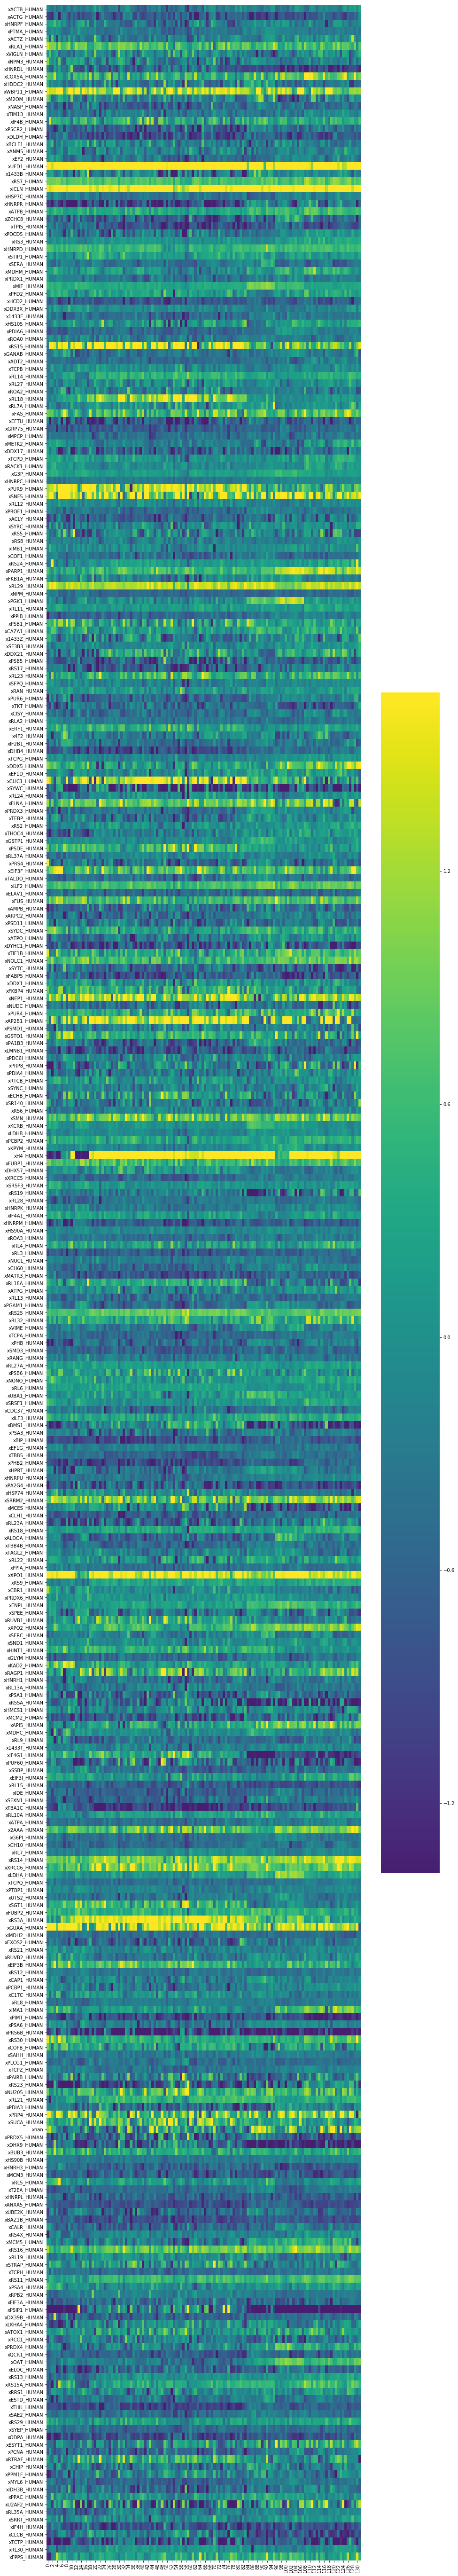

In [294]:
rcParams['figure.figsize'] = 15, 100
sns.heatmap(dfmerge[proteins].dropna(1).T, cmap='viridis', center=0, robust=True)
plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/Fig4B_all_proteins_heatmap.svg')

In [862]:
rcParams['figure.figsize'] = 25, 100
sns.clustermap(dftc_scale.T, col_cluster=False , figsize=(15,100),  cmap='viridis')

# For the complete profiles only

In [581]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_std=False)
dftc = np.log2(1/df_complete)
scaledc = scaler.fit_transform(dftc)
dftc_scale = pd.DataFrame(scaledc , index=dftc.index, columns=dftc.columns)
dftc_scale = dftc_scale.T
dftc = dftc.T

In [685]:
dftc.head()

Protein  sp|P60709|ACTB_HUMAN Actin, cytoplasmic 1 OS=Homo sapiens OX=9606 GN=ACTB PE=1 SV=1  \
001                                              -0.880990                                     
002                                              -1.114837                                     
003                                              -1.235041                                     
004                                              -0.858051                                     
005                                              -1.421695                                     

Protein  sp|P63261|ACTG_HUMAN Actin, cytoplasmic 2 OS=Homo sapiens OX=9606 GN=ACTG1 PE=1 SV=1  \
001                                              -1.910252                                      
002                                              -1.960241                                      
003                                              -2.040244                                      
004                                              -1.001484                                      
005                                              -1.043433                                      

Protein  sp|P52597|HNRPF_HUMAN Heterogeneous nuclear ribonucleoprotein F OS=Homo sapiens OX=9606 GN=HNRNPF PE=1 SV=3  \
001                                              -0.701819                                                             
002                                              -0.569951                                                             
003                                              -0.508452                                                             
004                                              -0.057013                                                             
005                                              -0.761456                                                             

Protein  sp|P06454|PTMA_HUMAN Prothymosin alpha OS=Homo sapiens OX=9606 GN=PTMA PE=1 SV=2  \
001                                              -1.094626                                  
002                                              -0.956627                                  
003                                              -0.756579                                  
004                                              -0.879431                                  
005                                              -0.845873                                  

Protein  sp|P05386|RLA1_HUMAN 60S acidic ribosomal protein P1 OS=Homo sapiens OX=9606 GN=RPLP1 PE=1 SV=1  \
001                                               0.529067                                                 
002                                               0.201952                                                 
003                                               0.174884                                                 
004                                               0.284510                                                 
005                                              -0.471578                                                 

Protein  sp|O75607|NPM3_HUMAN Nucleoplasmin-3 OS=Homo sapiens OX=9606 GN=NPM3 PE=1 SV=3  \
001                                               0.137899                                
002                                              -0.623834                                
003                                              -0.882648                                
004                                              -0.520412                                
005                                              -1.234039                                

Protein  sp|P20674|COX5A_HUMAN Cytochrome c oxidase subunit 5A, mitochondrial OS=Homo sapiens OX=9606 GN=COX5A PE=1 SV=2  \
001                                              -0.146335                                                                 
002                                              -0.151361                                                          

In [680]:
### see that they are scaled, raw distributions on top, scaled on bottom
dfcnp = dftc.to_numpy()
dfcnp_scale= dftc_scale.to_numpy()

rcParams['figure.figsize'] = 15, 5
fig, [[ax1, ax2, ax3, ax4, ax5, ax6], [ax7, ax8, ax9, ax10, ax11, ax12]]= plt.subplots(2,6, sharex='all', sharey='all')
ax1.hist(dfcnp.T[:,0], bins=25)
ax1.axvline(x=0, color='r')
ax2.hist(dfcnp.T[:,1], bins=25)
ax2.axvline(x=0, color='r')
ax3.hist(dfcnp.T[:,2], bins=25)
ax3.axvline(x=0, color='r')
ax4.hist(dfcnp.T[:,3], bins=25)
ax4.axvline(x=0, color='r')
ax5.hist(dfcnp.T[:,4], bins=25)
ax5.axvline(x=0, color='r')
ax6.hist(dfcnp.T[:,5], bins=25)
ax6.axvline(x=0, color='r')
ax1.set_xlim(-6,6)


ax7.hist(dfcnp_scale.T[:,0], bins=25)
ax7.axvline(x=0, color='r')
ax8.hist(dfcnp_scale.T[:,1], bins=25)
ax8.axvline(x=0, color='r')
ax9.hist(dfcnp_scale.T[:,2], bins=25)
ax9.axvline(x=0, color='r')
ax10.hist(dfcnp_scale.T[:,3], bins=25)
ax10.axvline(x=0, color='r')
ax11.hist(dfcnp_scale.T[:,4], bins=25)
ax11.axvline(x=0, color='r')
ax12.hist(dfcnp_scale.T[:,5], bins=25)
ax12.axvline(x=0, color='r')
ax1.set_xlim(-6,6)

(-6, 6)

In [594]:
# read in grouping file
group_df = pd.read_csv("P:/JGM_DI2A/mitotox/20200110_mitotox_screen_sample_IDs.csv", sep=',')
group_df.index = dftc.index
## replace complex protein names with simple text names for anova
prot_shortname = [str(x).split(' ')[0] for x in dftc.columns.values]
prot_shortname = [x.split('|')[-1] for x in prot_shortname]
prot_longnames = dftc_scale.columns.values
dftc_scale.columns = prot_shortname
dftc_scale.columns = 'x'+dftc_scale.columns.values
dfmerge = group_df.merge(dftc_scale, on=dftc.index)

In [595]:
df6hc = dfmerge[dfmerge['Control group']=='6 hr']
df24hc = dfmerge[dfmerge['Control group']=='24h']
df24hc.head()

key_0  Sample Cell line Genotype Media Compound concentration  \
84   085      85      293T       WT  DMEM     4-NB          1 mM   
85   086      86      293T       WT  DMEM     4-NB          1 mM   
86   087      87      293T       WT  DMEM     4-NB          1 mM   
87   088      88      293T       WT  HPLM     4-NB          1 mM   
88   089      89      293T       WT  HPLM     4-NB          1 mM   

   Treatment duration Control group  Replicate  ...  xPCNA_HUMAN  xCHIP_HUMAN  \
84              7 day           24h          1  ...    -0.622457     0.713486   
85              7 day           24h          2  ...    -0.472931     0.837225   
86              7 day           24h          3  ...    -0.350011     0.594801   
87              7 day           24h          1  ...    -0.524005     0.134401   
88              7 day           24h          2  ...    -0.396326     0.614981   

    xPPM1F_HUMAN  xMYL6_HUMAN  xIDH3B_HUMAN  xPPAC_HUMAN  xRL35A_HUMAN  \
84      0.277250    -0.186030      0.010898     0.222770      0.023806   
85     -0.449944    -0.349302     -0.088249     0.461905     -0.217221   
86     -0.316585    -0.006060      0.179704     0.620380      0.026753   
87      0.530734    -0.257956     -0.453783     0.852826     -0.217450   
88      0.567931    -0.233010     -0.343379     0.199833      0.292616   

    xSRRT_HUMAN  xIF4H_HUMAN  xRL30_HUMAN  
84    -0.114542    -1.427825     0.108660  
85     0.213117    -1.126296     0.138520  
86    -0.111099    -0.589232     0.119596  
87    -0.007853    -0.494124     0.041721  
88     0.062603    -1.089106     0.251850  

[5 rows x 304 columns]

In [667]:
### now do loops through all those and post-hoc testing for differences!!!
pvals = []
PATH='P:/JGM_DI2A/Python/outputs/mitotox3/24h_complete/'
for x in dftc_scale.columns.values:
    model = ols(x +'~ C(Genotype)*C(Media)*C(Compound)', df24hc).fit()
    pvals.append(model.f_pvalue)
    table = sm.stats.anova_lm(model, typ=2)
    table.to_csv(PATH+ x+'.csv')  ### write table of ANOVA results
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
    g = sns.catplot(x='Compound', y=x, hue='Genotype', col='Media',
            capsize=.2, height=6, aspect=.75,
            kind="point", data=df24hc, rotation=90)
    g.set_xticklabels(rotation=90)
    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle('OLS f_pval = '+str(np.round(model.f_pvalue, 4)), fontsize=24)
    plt.savefig(PATH + x  + '.png')
    plt.clf()

Overall model F( 15, 32) =  1.999, p =  0.0492
Overall model F( 15, 32) =  2.747, p =  0.0080
Overall model F( 15, 32) =  3.008, p =  0.0043
Overall model F( 15, 32) =  3.443, p =  0.0016
Overall model F( 15, 32) =  0.562, p =  0.8817
Overall model F( 15, 32) =  1.291, p =  0.2636
Overall model F( 15, 32) =  2.217, p =  0.0288
Overall model F( 15, 32) =  3.175, p =  0.0030
Overall model F( 15, 32) =  2.577, p =  0.0120
Overall model F( 15, 32) =  2.715, p =  0.0087
Overall model F( 15, 32) =  1.234, p =  0.2981
Overall model F( 15, 32) =  2.544, p =  0.0130
Overall model F( 15, 32) =  1.398, p =  0.2070
Overall model F( 15, 32) =  1.437, p =  0.1896
Overall model F( 15, 32) =  6.480, p =  0.0000
Overall model F( 15, 32) =  2.834, p =  0.0065
Overall model F( 15, 32) =  2.981, p =  0.0046
Overall model F( 15, 32) =  0.489, p =  0.9285
Overall model F( 15, 32) =  6.694, p =  0.0000
Overall model F( 15, 32) =  2.411, p =  0.0180
Overall model F( 15, 32) =  3.072, p =  0.0038
Overall model

Overall model F( 15, 32) =  0.886, p =  0.5852
Overall model F( 15, 32) =  1.806, p =  0.0786
Overall model F( 15, 32) =  2.127, p =  0.0359
Overall model F( 15, 32) =  1.954, p =  0.0548
Overall model F( 15, 32) =  6.038, p =  0.0000
Overall model F( 15, 32) =  6.197, p =  0.0000
Overall model F( 15, 32) =  1.627, p =  0.1213
Overall model F( 15, 32) =  8.065, p =  0.0000
Overall model F( 15, 32) =  2.940, p =  0.0051
Overall model F( 15, 32) =  3.520, p =  0.0014
Overall model F( 15, 32) =  2.467, p =  0.0157
Overall model F( 15, 32) =  1.594, p =  0.1313
Overall model F( 15, 32) =  5.574, p =  0.0000
Overall model F( 15, 32) =  4.864, p =  0.0001
Overall model F( 15, 32) =  4.192, p =  0.0003
Overall model F( 15, 32) =  2.284, p =  0.0245
Overall model F( 15, 32) =  1.841, p =  0.0722
Overall model F( 15, 32) =  25.695, p =  0.0000
Overall model F( 15, 32) =  1.560, p =  0.1420
Overall model F( 15, 32) =  5.046, p =  0.0001
Overall model F( 15, 32) =  5.870, p =  0.0000
Overall mode

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

In [ ]:
'P:/JGM_DI2A/Python/outputs/mitotox3/6h_complete/'

In [673]:
g = sns.catplot(x='Media', y='xANM5_HUMAN', hue='Genotype',
        capsize=.2, height=6, aspect=.75,
        kind="point", data=df6hc, rotation=90)

In [674]:
g = sns.catplot(x='Genotype', y='xANM5_HUMAN', hue='Media',
        capsize=.2, height=6, aspect=.75,
        kind="point", data=df6hc, rotation=90)

In [669]:
pvals = []
PATH = 'P:/JGM_DI2A/Python/outputs/mitotox3/6h_complete/'
counter=0
for x in dftc_scale.columns.values:
    print(x)
    model = ols(x +'~ C(Genotype)*C(Media)*C(Compound)', df6hc).fit()
    pvals.append(model.f_pvalue)
    table = sm.stats.anova_lm(model, typ=2)
    table.to_csv(PATH+ x+'.csv')
    print(table)
    #print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
    g = sns.catplot(x='Compound', y=x, hue='Genotype', col='Media',
            capsize=.2, height=6, aspect=.75,
            kind="point", data=df6hc, rotation=90)
    g.set_xticklabels(rotation=90)
    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle('OLS f_pval = '+str(np.round(model.f_pvalue, 4)), fontsize=24)
    plt.savefig(PATH + x  + '.png')
    plt.clf()
    counter+=1

xACTB_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       1.043607   1.0  14.003062  0.000432
C(Media)                          0.073373   1.0   0.984513  0.325355
C(Compound)                       1.501948   6.0   3.358842  0.006736
C(Genotype):C(Media)              0.000499   1.0   0.006694  0.935082
C(Genotype):C(Compound)           0.299159   6.0   0.669016  0.674941
C(Media):C(Compound)              0.390119   6.0   0.872431  0.521003
C(Genotype):C(Media):C(Compound)  0.281699   6.0   0.629971  0.705590
Residual                          4.173516  56.0        NaN       NaN
xACTG_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       2.450455   1.0  15.806703  0.000203
C(Media)                          0.003834   1.0   0.024729  0.875610
C(Compound)                       0.519336   6.0   0.558331  0.761453
C(Genotype):C(Media)              0.014589   1.0   0.094107  0.760

xANM5_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.111362   1.0   0.903645  0.345891
C(Media)                          0.000567   1.0   0.004599  0.946175
C(Compound)                       0.380027   6.0   0.513955  0.795262
C(Genotype):C(Media)              1.347113   1.0  10.931144  0.001655
C(Genotype):C(Compound)           0.865907   6.0   1.171066  0.334879
C(Media):C(Compound)              0.616955   6.0   0.834380  0.548559
C(Genotype):C(Media):C(Compound)  2.318755   6.0   3.135922  0.010125
Residual                          6.901229  56.0        NaN       NaN
xEF2_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       1.170011   1.0  11.624946  0.001213
C(Media)                          0.286862   1.0   2.850194  0.096925
C(Compound)                       2.976843   6.0   4.929531  0.000412
C(Genotype):C(Media)              0.059701   1.0   0.593179  0.4444

xSTIP1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.031278   1.0  0.437341  0.511121
C(Media)                          0.004331   1.0  0.060561  0.806512
C(Compound)                       1.983516   6.0  4.622426  0.000703
C(Genotype):C(Media)              0.000003   1.0  0.000048  0.994525
C(Genotype):C(Compound)           0.257064   6.0  0.599067  0.729804
C(Media):C(Compound)              0.468820   6.0  1.092547  0.378241
C(Genotype):C(Media):C(Compound)  0.302935   6.0  0.705965  0.646054
Residual                          4.005000  56.0       NaN       NaN
xSERA_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       1.199941   1.0  31.816490  5.796583e-07
C(Media)                          0.135595   1.0   3.595309  6.310658e-02
C(Compound)                       0.468403   6.0   2.069957  7.134114e-02
C(Genotype):C(Media)              0.027036   1.0   0.71685

xGANAB_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.508271   1.0  6.671911  0.012434
C(Media)                          0.000371   1.0  0.004864  0.944648
C(Compound)                       2.999746   6.0  6.562784  0.000027
C(Genotype):C(Media)              0.058423   1.0  0.766896  0.384920
C(Genotype):C(Compound)           0.718180   6.0  1.571220  0.172652
C(Media):C(Compound)              0.196216   6.0  0.429277  0.856335
C(Genotype):C(Media):C(Compound)  1.043231   6.0  2.282360  0.048491
Residual                          4.266120  56.0       NaN       NaN
xADT2_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.021026   1.0  1.027462  0.315115
C(Media)                          0.002035   1.0  0.099437  0.753678
C(Compound)                       0.040187   6.0  0.327297  0.919876
C(Genotype):C(Media)              0.000725   1.0  0.035414  0.851411
C(Genotyp

xTCPD_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.738737   1.0  16.189428  0.000174
C(Media)                          0.155093   1.0   3.398873  0.070535
C(Compound)                       1.841169   6.0   6.724876  0.000021
C(Genotype):C(Media)              0.041557   1.0   0.910720  0.344025
C(Genotype):C(Compound)           0.281123   6.0   1.026803  0.417676
C(Media):C(Compound)              0.350447   6.0   1.280008  0.281358
C(Genotype):C(Media):C(Compound)  0.168277   6.0   0.614633  0.717621
Residual                          2.555325  56.0        NaN       NaN
xRACK1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.019066   1.0  0.459604  0.500601
C(Media)                          0.035851   1.0  0.864222  0.356550
C(Compound)                       0.682424   6.0  2.741743  0.020880
C(Genotype):C(Media)              0.001308   1.0  0.031539  0.859684


xPARP1_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       1.975323   1.0  32.643416  4.425456e-07
C(Media)                          0.000099   1.0   0.001631  9.679321e-01
C(Compound)                       0.934611   6.0   2.574168  2.841033e-02
C(Genotype):C(Media)              0.074439   1.0   1.230148  2.721187e-01
C(Genotype):C(Compound)           0.609911   6.0   1.679857  1.429798e-01
C(Media):C(Compound)              0.675882   6.0   1.861562  1.037299e-01
C(Genotype):C(Media):C(Compound)  0.439909   6.0   1.211627  3.140626e-01
Residual                          3.388680  56.0        NaN           NaN
xFKB1A_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.124991   1.0  0.697354  0.407223
C(Media)                           0.071245   1.0  0.397493  0.530951
C(Compound)                        2.082343   6.0  1.936308  0.090756
C(Genotype):C(Media)        

xRL23_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       1.967351   1.0  12.438937  0.000847
C(Media)                          0.247515   1.0   1.564961  0.216142
C(Compound)                       2.679681   6.0   2.823796  0.017957
C(Genotype):C(Media)              0.112219   1.0   0.709528  0.403184
C(Genotype):C(Compound)           1.168328   6.0   1.231161  0.304417
C(Media):C(Compound)              0.566610   6.0   0.597083  0.731354
C(Genotype):C(Media):C(Compound)  3.050732   6.0   3.214803  0.008763
Residual                          8.856998  56.0        NaN       NaN
xSFPQ_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.155918   1.0  2.778417  0.101127
C(Media)                          0.162602   1.0  2.897518  0.094262
C(Compound)                       0.736757   6.0  2.188130  0.057576
C(Genotype):C(Media)              0.092892   1.0  1.655315  0.203531
C

xCLIC1_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        4.697699   1.0  6.596794  0.012910
C(Media)                           0.369399   1.0  0.518733  0.474378
C(Compound)                        5.538696   6.0  1.296296  0.274000
C(Genotype):C(Media)               0.090738   1.0  0.127420  0.722463
C(Genotype):C(Compound)            7.177453   6.0  1.679836  0.142985
C(Media):C(Compound)               5.452953   6.0  1.276228  0.283089
C(Genotype):C(Media):C(Compound)   8.075777   6.0  1.890083  0.098584
Residual                          39.878635  56.0       NaN       NaN
xSYWC_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.254539   1.0  0.238350  0.627307
C(Media)                           0.438641   1.0  0.410744  0.524207
C(Compound)                        9.029042   6.0  1.409131  0.227390
C(Genotype):C(Media)               0.182498   1.0  0.170891  0.68

xILF2_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.209526   1.0  7.986871  0.006520
C(Media)                          0.001615   1.0  0.061553  0.804965
C(Compound)                       0.184389   6.0  1.171442  0.334681
C(Genotype):C(Media)              0.003252   1.0  0.123981  0.726078
C(Genotype):C(Compound)           0.081864   6.0  0.520090  0.790643
C(Media):C(Compound)              0.443211   6.0  2.815772  0.018224
C(Genotype):C(Media):C(Compound)  0.249541   6.0  1.585365  0.168492
Residual                          1.469095  56.0       NaN       NaN
xELAV1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000342   1.0  0.004567  0.946358
C(Media)                          0.006354   1.0  0.084961  0.771760
C(Compound)                       0.539772   6.0  1.202935  0.318433
C(Genotype):C(Media)              0.107461   1.0  1.436926  0.235686
C(Genotyp

xNUDC_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       1.781130   1.0  11.391312  0.001346
C(Media)                          0.743020   1.0   4.752022  0.033484
C(Compound)                       0.586038   6.0   0.624673  0.709747
C(Genotype):C(Media)              0.000563   1.0   0.003599  0.952377
C(Genotype):C(Compound)           0.284818   6.0   0.303595  0.932481
C(Media):C(Compound)              0.658239   6.0   0.701634  0.649429
C(Genotype):C(Media):C(Compound)  0.178372   6.0   0.190132  0.978382
Residual                          8.756083  56.0        NaN       NaN
xPUR4_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.057976   1.0  0.362735  0.549422
C(Media)                          0.003463   1.0  0.021665  0.883511
C(Compound)                       1.155306   6.0  1.204731  0.317526
C(Genotype):C(Media)              0.031972   1.0  0.200042  0.656413
C

xKPYM_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.037242   1.0  1.183371  0.281331
C(Media)                          0.004357   1.0  0.138441  0.711240
C(Compound)                       0.241303   6.0  1.277906  0.282320
C(Genotype):C(Media)              0.050772   1.0  1.613294  0.209282
C(Genotype):C(Compound)           0.172412   6.0  0.913070  0.492424
C(Media):C(Compound)              0.112077   6.0  0.593544  0.734118
C(Genotype):C(Media):C(Compound)  0.298858   6.0  1.582709  0.169266
Residual                          1.762384  56.0       NaN       NaN
xH4_HUMAN
                                     sum_sq    df           F        PR(>F)
C(Genotype)                       23.636391   1.0  203.984191  2.554466e-20
C(Media)                           0.032044   1.0    0.276539  6.010552e-01
C(Compound)                       85.377524   6.0  122.802624  2.236557e-30
C(Genotype):C(Media)               0.080677   1.0    

xRL4_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000182   1.0  0.001425  0.970017
C(Media)                          0.014758   1.0  0.115298  0.735462
C(Compound)                       0.690788   6.0  0.899468  0.501887
C(Genotype):C(Media)              0.039749   1.0  0.310543  0.579568
C(Genotype):C(Compound)           0.600534   6.0  0.781950  0.587641
C(Media):C(Compound)              0.720370   6.0  0.937987  0.475369
C(Genotype):C(Media):C(Compound)  0.820349   6.0  1.068169  0.392533
Residual                          7.167963  56.0       NaN       NaN
xRL3_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.037575   1.0  0.724017  0.398453
C(Media)                          0.033409   1.0  0.643733  0.425754
C(Compound)                       0.364998   6.0  1.172151  0.334308
C(Genotype):C(Media)              0.001184   1.0  0.022807  0.880502
C(Genotype):

xIF4A3_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.066624   1.0  0.599360  0.442079
C(Media)                          0.095592   1.0  0.859956  0.357731
C(Compound)                       1.057143   6.0  1.585030  0.168590
C(Genotype):C(Media)              0.035259   1.0  0.317198  0.575545
C(Genotype):C(Compound)           0.866290   6.0  1.298874  0.272851
C(Media):C(Compound)              1.172632   6.0  1.758188  0.124601
C(Genotype):C(Media):C(Compound)  2.136720   6.0  3.203697  0.008943
Residual                          6.224909  56.0       NaN       NaN
xSMD3_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.076872   1.0  1.800563  0.185060
C(Media)                          0.001872   1.0  0.043844  0.834904
C(Compound)                       0.367402   6.0  1.434267  0.218001
C(Genotype):C(Media)              0.002082   1.0  0.048756  0.826046
C(Genotyp

xEF1G_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.142317   1.0  5.785723  0.019485
C(Media)                          0.023902   1.0  0.971712  0.328494
C(Compound)                       0.220622   6.0  1.494849  0.196767
C(Genotype):C(Media)              0.056859   1.0  2.311512  0.134046
C(Genotype):C(Compound)           0.133022   6.0  0.901306  0.500602
C(Media):C(Compound)              0.420322   6.0  2.847938  0.017177
C(Genotype):C(Media):C(Compound)  0.112105   6.0  0.759581  0.604651
Residual                          1.377490  56.0       NaN       NaN
xTBB5_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.171783   1.0   7.830451  7.032010e-03
C(Media)                          0.001188   1.0   0.054168  8.168118e-01
C(Compound)                       2.528688   6.0  19.211050  5.194482e-12
C(Genotype):C(Media)              0.026600   1.0   1.212521

xTAGL2_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.052768   1.0  0.960546  0.331265
C(Media)                          0.019692   1.0  0.358459  0.551778
C(Compound)                       0.909738   6.0  2.760024  0.020190
C(Genotype):C(Media)              0.082296   1.0  1.498057  0.226095
C(Genotype):C(Compound)           1.059451   6.0  3.214232  0.008772
C(Media):C(Compound)              1.519426   6.0  4.609737  0.000719
C(Genotype):C(Media):C(Compound)  0.452627   6.0  1.373210  0.241423
Residual                          3.076382  56.0       NaN       NaN
xRL22_HUMAN
                                     sum_sq    df          F        PR(>F)
C(Genotype)                        7.607175   1.0  34.921056  2.133332e-07
C(Media)                           0.211045   1.0   0.968813  3.292101e-01
C(Compound)                        0.887152   6.0   0.678752  6.673120e-01
C(Genotype):C(Media)               0.316013   1.0   1.

xGLYM_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.527130   1.0  9.229374  0.003614
C(Media)                          0.110583   1.0  1.936163  0.169589
C(Compound)                       0.335449   6.0  0.978881  0.448190
C(Genotype):C(Media)              0.011113   1.0  0.194569  0.660839
C(Genotype):C(Compound)           0.362662   6.0  1.058292  0.398434
C(Media):C(Compound)              0.609169   6.0  1.777630  0.120395
C(Genotype):C(Media):C(Compound)  0.313441   6.0  0.914660  0.491325
Residual                          3.198403  56.0       NaN       NaN
xKAD2_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       1.994467   1.0  28.041921  2.059447e-06
C(Media)                          0.021533   1.0   0.302755  5.843486e-01
C(Compound)                       7.628037   6.0  17.874847  1.899527e-11
C(Genotype):C(Media)              0.178092   1.0   2.503952

xSSBP_HUMAN
                                        sum_sq    df          F        PR(>F)
C(Genotype)                       2.791519e-01   1.0   5.048241  2.861115e-02
C(Media)                          2.084496e-07   1.0   0.000004  9.984578e-01
C(Compound)                       4.119052e+00   6.0  12.414967  7.711509e-09
C(Genotype):C(Media)              1.089319e-03   1.0   0.019699  8.888833e-01
C(Genotype):C(Compound)           1.068703e+00   6.0   3.221109  8.662785e-03
C(Media):C(Compound)              3.491101e-01   6.0   1.052230  4.020879e-01
C(Genotype):C(Media):C(Compound)  3.540821e-01   6.0   1.067216  3.930992e-01
Residual                          3.096624e+00  56.0        NaN           NaN
xEIF3I_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.000674   1.0  0.007037  0.933445
C(Media)                          0.187862   1.0  1.962401  0.166774
C(Compound)                       0.652091   6.0  1.135288  0.3541

xLDHA_HUMAN
                                    sum_sq    df          F    PR(>F)
C(Genotype)                       0.779892   1.0  28.433947  0.000002
C(Media)                          0.044835   1.0   1.634624  0.206338
C(Compound)                       0.367629   6.0   2.233885  0.052974
C(Genotype):C(Media)              0.002469   1.0   0.090029  0.765251
C(Genotype):C(Compound)           0.096137   6.0   0.584172  0.741424
C(Media):C(Compound)              0.133443   6.0   0.810863  0.565941
C(Genotype):C(Media):C(Compound)  0.327525   6.0   1.990197  0.082383
Residual                          1.535979  56.0        NaN       NaN
xTCPQ_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.197000   1.0  6.954274  0.010803
C(Media)                          0.006831   1.0  0.241137  0.625305
C(Compound)                       0.156346   6.0  0.919859  0.487741
C(Genotype):C(Media)              0.002569   1.0  0.090698  0.764407
C

xRS12_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.046748   1.0  2.531110  0.117252
C(Media)                          0.000104   1.0  0.005606  0.940580
C(Compound)                       0.313006   6.0  2.824558  0.017932
C(Genotype):C(Media)              0.029648   1.0  1.605242  0.210406
C(Genotype):C(Compound)           0.287487   6.0  2.594270  0.027380
C(Media):C(Compound)              0.061073   6.0  0.551123  0.767001
C(Genotype):C(Media):C(Compound)  0.036855   6.0  0.332580  0.916940
Residual                          1.034282  56.0       NaN       NaN
xCAP1_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.378767   1.0  2.831297  0.098012
C(Media)                          0.162616   1.0  1.215563  0.274949
C(Compound)                       0.301456   6.0  0.375565  0.891506
C(Genotype):C(Media)              0.168579   1.0  1.260134  0.266416
C(Genotype

xPAIRB_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.595107   1.0  1.545757  0.218943
C(Media)                           1.377631   1.0  3.578317  0.063714
C(Compound)                        3.774481   6.0  1.633999  0.154880
C(Genotype):C(Media)               0.000621   1.0  0.001613  0.968111
C(Genotype):C(Compound)            1.768927   6.0  0.765781  0.599918
C(Media):C(Compound)               1.165544   6.0  0.504572  0.802285
C(Genotype):C(Media):C(Compound)   0.698269   6.0  0.302285  0.933150
Residual                          21.559674  56.0       NaN       NaN
xRS23_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.044043   1.0  0.154649  0.695625
C(Media)                           2.452171   1.0  8.610425  0.004838
C(Compound)                        5.103975   6.0  2.986972  0.013306
C(Genotype):C(Media)               1.411031   1.0  4.954620  0.03

xBAZ1B_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.218736   1.0  3.268523  0.075993
C(Media)                          0.220187   1.0  3.290206  0.075053
C(Compound)                       0.894405   6.0  2.227479  0.053596
C(Genotype):C(Media)              0.001811   1.0  0.027056  0.869941
C(Genotype):C(Compound)           0.121085   6.0  0.301558  0.933520
C(Media):C(Compound)              0.331741   6.0  0.826187  0.554585
C(Genotype):C(Media):C(Compound)  0.719867   6.0  1.792798  0.117207
Residual                          3.747637  56.0       NaN       NaN
xCALR_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.103021   1.0  0.855739  0.358903
C(Media)                          0.038127   1.0  0.316702  0.575843
C(Compound)                       1.075768   6.0  1.489305  0.198630
C(Genotype):C(Media)              0.263678   1.0  2.190229  0.144493
C(Genotyp

xELOC_HUMAN
                                     sum_sq    df         F    PR(>F)
C(Genotype)                        0.003875   1.0  0.017969  0.893845
C(Media)                           0.007185   1.0  0.033317  0.855826
C(Compound)                        5.148685   6.0  3.979373  0.002193
C(Genotype):C(Media)               0.193921   1.0  0.899279  0.347050
C(Genotype):C(Compound)            2.121982   6.0  1.640061  0.153256
C(Media):C(Compound)               0.782657   6.0  0.604908  0.725236
C(Genotype):C(Media):C(Compound)   0.845622   6.0  0.653574  0.687058
Residual                          12.075872  56.0       NaN       NaN
xRS13_HUMAN
                                    sum_sq    df          F        PR(>F)
C(Genotype)                       0.375379   1.0  12.074942  9.939413e-04
C(Media)                          0.044741   1.0   1.439202  2.353196e-01
C(Compound)                       3.538118   6.0  18.968628  6.543669e-12
C(Genotype):C(Media)              0.195335   1.0  

xPPM1F_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.573331   1.0  3.579447  0.063673
C(Media)                          0.001951   1.0  0.012181  0.912514
C(Compound)                       5.110563   6.0  5.317751  0.000212
C(Genotype):C(Media)              0.002556   1.0  0.015961  0.899918
C(Genotype):C(Compound)           4.257684   6.0  4.430295  0.000984
C(Media):C(Compound)              0.712694   6.0  0.741587  0.618457
C(Genotype):C(Media):C(Compound)  2.307832   6.0  2.401394  0.039005
Residual                          8.969692  56.0       NaN       NaN
xMYL6_HUMAN
                                    sum_sq    df         F    PR(>F)
C(Genotype)                       0.001009   1.0  0.023263  0.879324
C(Media)                          0.096883   1.0  2.234412  0.140582
C(Compound)                       0.246906   6.0  0.949062  0.467907
C(Genotype):C(Media)              0.004239   1.0  0.097772  0.755681
C(Genotyp

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

<Figure size 838.975x480 with 0 Axes>

In [605]:
dftc_scale.columns.values

array(['xACTB_HUMAN', 'xACTG_HUMAN', 'xHNRPF_HUMAN', 'xPTMA_HUMAN',
       'xRLA1_HUMAN', 'xNPM3_HUMAN', 'xCOX5A_HUMAN', 'xHDDC2_HUMAN',
       'xNASP_HUMAN', 'xTIM13_HUMAN', 'xP5CR2_HUMAN', 'xDLDH_HUMAN',
       'xBCLF1_HUMAN', 'xANM5_HUMAN', 'xEF2_HUMAN', 'x1433B_HUMAN',
       'xRS7_HUMAN', 'xICLN_HUMAN', 'xHSP7C_HUMAN', 'xHNRPR_HUMAN',
       'xATPB_HUMAN', 'xZCHC8_HUMAN', 'xTPIS_HUMAN', 'xPDCD5_HUMAN',
       'xRS3_HUMAN', 'xHNRPD_HUMAN', 'xSTIP1_HUMAN', 'xSERA_HUMAN',
       'xMDHM_HUMAN', 'xPRDX1_HUMAN', 'xMIF_HUMAN', 'xPFD2_HUMAN',
       'xHCD2_HUMAN', 'xDDX3X_HUMAN', 'x1433E_HUMAN', 'xHS105_HUMAN',
       'xPDIA6_HUMAN', 'xROA0_HUMAN', 'xRS15_HUMAN', 'xGANAB_HUMAN',
       'xADT2_HUMAN', 'xTCPB_HUMAN', 'xRL14_HUMAN', 'xRL27_HUMAN',
       'xRL18_HUMAN', 'xRL7A_HUMAN', 'xFAS_HUMAN', 'xEFTU_HUMAN',
       'xGRP75_HUMAN', 'xMPCP_HUMAN', 'xMETK2_HUMAN', 'xDDX17_HUMAN',
       'xTCPD_HUMAN', 'xRACK1_HUMAN', 'xG3P_HUMAN', 'xHNRPC_HUMAN',
       'xPUR9_HUMAN', 'xRL12_HUMAN', 'xPROF1

In [604]:
g = sns.catplot(x='Compound', y=dftc_scale.columns.values[3], hue='Genotype', col='Media',
                capsize=.2, height=6, aspect=.75,
                kind="point", data=df24hc)

In [664]:
table = sm.stats.anova_lm(model, typ=2)
print(table)
print(model.f_pvalue)
table.to_csv('P:/JGM_DI2A/Python/outputs/mitotox3/6h_complete/'+'.csv')

                                        sum_sq    df         F    PR(>F)
C(Genotype)                       1.259928e-01   1.0  3.618038  0.066190
C(Media)                          6.021060e-05   1.0  0.001729  0.967091
C(Compound)                       7.590264e-01   3.0  7.265457  0.000752
C(Genotype):C(Media)              5.744852e-07   1.0  0.000016  0.996784
C(Genotype):C(Compound)           8.327487e-02   3.0  0.797113  0.504606
C(Media):C(Compound)              1.821138e-01   3.0  1.743207  0.177934
C(Genotype):C(Media):C(Compound)  5.722193e-02   3.0  0.547733  0.653281
Residual                          1.114353e+00  32.0       NaN       NaN
0.02286463397290921
